<a href="https://colab.research.google.com/github/mateusnotgado/Breast-cancer-project/blob/main/Cancer_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 383.6/383.6 kB 18.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 231.8/231.8 kB 12.8 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import numpy as np
import cv2
import PIL
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import glob
import random
import os
from os import listdir
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from keras.utils import to_categorical
import torch
import torchvision
from PIL import Image
from pathlib import Path
import sys
import torchvision.transforms as T
import torchvision.models as M
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.metrics import classification_report
import optuna
random.seed(100)
np.random.seed(100)

#Data loading

## dicom load

In [ ]:
import kagglehub
awsaf49_cbis_ddsm_breast_cancer_image_dataset_path = kagglehub.dataset_download('awsaf49/cbis-ddsm-breast-cancer-image-dataset')

print('Data source import complete.')

100%|██████████| 4.95G/4.95G [03:44<00:00, 23.7MB/s]

Extracting files...


Data source import complete.


In [ ]:
awsaf49_cbis_ddsm_breast_cancer_image_dataset_path

'/root/.cache/kagglehub/datasets/awsaf49/cbis-ddsm-breast-cancer-image-dataset/versions/1'

In [ ]:
dicom_data = pd.read_csv(awsaf49_cbis_ddsm_breast_cancer_image_dataset_path+'/csv/dicom_info.csv')

In [ ]:
dicom_data.head()

,file_path,image_path,AccessionNumber,BitsAllocated,BitsStored,BodyPartExamined,Columns,ContentDate,ContentTime,ConversionType,...,SecondaryCaptureDeviceManufacturerModelName,SeriesDescription,SeriesInstanceUID,SeriesNumber,SmallestImagePixelValue,SpecificCharacterSet,StudyDate,StudyID,StudyInstanceUID,StudyTime
0,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.12930...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...,NaN,16,16,BREAST,351,20160426,131732.685,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.129308726812851964007...,1,23078,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.271867287611061855725...,214951.0
1,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.24838...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...,NaN,16,16,BREAST,3526,20160426,143829.101,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.248386742010678582309...,1,0,ISO_IR 100,20160720.0,DDSM,1.3.6.1.4.1.9590.100.1.2.161516517311681906612...,193426.0
2,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.26721...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...,NaN,16,16,BREAST,1546,20160503,111956.298,WSD,...,MATLAB,full mammogram images,1.3.6.1.4.1.9590.100.1.2.267213171011171858918...,1,0,ISO_IR 100,20160807.0,DDSM,1.3.6.1.4.1.9590.100.1.2.291043622711253836701...,161814.0
3,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,16,16,BREAST,97,20160503,115347.770,WSD,...,MATLAB,cropped images,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,32298,ISO_IR 100,20170829.0,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,180109.0
4,CBIS-DDSM/dicom/1.3.6.1.4.1.9590.100.1.2.38118...,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...,NaN,8,8,Left Breast,3104,20160503,115347.770,WSD,...,MATLAB,NaN,1.3.6.1.4.1.9590.100.1.2.381187369611524586537...,1,0,ISO_IR 100,NaN,DDSM,1.3.6.1.4.1.9590.100.1.2.335006093711888937440...,NaN


In [ ]:
image_dir=awsaf49_cbis_ddsm_breast_cancer_image_dataset_path+'/jpeg'
image_dir

'/root/.cache/kagglehub/datasets/awsaf49/cbis-ddsm-breast-cancer-image-dataset/versions/1/jpeg'

In [ ]:
os.listdir(awsaf49_cbis_ddsm_breast_cancer_image_dataset_path+'/csv')

['dicom_info.csv',
 'meta.csv',
 'mass_case_description_train_set.csv',
 'calc_case_description_train_set.csv',
 'mass_case_description_test_set.csv',
 'calc_case_description_test_set.csv']

In [ ]:
cropped_images=dicom_data[dicom_data.SeriesDescription == 'cropped images'].image_path
cropped_images.head()

,image_path
0,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...
3,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...
6,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...
7,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...
10,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...


In [ ]:
#cropped_images = cropped_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
cropped_images = cropped_images.replace('CBIS-DDSM/jpeg', image_dir, regex=True)
cropped_images.head()

,image_path
0,/root/.cache/kagglehub/datasets/awsaf49/cbis-d...
3,/root/.cache/kagglehub/datasets/awsaf49/cbis-d...
6,/root/.cache/kagglehub/datasets/awsaf49/cbis-d...
7,/root/.cache/kagglehub/datasets/awsaf49/cbis-d...
10,/root/.cache/kagglehub/datasets/awsaf49/cbis-d...


In [ ]:
full_mammogram_images=dicom_data[dicom_data.SeriesDescription == 'full mammogram images'].image_path
full_mammogram_images.head()

,image_path
1,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...
2,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...
11,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.210396...
12,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.749566...
15,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.987658...


In [ ]:
#full_mammogram_images = full_mammogram_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
full_mammogram_images = full_mammogram_images.replace('CBIS-DDSM/jpeg', image_dir, regex=True)
full_mammogram_images.head()

,image_path
1,/root/.cache/kagglehub/datasets/awsaf49/cbis-d...
2,/root/.cache/kagglehub/datasets/awsaf49/cbis-d...
11,/root/.cache/kagglehub/datasets/awsaf49/cbis-d...
12,/root/.cache/kagglehub/datasets/awsaf49/cbis-d...
15,/root/.cache/kagglehub/datasets/awsaf49/cbis-d...


In [ ]:
ROI_mask_images=dicom_data[dicom_data.SeriesDescription == 'ROI mask images'].image_path
ROI_mask_images.head()

,image_path
5,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...
8,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...
9,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...
14,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.236373...
20,CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.357008...


In [ ]:
#ROI_mask_images = ROI_mask_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
ROI_mask_images = ROI_mask_images.replace('CBIS-DDSM/jpeg', image_dir, regex=True)
ROI_mask_images.head()

,image_path
5,/root/.cache/kagglehub/datasets/awsaf49/cbis-d...
8,/root/.cache/kagglehub/datasets/awsaf49/cbis-d...
9,/root/.cache/kagglehub/datasets/awsaf49/cbis-d...
14,/root/.cache/kagglehub/datasets/awsaf49/cbis-d...
20,/root/.cache/kagglehub/datasets/awsaf49/cbis-d...


In [ ]:
# imagens sem rotulo, seila o que eu faço com isso
null_images=dicom_data[dicom_data.SeriesDescription.isnull()].image_path
null_images = null_images.apply(lambda x: x.replace('CBIS-DDSM/jpeg', image_dir))
null_images.head()

,image_path
4,/root/.cache/kagglehub/datasets/awsaf49/cbis-d...
27,/root/.cache/kagglehub/datasets/awsaf49/cbis-d...
73,/root/.cache/kagglehub/datasets/awsaf49/cbis-d...
76,/root/.cache/kagglehub/datasets/awsaf49/cbis-d...
85,/root/.cache/kagglehub/datasets/awsaf49/cbis-d...


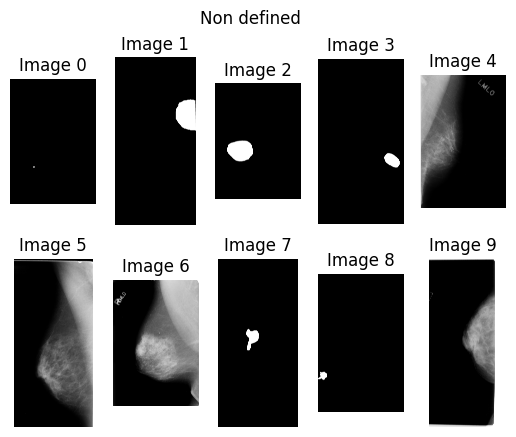

In [ ]:
for i, name in enumerate(null_images[0:10]):
  plt.subplot(2, 5, i+1)
  plt.imshow(PIL.Image.open(name), cmap='gray')
  plt.axis('off')  # Hide the axis labels
  plt.title("Image "+str(i))
plt.suptitle("Non defined")
plt.show()

In [ ]:
len(cropped_images), len(full_mammogram_images), len(ROI_mask_images)

(3567, 2857, 3247)

##mass calc

### load data

In [ ]:
mass_train = pd.read_csv(awsaf49_cbis_ddsm_breast_cancer_image_dataset_path+'/csv/mass_case_description_train_set.csv')
mass_train.head()

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,Mass-Training_P_00001_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_CC/1.3.6.1.4.1.9590...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,Mass-Training_P_00004_LEFT_MLO/1.3.6.1.4.1.959...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,Mass-Training_P_00004_RIGHT_MLO/1.3.6.1.4.1.95...,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....


In [ ]:
mass_test = pd.read_csv(awsaf49_cbis_ddsm_breast_cancer_image_dataset_path+'/csv/mass_case_description_test_set.csv')
mass_test.head()

,patient_id,breast_density,left or right breast,image view,abnormality id,abnormality type,mass shape,mass margins,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00016,4,LEFT,CC,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,Mass-Test_P_00016_LEFT_CC/1.3.6.1.4.1.9590.100...,Mass-Test_P_00016_LEFT_CC_1/1.3.6.1.4.1.9590.1...,Mass-Test_P_00016_LEFT_CC_1/1.3.6.1.4.1.9590.1...
1,P_00016,4,LEFT,MLO,1,mass,IRREGULAR,SPICULATED,5,MALIGNANT,5,Mass-Test_P_00016_LEFT_MLO/1.3.6.1.4.1.9590.10...,Mass-Test_P_00016_LEFT_MLO_1/1.3.6.1.4.1.9590....,Mass-Test_P_00016_LEFT_MLO_1/1.3.6.1.4.1.9590....
2,P_00017,2,LEFT,CC,1,mass,ROUND,CIRCUMSCRIBED,4,MALIGNANT,4,Mass-Test_P_00017_LEFT_CC/1.3.6.1.4.1.9590.100...,Mass-Test_P_00017_LEFT_CC_1/1.3.6.1.4.1.9590.1...,Mass-Test_P_00017_LEFT_CC_1/1.3.6.1.4.1.9590.1...
3,P_00017,2,LEFT,MLO,1,mass,ROUND,ILL_DEFINED,4,MALIGNANT,4,Mass-Test_P_00017_LEFT_MLO/1.3.6.1.4.1.9590.10...,Mass-Test_P_00017_LEFT_MLO_1/1.3.6.1.4.1.9590....,Mass-Test_P_00017_LEFT_MLO_1/1.3.6.1.4.1.9590....
4,P_00032,3,RIGHT,CC,1,mass,ROUND,OBSCURED,0,BENIGN,2,Mass-Test_P_00032_RIGHT_CC/1.3.6.1.4.1.9590.10...,Mass-Test_P_00032_RIGHT_CC_1/1.3.6.1.4.1.9590....,Mass-Test_P_00032_RIGHT_CC_1/1.3.6.1.4.1.9590....


In [ ]:
calc_train=pd.read_csv(awsaf49_cbis_ddsm_breast_cancer_image_dataset_path+'/csv/calc_case_description_train_set.csv')
calc_train.head()

,patient_id,breast density,left or right breast,image view,abnormality id,abnormality type,calc type,calc distribution,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00005,3,RIGHT,CC,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_CC/1.3.6.1.4.1.959...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...
1,P_00005,3,RIGHT,MLO,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,Calc-Training_P_00005_RIGHT_MLO/1.3.6.1.4.1.95...,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....
2,P_00007,4,LEFT,CC,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,Calc-Training_P_00007_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00007,4,LEFT,MLO,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,Calc-Training_P_00007_LEFT_MLO/1.3.6.1.4.1.959...,Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...,Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00008,1,LEFT,CC,1,calcification,NaN,REGIONAL,2,BENIGN_WITHOUT_CALLBACK,3,Calc-Training_P_00008_LEFT_CC/1.3.6.1.4.1.9590...,Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...,Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...


In [ ]:
calc_test=pd.read_csv(awsaf49_cbis_ddsm_breast_cancer_image_dataset_path+'/csv/calc_case_description_test_set.csv')
calc_test.head()

,patient_id,breast density,left or right breast,image view,abnormality id,abnormality type,calc type,calc distribution,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path
0,P_00038,2,LEFT,CC,1,calcification,PUNCTATE-PLEOMORPHIC,CLUSTERED,4,BENIGN,2,Calc-Test_P_00038_LEFT_CC/1.3.6.1.4.1.9590.100...,Calc-Test_P_00038_LEFT_CC_1/1.3.6.1.4.1.9590.1...,Calc-Test_P_00038_LEFT_CC_1/1.3.6.1.4.1.9590.1...
1,P_00038,2,LEFT,MLO,1,calcification,PUNCTATE-PLEOMORPHIC,CLUSTERED,4,BENIGN,2,Calc-Test_P_00038_LEFT_MLO/1.3.6.1.4.1.9590.10...,Calc-Test_P_00038_LEFT_MLO_1/1.3.6.1.4.1.9590....,Calc-Test_P_00038_LEFT_MLO_1/1.3.6.1.4.1.9590....
2,P_00038,2,RIGHT,CC,1,calcification,VASCULAR,NaN,2,BENIGN_WITHOUT_CALLBACK,5,Calc-Test_P_00038_RIGHT_CC/1.3.6.1.4.1.9590.10...,Calc-Test_P_00038_RIGHT_CC_1/1.3.6.1.4.1.9590....,Calc-Test_P_00038_RIGHT_CC_1/1.3.6.1.4.1.9590....
3,P_00038,2,RIGHT,CC,2,calcification,VASCULAR,NaN,2,BENIGN_WITHOUT_CALLBACK,5,Calc-Test_P_00038_RIGHT_CC/1.3.6.1.4.1.9590.10...,Calc-Test_P_00038_RIGHT_CC_2/1.3.6.1.4.1.9590....,Calc-Test_P_00038_RIGHT_CC_2/1.3.6.1.4.1.9590....
4,P_00038,2,RIGHT,MLO,1,calcification,VASCULAR,NaN,2,BENIGN_WITHOUT_CALLBACK,5,Calc-Test_P_00038_RIGHT_MLO/1.3.6.1.4.1.9590.1...,Calc-Test_P_00038_RIGHT_MLO_1/1.3.6.1.4.1.9590...,Calc-Test_P_00038_RIGHT_MLO_1/1.3.6.1.4.1.9590...


# limpeza


In [ ]:
len(mass_train)+ len(mass_test)+ len(calc_train)+ len(calc_test)

3568

In [ ]:
# organize image paths
full_mammo_dict = dict()
cropped_images_dict = dict()
roi_img_dict = dict()

for dicom in full_mammogram_images:
    key = dicom.split("/")[10]
    full_mammo_dict[key] = dicom
for dicom in cropped_images:
    key = dicom.split("/")[10]
    cropped_images_dict[key] = dicom
for dicom in ROI_mask_images:
    key = dicom.split("/")[10]
    ROI_mask_images[key] = dicom
next(iter((full_mammo_dict.items())))

('1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849',
 '/root/.cache/kagglehub/datasets/awsaf49/cbis-ddsm-breast-cancer-image-dataset/versions/1/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg')

In [ ]:
miss_roi=0
miss_full=0
miss_crop=0
# fix image paths
def fix_image_path(data):
    """correct dicom paths to correct image paths"""
    for index, img in enumerate(data.values):
        img_name = img[11].split("/")[2]
        data.iloc[index,11] = full_mammo_dict[img_name]
        img_name = img[12].split("/")[2]
        data.iloc[index,12] = cropped_images_dict[img_name]
def fix_image_path_calc(dataset):
    global miss_roi, miss_full, miss_crop
    for i, img in enumerate(dataset.values):
        img_name = img[11].split("/")[2]
        if img_name in full_mammo_dict:
            dataset.iloc[i, 11] = full_mammo_dict[img_name]
        else:
          miss_full+=1
          print(i,'full')

        img_name = img[12].split("/")[2]
        if img_name in cropped_images_dict:
            dataset.iloc[i, 12] = cropped_images_dict[img_name]
        else:
          print(i,'cropped')
          miss_crop+=1

        img_name = img[13].split("/")[2]
        if img_name in roi_img_dict:
            dataset.iloc[i, 13] = roi_img_dict[img_name]
        else:
          print(i,'roi')
          miss_roi+=1

# apply to datasets
fix_image_path(mass_train)
fix_image_path(mass_test)
fix_image_path_calc(calc_train)
fix_image_path_calc(calc_test)
print(miss_full,miss_crop,miss_roi)

0 roi
1 roi
2 roi
3 roi
4 roi
5 roi
6 roi
7 roi
8 roi
9 roi
10 roi
11 roi
12 roi
13 roi
14 roi
15 roi
16 roi
17 roi
18 roi
19 roi
20 roi
21 roi
22 roi
23 roi
24 roi
25 roi
26 roi
27 roi
28 roi
29 roi
30 roi
31 roi
32 roi
33 roi
34 roi
35 roi
36 roi
37 roi
38 roi
39 roi
40 roi
41 roi
42 roi
43 roi
44 roi
45 roi
46 roi
47 roi
48 roi
49 roi
50 roi
51 roi
52 roi
53 roi
54 roi
55 roi
56 roi
57 roi
58 roi
59 roi
60 roi
61 roi
62 roi
63 roi
64 roi
65 roi
66 roi
67 roi
68 roi
69 roi
70 roi
71 roi
72 roi
73 roi
74 roi
75 roi
76 roi
77 roi
78 roi
79 roi
80 roi
81 roi
82 roi
83 roi
84 roi
85 roi
86 roi
87 roi
88 roi
89 roi
90 roi
91 roi
92 roi
93 roi
94 roi
95 roi
96 roi
97 roi
98 roi
99 roi
100 roi
101 roi
102 roi
103 roi
104 roi
105 roi
106 roi
107 roi
108 roi
109 roi
110 roi
111 roi
112 roi
113 roi
114 roi
115 roi
116 roi
117 roi
118 roi
119 roi
120 roi
121 roi
122 roi
123 roi
124 roi
125 roi
126 roi
127 roi
128 roi
129 roi
130 roi
131 roi
132 roi
133 roi
134 roi
135 roi
136 roi
137 roi
138 ro

In [ ]:
# rename columns
mass_train = mass_train.rename(columns={'left or right breast': 'left_or_right_breast',
                                           'image view': 'image_view',
                                           'abnormality id': 'abnormality_id',
                                           'abnormality type': 'abnormality_type',
                                           'mass shape': 'mass_shape',
                                           'mass margins': 'mass_margins',
                                           'image file path': 'image_file_path',
                                           'cropped image file path': 'cropped_image_file_path',
                                           'ROI mask file path': 'ROI_mask_file_path'})

mass_train.head()

,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,mass_shape,mass_margins,assessment,pathology,subtlety,image_file_path,cropped_image_file_path,ROI_mask_file_path
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,/root/.cache/kagglehub/datasets/awsaf49/cbis-d...,/root/.cache/kagglehub/datasets/awsaf49/cbis-d...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,/root/.cache/kagglehub/datasets/awsaf49/cbis-d...,/root/.cache/kagglehub/datasets/awsaf49/cbis-d...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,/root/.cache/kagglehub/datasets/awsaf49/cbis-d...,/root/.cache/kagglehub/datasets/awsaf49/cbis-d...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,/root/.cache/kagglehub/datasets/awsaf49/cbis-d...,/root/.cache/kagglehub/datasets/awsaf49/cbis-d...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,/root/.cache/kagglehub/datasets/awsaf49/cbis-d...,/root/.cache/kagglehub/datasets/awsaf49/cbis-d...,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....


In [ ]:
# rename columns
calc_train = calc_train.rename(columns={'left or right breast': 'left_or_right_breast',
                                             'breast density':'breast_density',
                                           'image view': 'image_view',
                                           'abnormality id': 'abnormality_id',
                                           'abnormality type': 'abnormality_type',
                                           'calc type': 'calc_type',
                                           'calc distribution': 'calc_distribution',
                                           'image file path': 'image_file_path',
                                           'cropped image file path': 'cropped_image_file_path',
                                           'ROI mask file path': 'ROI_mask_file_path'})

calc_train.head()

,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,calc_type,calc_distribution,assessment,pathology,subtlety,image_file_path,cropped_image_file_path,ROI_mask_file_path
0,P_00005,3,RIGHT,CC,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,/root/.cache/kagglehub/datasets/awsaf49/cbis-d...,/root/.cache/kagglehub/datasets/awsaf49/cbis-d...,Calc-Training_P_00005_RIGHT_CC_1/1.3.6.1.4.1.9...
1,P_00005,3,RIGHT,MLO,1,calcification,AMORPHOUS,CLUSTERED,3,MALIGNANT,3,/root/.cache/kagglehub/datasets/awsaf49/cbis-d...,/root/.cache/kagglehub/datasets/awsaf49/cbis-d...,Calc-Training_P_00005_RIGHT_MLO_1/1.3.6.1.4.1....
2,P_00007,4,LEFT,CC,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,/root/.cache/kagglehub/datasets/awsaf49/cbis-d...,/root/.cache/kagglehub/datasets/awsaf49/cbis-d...,Calc-Training_P_00007_LEFT_CC_1/1.3.6.1.4.1.95...
3,P_00007,4,LEFT,MLO,1,calcification,PLEOMORPHIC,LINEAR,4,BENIGN,4,/root/.cache/kagglehub/datasets/awsaf49/cbis-d...,/root/.cache/kagglehub/datasets/awsaf49/cbis-d...,Calc-Training_P_00007_LEFT_MLO_1/1.3.6.1.4.1.9...
4,P_00008,1,LEFT,CC,1,calcification,NaN,REGIONAL,2,BENIGN_WITHOUT_CALLBACK,3,/root/.cache/kagglehub/datasets/awsaf49/cbis-d...,/root/.cache/kagglehub/datasets/awsaf49/cbis-d...,Calc-Training_P_00008_LEFT_CC_1/1.3.6.1.4.1.95...


In [ ]:
mass_train.isnull().sum()

,0
patient_id,0
breast_density,0
left_or_right_breast,0
image_view,0
abnormality_id,0
abnormality_type,0
mass_shape,4
mass_margins,43
assessment,0
pathology,0


In [ ]:
calc_train.isnull().sum()

,0
patient_id,0
breast_density,0
left_or_right_breast,0
image_view,0
abnormality_id,0
abnormality_type,0
calc_type,20
calc_distribution,376
assessment,0
pathology,0


In [ ]:
# fill in missing values using the backwards fill method
mass_train['mass_shape'] = mass_train['mass_shape'].fillna(method='bfill')
mass_train['mass_margins'] = mass_train['mass_margins'].fillna(method='bfill')

#check null values
mass_train.isnull().sum()

<ipython-input-29-d453a9b50e4f>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mass_train['mass_shape'] = mass_train['mass_shape'].fillna(method='bfill')
<ipython-input-29-d453a9b50e4f>:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  mass_train['mass_margins'] = mass_train['mass_margins'].fillna(method='bfill')


,0
patient_id,0
breast_density,0
left_or_right_breast,0
image_view,0
abnormality_id,0
abnormality_type,0
mass_shape,0
mass_margins,0
assessment,0
pathology,0


In [ ]:
# fill in missing values using the backwards fill method
calc_train['calc_type'] = calc_train['calc_type'].fillna(method='bfill')
calc_train['calc_distribution'] = calc_train['calc_distribution'].fillna(method='bfill')

#check null values
calc_train.isnull().sum()

<ipython-input-30-2fb6385f1098>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  calc_train['calc_type'] = calc_train['calc_type'].fillna(method='bfill')
<ipython-input-30-2fb6385f1098>:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  calc_train['calc_distribution'] = calc_train['calc_distribution'].fillna(method='bfill')


,0
patient_id,0
breast_density,0
left_or_right_breast,0
image_view,0
abnormality_id,0
abnormality_type,0
calc_type,0
calc_distribution,0
assessment,0
pathology,0


In [ ]:
# rename columns
mass_test = mass_test.rename(columns={'left or right breast': 'left_or_right_breast',
                                           'image view': 'image_view',
                                           'abnormality id': 'abnormality_id',
                                           'abnormality type': 'abnormality_type',
                                           'mass shape': 'mass_shape',
                                           'mass margins': 'mass_margins',
                                           'image file path': 'image_file_path',
                                           'cropped image file path': 'cropped_image_file_path',
                                           'ROI mask file path': 'ROI_mask_file_path'})
calc_test = calc_test.rename(columns={'left or right breast': 'left_or_right_breast',
                                           'breast density':'breast_density',
                                           'image view': 'image_view',
                                           'abnormality id': 'abnormality_id',
                                           'abnormality type': 'abnormality_type',
                                           'calc type': 'calc_type',
                                           'calc distribution': 'calc_distribution',
                                           'image file path': 'image_file_path',
                                           'cropped image file path': 'cropped_image_file_path',
                                           'ROI mask file path': 'ROI_mask_file_path'})

In [ ]:
# fill in missing values using the backwards fill method
calc_test['calc_type'] = calc_test['calc_type'].fillna(method='bfill')
calc_test['calc_distribution'] = calc_test['calc_distribution'].fillna(method='bfill')
#check null values
calc_test.isnull().sum()

<ipython-input-32-7f5fb759f8ef>:2: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  calc_test['calc_type'] = calc_test['calc_type'].fillna(method='bfill')
<ipython-input-32-7f5fb759f8ef>:3: FutureWarning: Series.fillna with 'method' is deprecated and will raise in a future version. Use obj.ffill() or obj.bfill() instead.
  calc_test['calc_distribution'] = calc_test['calc_distribution'].fillna(method='bfill')


,0
patient_id,0
breast_density,0
left_or_right_breast,0
image_view,0
abnormality_id,0
abnormality_type,0
calc_type,0
calc_distribution,0
assessment,0
pathology,0


#analise

##Dicom data

Visualizando as imagens cortadas

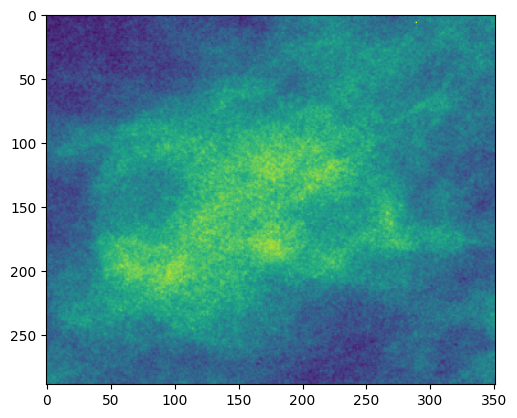

In [ ]:
os.path.isfile(cropped_images.iloc[0])
img = PIL.Image.open(cropped_images.iloc[0])
plt.imshow(img)

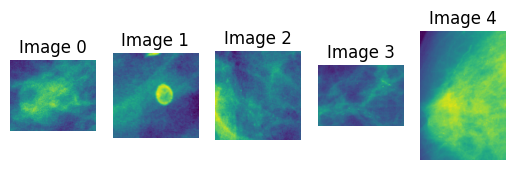

In [ ]:
for i, name in enumerate(cropped_images[0:5]):
  plt.subplot(1, 5, i+1)
  plt.imshow(PIL.Image.open(name))
  plt.axis('off')  # Hide the axis labels
  plt.title("Image "+str(i))

plt.show()

Vizualindo as imagens inteiras

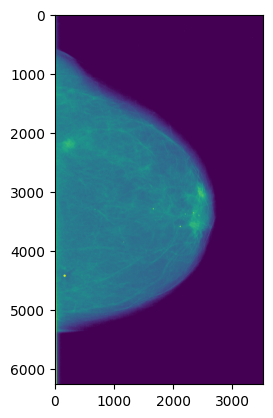

In [ ]:
temp = full_mammogram_images.iloc[0]
image_show = PIL.Image.open(temp)
plt.imshow(image_show)

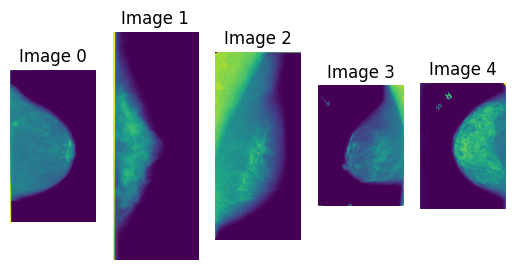

In [ ]:
for i, name in enumerate(full_mammogram_images[0:5]):
  plt.subplot(1, 5, i+1)
  plt.imshow(PIL.Image.open(name))
  plt.axis('off')  # Hide the axis labels
  plt.title("Image "+str(i))

plt.show()

Vizualizando as mascaras ROI

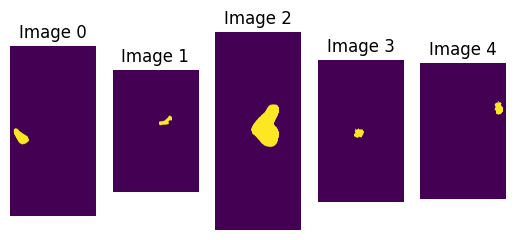

In [ ]:
for i, name in enumerate(ROI_mask_images[0:5]):
  plt.subplot(1, 5, i+1)
  plt.imshow(PIL.Image.open(name))
  plt.axis('off')  # Hide the axis labels
  plt.title("Image "+str(i))

plt.show()

Quantas imagens de cada

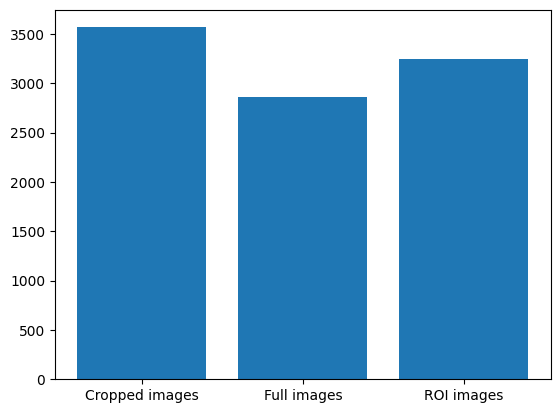

In [ ]:
x = np.array(["Cropped images", "Full images", "ROI images"])
y = np.array([len(cropped_images), len(full_mammogram_images), len(ROI_mask_images)])

plt.bar(x,y)
plt.show()

##Mass/calc data

In [ ]:
len(dicom_data)

10237

In [ ]:
len(calc_train)+len(calc_test)+ len(mass_train)+len(mass_test)

3568

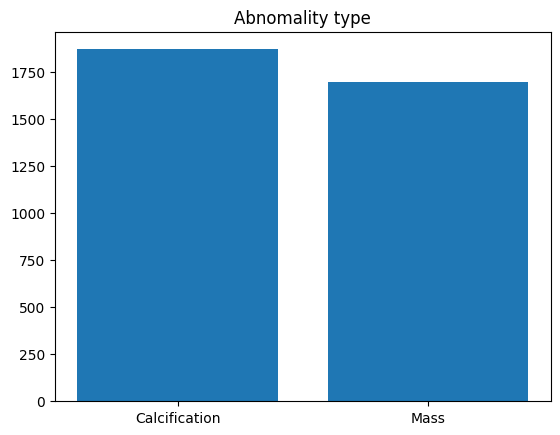

In [ ]:
x = np.array(["Calcification", "Mass"])
y = np.array([len(calc_train)+len(calc_test), len(mass_train)+len(mass_test)])

plt.bar(x,y)
plt.title('Abnomality type distribution')
plt.show()

In [ ]:
"""#plot inutil, juntei tudo depois e redistriui
data1 = mass_train['pathology'].value_counts() + calc_train['pathology'].value_counts() + calc_test['pathology'].value_counts()+mass_test['pathology'].value_counts()
data2 =mass_train['pathology'].value_counts() + calc_train['pathology'].value_counts()
data3 = mass_test['pathology'].value_counts() + calc_test['pathology'].value_counts()


fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))


ax1.pie(data1,labels=data1.index, autopct='%1.1f%%')
ax1.set_title('Full Data')
ax2.pie(data2,labels=data2.index, autopct='%1.1f%%')
ax2.set_title('Training Data')
ax3.pie(data3,labels=data3.index, autopct='%1.1f%%')
ax3.set_title('Testing Data')
plt.show()"""

"#plot inutil, juntei tudo depois e redistriui\ndata1 = mass_train['pathology'].value_counts() + calc_train['pathology'].value_counts() + calc_test['pathology'].value_counts()+mass_test['pathology'].value_counts()\ndata2 =mass_train['pathology'].value_counts() + calc_train['pathology'].value_counts()\ndata3 = mass_test['pathology'].value_counts() + calc_test['pathology'].value_counts()\n\n\nfig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 5))\n\n\nax1.pie(data1,labels=data1.index, autopct='%1.1f%%')\nax1.set_title('Full Data')\nax2.pie(data2,labels=data2.index, autopct='%1.1f%%')\nax2.set_title('Training Data')\nax3.pie(data3,labels=data3.index, autopct='%1.1f%%')\nax3.set_title('Testing Data')\nplt.show()"

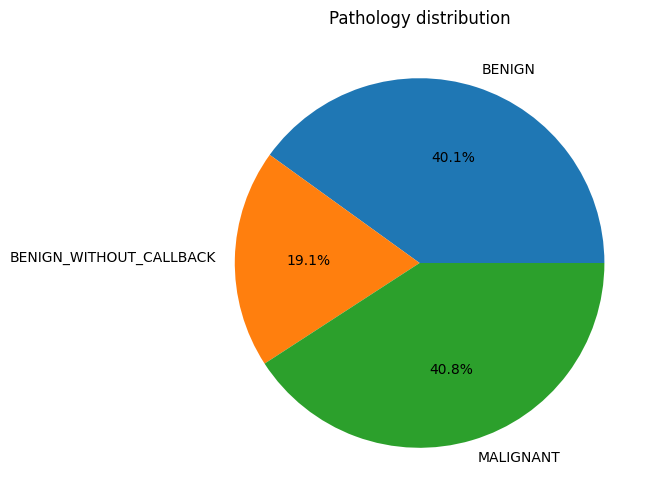

In [ ]:
# pathology distributions
value = mass_train['pathology'].value_counts() + calc_train['pathology'].value_counts() + calc_test['pathology'].value_counts()+mass_test['pathology'].value_counts()
plt.figure(figsize=(8,6))

plt.pie(value, labels=value.index, autopct='%1.1f%%')
plt.title('Pathology distribution', fontsize=12)
plt.show()

mass type

(PIL.JpegImagePlugin.JpegImageFile, (3024, 4808))

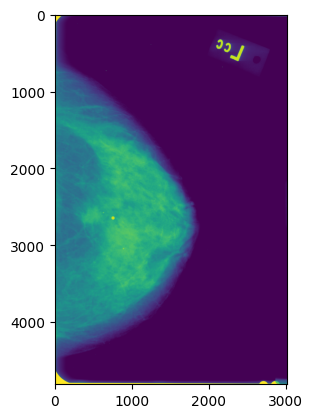

In [ ]:
temp = mass_train.loc[0]['image_file_path']
image = PIL.Image.open(temp)
plt.imshow(image)

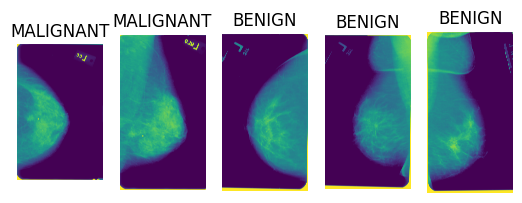

In [ ]:
for i, name in mass_train[['image_file_path','pathology']][0:5].iterrows():
  plt.subplot(1, 5, i+1)
  plt.imshow(PIL.Image.open(name['image_file_path']))
  plt.axis('off')  # Hide the axis labels
  plt.title(name['pathology'])

plt.show()

calcification type

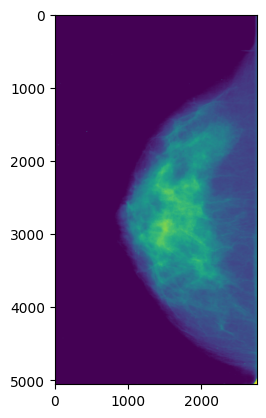

In [ ]:
temp = calc_train.iloc[0]['image_file_path']
image = PIL.Image.open(temp)

plt.imshow(image)

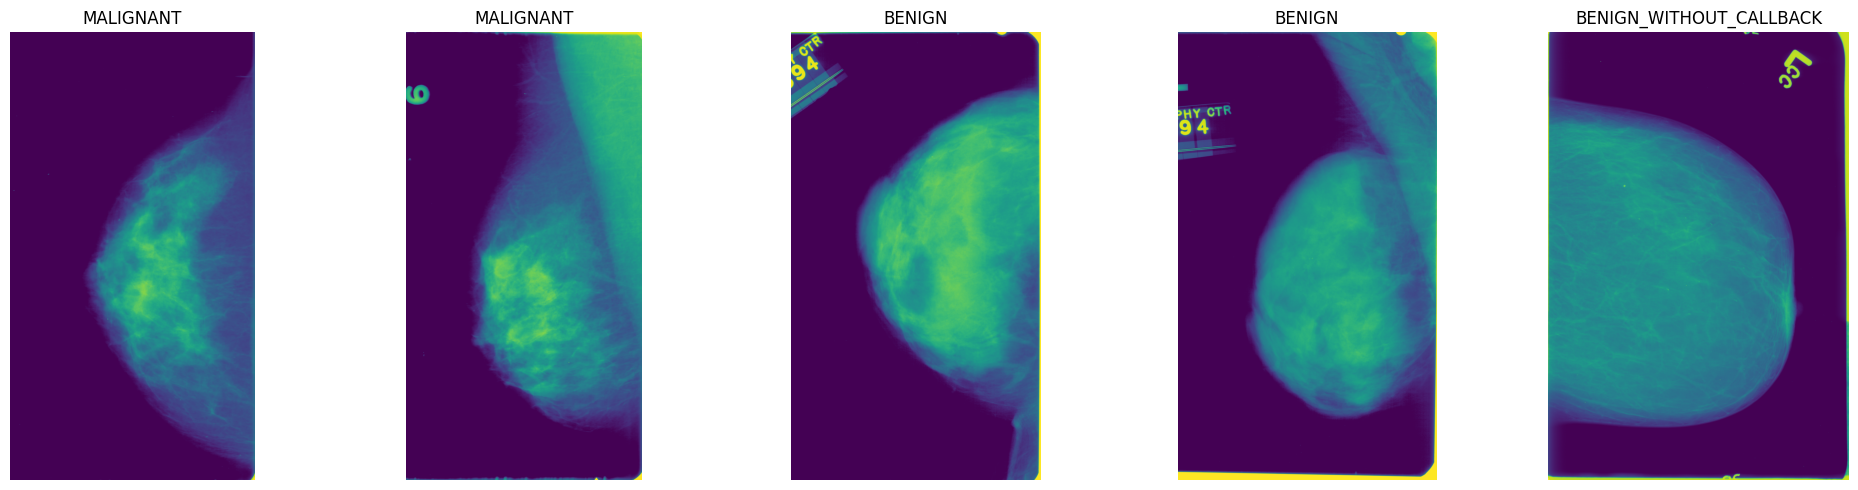

In [ ]:
plt.figure(figsize=(20, 5))
for i, name in calc_train[['image_file_path','pathology']][0:5].iterrows():
  plt.subplot(1, 5, i+1)
  plt.imshow(PIL.Image.open(name['image_file_path']))
  plt.axis('off')
  plt.title(name['pathology'])
plt.tight_layout()
plt.show()

# Data pre-processing

In [ ]:
# Merge datasets
mass_calc = pd.concat([mass_train, mass_test, calc_train, calc_test], axis=0)
#mass_calc = mass_calc.sample(frac=0.6)
# Define the target size
target_size = (224, 224, 3)

In [ ]:
len(mass_calc)

3568

In [ ]:
import os
from PIL import Image
import numpy as np
import torch
from torchvision import transforms
counter =0
def image_processor(image_path, target_size, base_directory=image_dir):
    """Preprocess images for Inception V3 model with Gaussian filter and CLAHE in PyTorch"""
    global counter
    counter += 1
    # Check if a GPU is available
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if counter % 100 == 0:
        print(f"Processing image {counter}...")
        if device.type == 'cuda':
            print("GPU found. Using GPU for image processing.")
        else:
            print("Warning: No GPU devices found. Using CPU.")

    absolute_image_path = os.path.abspath(image_path)

    # Counter for skipped and processed images
    skipped_count = 0
    processed_count = 0

    # Check if the image path starts with the specified directory
    if not absolute_image_path.startswith(base_directory):
        skipped_count += 1
        return None, skipped_count, processed_count

    # Open the image using PIL
    try:
        image = Image.open(absolute_image_path).convert("RGB")
    except Exception as e:
        print(f"Error opening image {image_path}: {e}")
        skipped_count += 1
        return None, skipped_count, processed_count

    # Define the transformation pipeline (resize, normalize, and apply CLAHE if needed)
    transform = transforms.Compose([
        transforms.Resize(target_size),
        transforms.ToTensor(),  # Converts image to tensor and normalizes to [0, 1]
    ])
    image_tensor = transform(image).unsqueeze(0)  # Add batch dimension
    image_tensor = image_tensor.to(device)
    # Image normalization to the range [0, 1] (done by ToTensor())
    image_array = image_tensor.cpu().numpy()  # Move back to CPU and convert to NumPy array

    processed_count += 1

    return image_array, skipped_count, processed_count


In [ ]:
# Apply preprocessor to train data
result = mass_calc['image_file_path'].apply(lambda x: pd.Series(image_processor(x, target_size[0:2]), index=['image_array', 'skipped_count', 'processed_count']))

# Extract processed images, skipped count, and processed count from the result
mass_calc[['processed_images', 'skipped_count', 'processed_count']] = result

# Filter out rows where processed_images is None
mass_calc = mass_calc.dropna(subset=['processed_images'])

Processing image 100...
GPU found. Using GPU for image processing.
Processing image 200...
GPU found. Using GPU for image processing.
Processing image 300...
GPU found. Using GPU for image processing.
Processing image 400...
GPU found. Using GPU for image processing.
Processing image 500...
GPU found. Using GPU for image processing.
Processing image 600...
GPU found. Using GPU for image processing.
Processing image 700...
GPU found. Using GPU for image processing.
Processing image 800...
GPU found. Using GPU for image processing.
Processing image 900...
GPU found. Using GPU for image processing.
Processing image 1000...
GPU found. Using GPU for image processing.
Processing image 1100...
GPU found. Using GPU for image processing.
Processing image 1200...
GPU found. Using GPU for image processing.
Processing image 1300...
GPU found. Using GPU for image processing.
Processing image 1400...
GPU found. Using GPU for image processing.
Processing image 1500...
GPU found. Using GPU for image p

In [ ]:
# Convert the processed_images column to an array
X_resized = np.array(mass_calc['processed_images'].tolist())

# Create a binary mapper
class_mapper = {'MALIGNANT': 1, 'BENIGN': 0, 'BENIGN_WITHOUT_CALLBACK': 0}

# Apply class mapper to pathology column
mass_calc['labels'] = mass_calc['pathology'].replace(class_mapper)

# Check the number of classes
num_classes = len(mass_calc['labels'].unique())

<ipython-input-37-a28f08b0aa31>:8: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  mass_calc['labels'] = mass_calc['pathology'].replace(class_mapper)


In [ ]:
mass_calc = mass_calc.dropna(subset=['labels'])

In [ ]:
mass_calc.head()

,patient_id,breast_density,left_or_right_breast,image_view,abnormality_id,abnormality_type,mass_shape,mass_margins,assessment,pathology,subtlety,image_file_path,cropped_image_file_path,ROI_mask_file_path,calc_type,calc_distribution,processed_images,skipped_count,processed_count,labels
0,P_00001,3,LEFT,CC,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,/root/.cache/kagglehub/datasets/awsaf49/cbis-d...,/root/.cache/kagglehub/datasets/awsaf49/cbis-d...,Mass-Training_P_00001_LEFT_CC_1/1.3.6.1.4.1.95...,NaN,NaN,[[[[1. 1. 1. 1. ...,0.0,1.0,1
1,P_00001,3,LEFT,MLO,1,mass,IRREGULAR-ARCHITECTURAL_DISTORTION,SPICULATED,4,MALIGNANT,4,/root/.cache/kagglehub/datasets/awsaf49/cbis-d...,/root/.cache/kagglehub/datasets/awsaf49/cbis-d...,Mass-Training_P_00001_LEFT_MLO_1/1.3.6.1.4.1.9...,NaN,NaN,[[[[1. 0.99607843 0.9529412 0.8745098...,0.0,1.0,1
2,P_00004,3,LEFT,CC,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,/root/.cache/kagglehub/datasets/awsaf49/cbis-d...,/root/.cache/kagglehub/datasets/awsaf49/cbis-d...,Mass-Training_P_00004_LEFT_CC_1/1.3.6.1.4.1.95...,NaN,NaN,[[[[0.89411765 0.89411765 0.8901961 0.8901961...,0.0,1.0,0
3,P_00004,3,LEFT,MLO,1,mass,ARCHITECTURAL_DISTORTION,ILL_DEFINED,4,BENIGN,3,/root/.cache/kagglehub/datasets/awsaf49/cbis-d...,/root/.cache/kagglehub/datasets/awsaf49/cbis-d...,Mass-Training_P_00004_LEFT_MLO_1/1.3.6.1.4.1.9...,NaN,NaN,[[[[0.7490196 0.7490196 0.74509805 0.7450980...,0.0,1.0,0
4,P_00004,3,RIGHT,MLO,1,mass,OVAL,CIRCUMSCRIBED,4,BENIGN,5,/root/.cache/kagglehub/datasets/awsaf49/cbis-d...,/root/.cache/kagglehub/datasets/awsaf49/cbis-d...,Mass-Training_P_00004_RIGHT_MLO_1/1.3.6.1.4.1....,NaN,NaN,[[[[1. 1. 1. 1. ...,0.0,1.0,0


In [ ]:
#X_resized = X_resized[mass_calc.index]

# set train/val/test

In [ ]:
# Split data into train, test, and validation sets (70, 20, 10)
# X_train, X_temp, y_train, y_temp = train_test_split(X_resized, mass_calc['labels'].values, test_size=0.2, random_state=42)
X_train, X_temp, y_train, y_temp = train_test_split(X_resized, mass_calc['labels'].values, test_size=0.3, random_state=42)
X_test, X_val, y_test, y_val = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

# Convert integer labels to one-hot encoded labels
y_train = to_categorical(y_train, num_classes)
y_test = to_categorical(y_test, num_classes)
y_val = to_categorical(y_val, num_classes)
del X_temp, y_temp,X_resized,result,mass_calc

In [ ]:
"""np.save('X_train',X_train)
np.save('X_test',X_test)
np.save('X_val',X_val)
np.save('y_train',y_train)
np.save('y_test',y_test)
np.save('y_val',y_val)
"""
#X_train = np.load('X_train.npy')
#X_test = np.load('X_test.npy')
#X_val = np.load('X_val.npy')
#y_train = np.load('y_train.npy')
#y_test = np.load('y_test.npy')
#y_val = np.load('y_val.npy')

"np.save('X_train',X_train)\nnp.save('X_test',X_test)\nnp.save('X_val',X_val)\nnp.save('y_train',y_train)\nnp.save('y_test',y_test)\nnp.save('y_val',y_val)\n"

In [ ]:
# Number of images in each set
num_train_images = X_train.shape[0]
num_test_images = X_test.shape[0]
num_val_images = X_val.shape[0]

print("Number of images in the training set:", num_train_images)
print("Number of images in the testing set:", num_test_images)
print("Number of images in the validation set:", num_val_images)

Number of images in the training set: 2300
Number of images in the testing set: 493
Number of images in the validation set: 493


#Data augmentation

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# SEM CROPPING !!!!!!
transforms = T.Compose([
    T.ColorJitter(brightness=(0.5,1.2),contrast=(0.8,1.2),saturation=(0.8,1.2),hue=(-0.1,0.1)),
    T.RandomHorizontalFlip(),  # Flip horizontal aleatório
    T.RandomRotation(15),  # Rotação aleatória entre -20 e 20 graus
    #T.ToTensor()  # Converte a imagem para tensor (já na forma [C, H, W])
])
def addnoise(input_image, noise_factor = 0.3): # não esta sendo usado
    inputs = T.ToTensor()(input_image)
    noise = inputs + torch.rand_like(inputs) * noise_factor
    noise = torch.clip (noise,0,1.)
    output_image = T.ToPILImage()
    image = output_image(noise)
    return image

#jitter= T.ColorJitter(brightness=(0.5,1.5),contrast=(3),saturation=(0.3,1.5),hue=(-0.1,0.1))

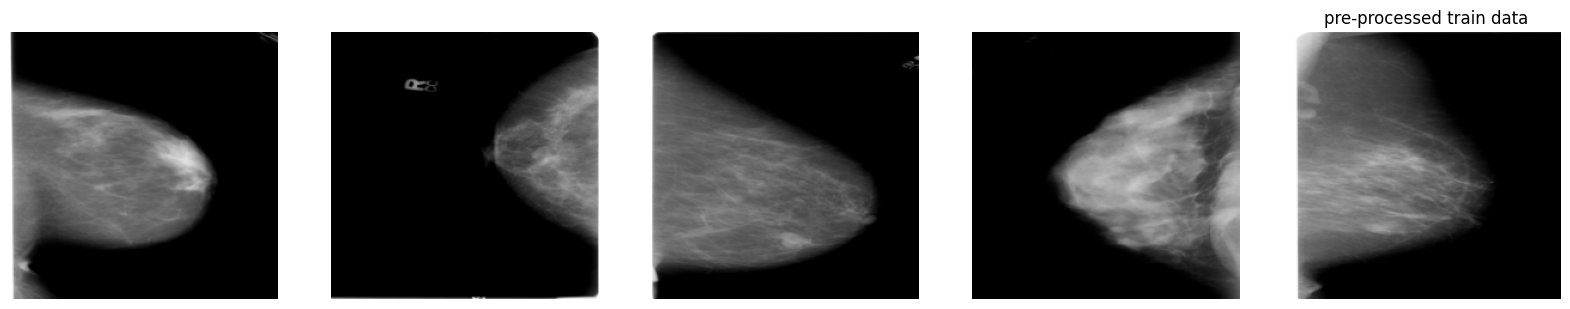

In [ ]:
plt.figure(figsize=(20, 5))
for i, row in enumerate(X_train[5:10]):
  plt.subplot(1, 5, i+1)
  plt.imshow(row[0].transpose(1, 2, 0))
  plt.axis('off')  # Hide the axis labels
plt.title('pre-processed train data')

plt.show()

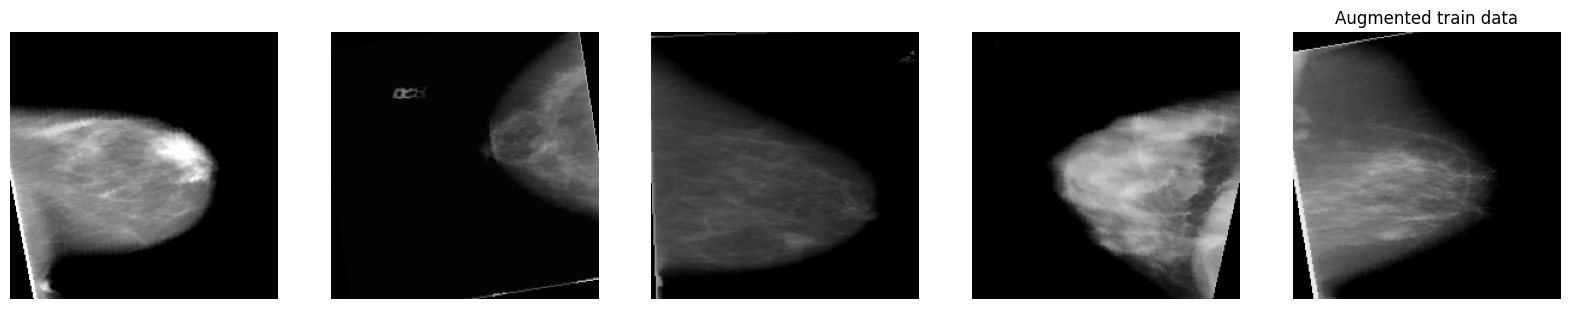

In [ ]:
plt.figure(figsize=(20, 5))
for i, row in enumerate(X_train[5:10]):
  plt.subplot(1, 5, i+1)
  temp =torch.from_numpy(row[0])
  temp = transforms(temp)
  temp = torch.Tensor.numpy(temp).transpose(1, 2, 0)
  plt.imshow(temp)
  plt.axis('off')  # Hide the axis labels

plt.title('Augmented train data')

plt.show()

In [ ]:
def generate_aug_data(train_X,train_y):
  train_X = train_X.squeeze(1)
  # Aplicar as transformações às imagens de X_train
  X_train_augmented = torch.stack([transforms(torch.from_numpy(img)) for img in train_X])

  # Concatenar os dados originais com os aumentados
  X_train_final = torch.cat((torch.tensor(train_X), X_train_augmented), dim=0)
  y_train_final = torch.cat((torch.tensor(train_y), torch.tensor(train_y)), dim=0)  # Duplicamos os labels
 # indices = torch.randperm(X_train_final.shape[0])

  # Aplicar o shuffle nos dados e nos rótulos
  #X_train_final = X_train_final[indices]
  #y_train_final = y_train_final[indices]
  return X_train_final,y_train_final

In [ ]:
x_val_aug, y_val_aug = generate_aug_data(X_val,y_val)
x_train_aug,y_train_aug = generate_aug_data(X_train,y_train)
del X_val,y_val,X_train,y_train

#modeling

In [ ]:
len(y_val_aug)+len(y_test)+len(y_train_aug)

6079

In [ ]:
X_test= torch.stack([torch.from_numpy(img) for img in X_test])
y_test= torch.stack([torch.from_numpy(img) for img in y_test])


In [ ]:
torch.save(x_train_aug, "x_train_aug2.pt")
torch.save(y_train_aug, "y_train_aug2.pt")
torch.save(x_val_aug, "x_val_aug2.pt")
torch.save(y_val_aug, "y_val_aug2.pt")
torch.save(X_test, "X_test.pt")
torch.save(y_test, "y_test.pt")

In [ ]:
x_train_aug = torch.load("x_train_aug2.pt")
y_train_aug = torch.load("y_train_aug2.pt")
x_val_aug = torch.load("x_val_aug2.pt")
y_val_aug = torch.load("y_val_aug2.pt")
X_test = torch.load("X_test.pt")
y_test = torch.load("y_test.pt")

In [ ]:
torch.manual_seed(0)
torch.cuda.manual_seed(42)
random.seed(42)
np.random.seed(42)
batch_size = 256

# Converter numpy arrays para tensores
X_train_tensor = torch.tensor(x_train_aug, dtype=torch.float32)
y_train_tensor = torch.tensor(np.argmax(y_train_aug, axis=1), dtype=torch.long)  # Converte one-hot para rótulos

X_val_tensor = torch.tensor(x_val_aug, dtype=torch.float32)
y_val_tensor = torch.tensor(np.argmax(y_val_aug, axis=1), dtype=torch.long)  # Converte one-hot para rótulos

# Criar datasets e DataLoaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
#del x_train_aug,y_train_aug,x_val_aug,y_val_aug

<ipython-input-51-0e1785de683a>:8: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_train_tensor = torch.tensor(x_train_aug, dtype=torch.float32)
<ipython-input-51-0e1785de683a>:9: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(np.argmax(y_train_aug, axis=1), dtype=torch.long)  # Converte one-hot para rótulos
<ipython-input-51-0e1785de683a>:11: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_val_tensor = torch.tensor(x_val_aug, dtype=torch.float32)
<ipython-input-51-0e1785de683a>:12: UserWarning: To copy constr

In [ ]:
def plot_training_history(history):
    """
    Plota as curvas de loss e acurácia para treino e validação.
    """
    epochs = range(1, len(history["train_loss"]) + 1)

    # Plot da Loss
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history["train_loss"], label="Treino", marker=',')
    plt.plot(epochs, history["val_loss"], label="Validação", marker=',')
    plt.xlabel("Época")
    plt.ylabel("Loss")
    plt.title("Curva de Loss")
    plt.legend()
    plt.grid()

    # Plot da Acurácia
    plt.subplot(1, 2, 2)
    plt.plot(epochs, history["train_acc"], label="Treino", marker=',')
    plt.plot(epochs, history["val_acc"], label="Validação", marker=',')
    plt.xlabel("Época")
    plt.ylabel("Acurácia")
    plt.title("Curva de Acurácia")
    plt.legend()
    plt.grid()

    plt.show()


def evaluate_model_sklearn(model, data_loader):
    """
    Avalia o modelo e imprime um relatório com acurácia, precisão, recall e F1-score para cada classe.
    """
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for inputs, labels in data_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)

            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    # Gerar relatório completo
    report = classification_report(all_labels, all_preds, target_names=["Classe 0", "Classe 1"])
    cm = confusion_matrix(all_labels, all_preds)
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Classe 0", "Classe 1"], yticklabels=["Classe 0", "Classe 1"])
    plt.xlabel("Predito")
    plt.ylabel("Verdadeiro")
    plt.title("Matriz de Confusão")
    plt.show()
    print(report)


# experimentos

##alexnet




In [ ]:
class CancerDetectionAlexNet(nn.Module):
    def __init__(self, num_classes=2, freeze_features=True,train_last_n=1,drop=0.5):
        super(CancerDetectionAlexNet, self).__init__()

        # Carregar VGG11 pré-treinada
        self.model =  M.alexnet(pretrained=True,dropout=drop)

        # Congelar camadas convolucionais, se necessário
        total_layers = sum(1 for p in self.model.parameters())
        i=0
        for param in self.model.parameters():
            if  total_layers - train_last_n > i:
               param.requires_grad = False
            i+=1
        # Substituir a última camada para saída binária
        self.model.classifier[6] = nn.Linear(in_features=4096, out_features=num_classes)
        self.out= torch.nn.Softmax()
    def forward(self, x):
        output = self.model(x)
        output = self.out(output)
        return output

    def train_model(self, train_loader, val_loader, num_epochs=10, lr=0.001,early_stop=15, min_delta=0.01,optim_alg='adam',wd=0):
        """
        Treina o modelo e retorna o histórico de loss e acurácia.
        """
        criterion = nn.CrossEntropyLoss()
        if optim_alg == 'adam':
            optimizer = optim.Adam(self.model.features.parameters(), lr=lr, weight_decay=wd)
        elif optim_alg == 'sgd':
            optimizer = optim.Adam(self.model.features.parameters(), lr=lr, weight_decay=wd)
        elif optim_alg == 'adagrad':
            optimizer = optim.Adam(self.model.features.parameters(), lr=lr, weight_decay=wd)
        elif optim_alg == 'rmsprop':
            optimizer = optim.Adam(self.model.features.parameters(), lr=lr, weight_decay=wd)


        self.to(device)
        history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
        best_val_loss = float("inf")
        patience = 0
        best_val_acc = 0.0
        best_model_state = None
        for epoch in range(num_epochs):
            self.train()
            train_loss, correct, total = 0, 0, 0
            first = True
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = self(inputs)
                """if first:
                    first=False
                    print(outputs[0:10],labels[0:10])"""
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

            train_loss /= len(train_loader)
            train_acc = correct / total

            # Validação
            self.eval()
            val_loss, correct, total = 0, 0, 0

            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = self(inputs)

                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    correct += (predicted == labels).sum().item()
                    total += labels.size(0)

            val_loss /= len(val_loader)
            val_acc = correct / total

            # Salvar histórico
            history["train_loss"].append(train_loss)
            history["val_loss"].append(val_loss)
            history["train_acc"].append(train_acc)
            history["val_acc"].append(val_acc)

            print(f"Epoch [{epoch+1}/{num_epochs}] - "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
                    # Early stopping com min_delta
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model_state = self.state_dict()  # Armazena os melhores pesos
                print(f"✅ Novo melhor modelo salvo! Val Acc: {best_val_acc:.4f}")
            if val_loss < best_val_loss - min_delta:
                best_val_loss = val_loss
                patience = 0  # Reset patience
            else:
                patience += 1

            if patience >= early_stop:
                print(f"Early stopping triggered at epoch {epoch+1}.")
                break
            elif patience % 5 == 0 and patience > 0:
                 optimizer.param_groups[0]['lr'] /=2
                 print('reduziu')
        if best_model_state:
            self.load_state_dict(best_model_state)
            print("✅ Melhor modelo carregado como estado final!")
        return history

    def save_model(self, file_path="cancer_vgg11.pth"):
        torch.save(self.state_dict(), file_path)
        print(f"Modelo salvo em {file_path}")

    def load_model(self, file_path="cancer_vgg11.pth"):
        self.load_state_dict(torch.load(file_path, map_location=device))
        self.to(device)
        print(f"Modelo carregado de {file_path}")


In [ ]:
def objective(trial):
  dropout = trial.suggest_float("dropout", 0.1, 0.6)
  optim_alg = trial.suggest_categorical("optimizer", ["adam", "sgd","adagrad","rmsprop"])
  lr = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
  n_freezed = trial.suggest_int('n_freezed_layes',1,10)
  wd =  trial.suggest_float('weight_decay', 1e-4, 5*1e-2)
  model = CancerDetectionAlexNet(train_last_n=n_freezed,drop=dropout)
  history = model.train_model(train_loader, val_loader, num_epochs=25, lr=lr,wd=wd,optim_alg=optim_alg)
  return max(history['val_acc'])

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=25)
print("Best params: ", study.best_params)
print("Best value: ", study.best_value)
print("Best Trial: ", study.best_trial)
print("Trials: ", study.trials)

[I 2025-03-25 00:54:26,428] A new study created in memory with name: no-name-04e3956c-f5b2-4225-b054-efde6767e76a
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch [1/25] - Train Loss: 0.6823, Train Acc: 0.5754 - Val Loss: 0.6808, Val Acc: 0.5720
✅ Novo melhor modelo salvo! Val Acc: 0.5720
Epoch [2/25] - Train Loss: 0.6806, Train Acc: 0.5700 - Val Loss: 0.6808, Val Acc: 0.5720
Epoch [3/25] - Train Loss: 0.6811, Train Acc: 0.5807 - Val Loss: 0.6808, Val Acc: 0.5720
Epoch [4/25] - Train Loss: 0.6827, Train Acc: 0.5696 - Val Loss: 0.6808, Val Acc: 0.5720
Epoch [5/25] - Train Loss: 0.6824, Train Acc: 0.5713 - Val Loss: 0.6808, Val Acc: 0.5720
Epoch [6/25] - Train Loss: 0.6835, Train Acc: 0.5639 - Val Loss: 0.6808, Val Acc: 0.5720
reduziu
Epoch [7/25] - Train Loss: 0.6802, Train Acc: 0.5815 - Val Loss: 0.6808, Val Acc: 0.5720
Epoch [8/25] - Train Loss: 0.6833, Train Acc: 0.5739 - Val Loss: 0.6808, Val Acc: 0.5720
Epoch [9/25] - Train Loss: 0.6822, Train Acc: 0.5728 - Val Loss: 0.6808, Val Acc: 0.5720
Epoch [10/25] - Train Loss: 0.6837, Train Acc: 0.5698 - Val Loss: 0.6808, Val Acc: 0.5720
Epoch [11/25] - Train Loss: 0.6819, Train Acc: 0.5741 - V

[I 2025-03-25 00:54:49,741] Trial 0 finished with value: 0.5720081135902637 and parameters: {'dropout': 0.5656761812800999, 'optimizer': 'sgd', 'learning_rate': 0.009608647117714648, 'n_freezed_layes': 2, 'weight_decay': 0.017680870986926816}. Best is trial 0 with value: 0.5720081135902637.


Epoch [16/25] - Train Loss: 0.6828, Train Acc: 0.5691 - Val Loss: 0.6808, Val Acc: 0.5720
Early stopping triggered at epoch 16.
✅ Melhor modelo carregado como estado final!
Epoch [1/25] - Train Loss: 0.6796, Train Acc: 0.5850 - Val Loss: 0.6836, Val Acc: 0.5710
✅ Novo melhor modelo salvo! Val Acc: 0.5710
Epoch [2/25] - Train Loss: 0.6791, Train Acc: 0.5793 - Val Loss: 0.6836, Val Acc: 0.5710
Epoch [3/25] - Train Loss: 0.6797, Train Acc: 0.5828 - Val Loss: 0.6836, Val Acc: 0.5710
Epoch [4/25] - Train Loss: 0.6803, Train Acc: 0.5833 - Val Loss: 0.6836, Val Acc: 0.5710
Epoch [5/25] - Train Loss: 0.6786, Train Acc: 0.5876 - Val Loss: 0.6836, Val Acc: 0.5710
Epoch [6/25] - Train Loss: 0.6791, Train Acc: 0.5848 - Val Loss: 0.6836, Val Acc: 0.5710
reduziu
Epoch [7/25] - Train Loss: 0.6798, Train Acc: 0.5887 - Val Loss: 0.6836, Val Acc: 0.5710
Epoch [8/25] - Train Loss: 0.6794, Train Acc: 0.5815 - Val Loss: 0.6836, Val Acc: 0.5710
Epoch [9/25] - Train Loss: 0.6785, Train Acc: 0.5841 - Val Loss

[I 2025-03-25 00:55:18,363] Trial 1 finished with value: 0.5709939148073022 and parameters: {'dropout': 0.3195766521637722, 'optimizer': 'sgd', 'learning_rate': 0.0003029846850882194, 'n_freezed_layes': 5, 'weight_decay': 0.041971458688151594}. Best is trial 0 with value: 0.5720081135902637.


Epoch [16/25] - Train Loss: 0.6790, Train Acc: 0.5872 - Val Loss: 0.6836, Val Acc: 0.5710
Early stopping triggered at epoch 16.
✅ Melhor modelo carregado como estado final!
Epoch [1/25] - Train Loss: 0.6974, Train Acc: 0.5185 - Val Loss: 0.6948, Val Acc: 0.5010
✅ Novo melhor modelo salvo! Val Acc: 0.5010
Epoch [2/25] - Train Loss: 0.6956, Train Acc: 0.5243 - Val Loss: 0.6948, Val Acc: 0.5010
Epoch [3/25] - Train Loss: 0.6959, Train Acc: 0.5270 - Val Loss: 0.6948, Val Acc: 0.5010
Epoch [4/25] - Train Loss: 0.6981, Train Acc: 0.5139 - Val Loss: 0.6948, Val Acc: 0.5010
Epoch [5/25] - Train Loss: 0.6986, Train Acc: 0.5089 - Val Loss: 0.6948, Val Acc: 0.5010
Epoch [6/25] - Train Loss: 0.6971, Train Acc: 0.5250 - Val Loss: 0.6948, Val Acc: 0.5010
reduziu
Epoch [7/25] - Train Loss: 0.6966, Train Acc: 0.5187 - Val Loss: 0.6948, Val Acc: 0.5010
Epoch [8/25] - Train Loss: 0.6969, Train Acc: 0.5185 - Val Loss: 0.6948, Val Acc: 0.5010
Epoch [9/25] - Train Loss: 0.6995, Train Acc: 0.5111 - Val Loss

[I 2025-03-25 00:55:46,335] Trial 2 finished with value: 0.5010141987829615 and parameters: {'dropout': 0.532894967063618, 'optimizer': 'adam', 'learning_rate': 0.0007443110754967567, 'n_freezed_layes': 2, 'weight_decay': 0.0110988165412437}. Best is trial 0 with value: 0.5720081135902637.


Epoch [16/25] - Train Loss: 0.6988, Train Acc: 0.5143 - Val Loss: 0.6948, Val Acc: 0.5010
Early stopping triggered at epoch 16.
✅ Melhor modelo carregado como estado final!
Epoch [1/25] - Train Loss: 0.6823, Train Acc: 0.5657 - Val Loss: 0.6747, Val Acc: 0.5730
✅ Novo melhor modelo salvo! Val Acc: 0.5730
Epoch [2/25] - Train Loss: 0.6628, Train Acc: 0.6026 - Val Loss: 0.6695, Val Acc: 0.5730
Epoch [3/25] - Train Loss: 0.6536, Train Acc: 0.6009 - Val Loss: 0.6558, Val Acc: 0.5913
✅ Novo melhor modelo salvo! Val Acc: 0.5913
Epoch [4/25] - Train Loss: 0.6456, Train Acc: 0.6230 - Val Loss: 0.6499, Val Acc: 0.6166
✅ Novo melhor modelo salvo! Val Acc: 0.6166
Epoch [5/25] - Train Loss: 0.6369, Train Acc: 0.6337 - Val Loss: 0.6452, Val Acc: 0.6146
Epoch [6/25] - Train Loss: 0.6361, Train Acc: 0.6459 - Val Loss: 0.6409, Val Acc: 0.6207
✅ Novo melhor modelo salvo! Val Acc: 0.6207
Epoch [7/25] - Train Loss: 0.6274, Train Acc: 0.6522 - Val Loss: 0.6390, Val Acc: 0.6197
Epoch [8/25] - Train Loss: 0

[I 2025-03-25 00:56:35,321] Trial 3 finished with value: 0.6643002028397565 and parameters: {'dropout': 0.2441213801794713, 'optimizer': 'rmsprop', 'learning_rate': 0.0002164834014236488, 'n_freezed_layes': 8, 'weight_decay': 0.0061154798483593845}. Best is trial 3 with value: 0.6643002028397565.


Epoch [25/25] - Train Loss: 0.5975, Train Acc: 0.7063 - Val Loss: 0.6263, Val Acc: 0.6410
Early stopping triggered at epoch 25.
✅ Melhor modelo carregado como estado final!
Epoch [1/25] - Train Loss: 0.6678, Train Acc: 0.5904 - Val Loss: 0.6618, Val Acc: 0.5751
✅ Novo melhor modelo salvo! Val Acc: 0.5751
Epoch [2/25] - Train Loss: 0.6479, Train Acc: 0.6135 - Val Loss: 0.6544, Val Acc: 0.5801
✅ Novo melhor modelo salvo! Val Acc: 0.5801
Epoch [3/25] - Train Loss: 0.6364, Train Acc: 0.6352 - Val Loss: 0.6467, Val Acc: 0.6420
✅ Novo melhor modelo salvo! Val Acc: 0.6420
Epoch [4/25] - Train Loss: 0.6300, Train Acc: 0.6420 - Val Loss: 0.6404, Val Acc: 0.6166
Epoch [5/25] - Train Loss: 0.6225, Train Acc: 0.6596 - Val Loss: 0.6354, Val Acc: 0.6552
✅ Novo melhor modelo salvo! Val Acc: 0.6552
Epoch [6/25] - Train Loss: 0.6211, Train Acc: 0.6598 - Val Loss: 0.6473, Val Acc: 0.6318
Epoch [7/25] - Train Loss: 0.6190, Train Acc: 0.6683 - Val Loss: 0.6360, Val Acc: 0.6268
Epoch [8/25] - Train Loss: 0

[I 2025-03-25 00:57:15,016] Trial 4 finished with value: 0.6683569979716024 and parameters: {'dropout': 0.33635029512004566, 'optimizer': 'adam', 'learning_rate': 0.00022571144099663225, 'n_freezed_layes': 10, 'weight_decay': 0.011650025207899949}. Best is trial 4 with value: 0.6683569979716024.


Epoch [20/25] - Train Loss: 0.5967, Train Acc: 0.7061 - Val Loss: 0.6296, Val Acc: 0.6531
Early stopping triggered at epoch 20.
✅ Melhor modelo carregado como estado final!
Epoch [1/25] - Train Loss: 0.7031, Train Acc: 0.4802 - Val Loss: 0.7060, Val Acc: 0.4503
✅ Novo melhor modelo salvo! Val Acc: 0.4503
Epoch [2/25] - Train Loss: 0.7039, Train Acc: 0.4848 - Val Loss: 0.7060, Val Acc: 0.4503
Epoch [3/25] - Train Loss: 0.7041, Train Acc: 0.4772 - Val Loss: 0.7060, Val Acc: 0.4503
Epoch [4/25] - Train Loss: 0.7040, Train Acc: 0.4809 - Val Loss: 0.7060, Val Acc: 0.4503
Epoch [5/25] - Train Loss: 0.7043, Train Acc: 0.4754 - Val Loss: 0.7060, Val Acc: 0.4503
Epoch [6/25] - Train Loss: 0.7035, Train Acc: 0.4752 - Val Loss: 0.7060, Val Acc: 0.4503
reduziu
Epoch [7/25] - Train Loss: 0.7038, Train Acc: 0.4859 - Val Loss: 0.7060, Val Acc: 0.4503
Epoch [8/25] - Train Loss: 0.7039, Train Acc: 0.4809 - Val Loss: 0.7060, Val Acc: 0.4503
Epoch [9/25] - Train Loss: 0.7037, Train Acc: 0.4761 - Val Loss

[I 2025-03-25 00:57:45,268] Trial 5 finished with value: 0.45030425963488846 and parameters: {'dropout': 0.5682542086294976, 'optimizer': 'sgd', 'learning_rate': 0.0013382855625134892, 'n_freezed_layes': 3, 'weight_decay': 0.006520402598180334}. Best is trial 4 with value: 0.6683569979716024.


Epoch [16/25] - Train Loss: 0.7031, Train Acc: 0.4815 - Val Loss: 0.7060, Val Acc: 0.4503
Early stopping triggered at epoch 16.
✅ Melhor modelo carregado como estado final!
Epoch [1/25] - Train Loss: 0.6795, Train Acc: 0.5893 - Val Loss: 0.6840, Val Acc: 0.5751
✅ Novo melhor modelo salvo! Val Acc: 0.5751
Epoch [2/25] - Train Loss: 0.6763, Train Acc: 0.5898 - Val Loss: 0.6808, Val Acc: 0.5771
✅ Novo melhor modelo salvo! Val Acc: 0.5771
Epoch [3/25] - Train Loss: 0.6736, Train Acc: 0.5887 - Val Loss: 0.6782, Val Acc: 0.5811
✅ Novo melhor modelo salvo! Val Acc: 0.5811
Epoch [4/25] - Train Loss: 0.6719, Train Acc: 0.5885 - Val Loss: 0.6760, Val Acc: 0.5811
Epoch [5/25] - Train Loss: 0.6699, Train Acc: 0.5880 - Val Loss: 0.6741, Val Acc: 0.5801
Epoch [6/25] - Train Loss: 0.6670, Train Acc: 0.5898 - Val Loss: 0.6726, Val Acc: 0.5811
Epoch [7/25] - Train Loss: 0.6658, Train Acc: 0.5930 - Val Loss: 0.6706, Val Acc: 0.5822
✅ Novo melhor modelo salvo! Val Acc: 0.5822
Epoch [8/25] - Train Loss: 0

[I 2025-03-25 00:58:35,651] Trial 6 finished with value: 0.5821501014198783 and parameters: {'dropout': 0.14017299881088133, 'optimizer': 'adam', 'learning_rate': 1.3337147933154394e-05, 'n_freezed_layes': 10, 'weight_decay': 0.021726576803510214}. Best is trial 4 with value: 0.6683569979716024.


Epoch [25/25] - Train Loss: 0.6514, Train Acc: 0.6137 - Val Loss: 0.6605, Val Acc: 0.5822
✅ Melhor modelo carregado como estado final!
Epoch [1/25] - Train Loss: 0.6654, Train Acc: 0.5946 - Val Loss: 0.6595, Val Acc: 0.5943
✅ Novo melhor modelo salvo! Val Acc: 0.5943
Epoch [2/25] - Train Loss: 0.6489, Train Acc: 0.6196 - Val Loss: 0.6562, Val Acc: 0.5771
Epoch [3/25] - Train Loss: 0.6442, Train Acc: 0.6252 - Val Loss: 0.6491, Val Acc: 0.6349
✅ Novo melhor modelo salvo! Val Acc: 0.6349
Epoch [4/25] - Train Loss: 0.6542, Train Acc: 0.6126 - Val Loss: 0.6642, Val Acc: 0.5771
Epoch [5/25] - Train Loss: 0.6458, Train Acc: 0.6191 - Val Loss: 0.6609, Val Acc: 0.5751
Epoch [6/25] - Train Loss: 0.6426, Train Acc: 0.6252 - Val Loss: 0.6454, Val Acc: 0.6318
Epoch [7/25] - Train Loss: 0.6387, Train Acc: 0.6317 - Val Loss: 0.6445, Val Acc: 0.6329
Epoch [8/25] - Train Loss: 0.6417, Train Acc: 0.6296 - Val Loss: 0.6431, Val Acc: 0.6176
reduziu
Epoch [9/25] - Train Loss: 0.6313, Train Acc: 0.6463 - Va

[I 2025-03-25 00:59:25,953] Trial 7 finished with value: 0.6480730223123732 and parameters: {'dropout': 0.44213785927693317, 'optimizer': 'adam', 'learning_rate': 0.001080526148737595, 'n_freezed_layes': 10, 'weight_decay': 0.015330235102067508}. Best is trial 4 with value: 0.6683569979716024.


Epoch [25/25] - Train Loss: 0.6177, Train Acc: 0.6715 - Val Loss: 0.6382, Val Acc: 0.6420
✅ Melhor modelo carregado como estado final!
Epoch [1/25] - Train Loss: 0.7239, Train Acc: 0.4148 - Val Loss: 0.7190, Val Acc: 0.4310
✅ Novo melhor modelo salvo! Val Acc: 0.4310
Epoch [2/25] - Train Loss: 0.7237, Train Acc: 0.4228 - Val Loss: 0.7190, Val Acc: 0.4310
Epoch [3/25] - Train Loss: 0.7236, Train Acc: 0.4215 - Val Loss: 0.7190, Val Acc: 0.4310
Epoch [4/25] - Train Loss: 0.7243, Train Acc: 0.4185 - Val Loss: 0.7190, Val Acc: 0.4310
Epoch [5/25] - Train Loss: 0.7243, Train Acc: 0.4180 - Val Loss: 0.7190, Val Acc: 0.4310
Epoch [6/25] - Train Loss: 0.7234, Train Acc: 0.4246 - Val Loss: 0.7190, Val Acc: 0.4310
reduziu
Epoch [7/25] - Train Loss: 0.7236, Train Acc: 0.4161 - Val Loss: 0.7190, Val Acc: 0.4310
Epoch [8/25] - Train Loss: 0.7236, Train Acc: 0.4235 - Val Loss: 0.7190, Val Acc: 0.4310
Epoch [9/25] - Train Loss: 0.7246, Train Acc: 0.4178 - Val Loss: 0.7190, Val Acc: 0.4310
Epoch [10/25

[I 2025-03-25 00:59:56,853] Trial 8 finished with value: 0.43103448275862066 and parameters: {'dropout': 0.20687484575420492, 'optimizer': 'adam', 'learning_rate': 0.0013951361270229507, 'n_freezed_layes': 1, 'weight_decay': 0.039066401912491666}. Best is trial 4 with value: 0.6683569979716024.


Epoch [16/25] - Train Loss: 0.7233, Train Acc: 0.4183 - Val Loss: 0.7190, Val Acc: 0.4310
Early stopping triggered at epoch 16.
✅ Melhor modelo carregado como estado final!
Epoch [1/25] - Train Loss: 0.6850, Train Acc: 0.5574 - Val Loss: 0.6895, Val Acc: 0.5487
✅ Novo melhor modelo salvo! Val Acc: 0.5487
Epoch [2/25] - Train Loss: 0.6847, Train Acc: 0.5607 - Val Loss: 0.6895, Val Acc: 0.5487
Epoch [3/25] - Train Loss: 0.6843, Train Acc: 0.5578 - Val Loss: 0.6895, Val Acc: 0.5487
Epoch [4/25] - Train Loss: 0.6849, Train Acc: 0.5596 - Val Loss: 0.6895, Val Acc: 0.5487
Epoch [5/25] - Train Loss: 0.6845, Train Acc: 0.5583 - Val Loss: 0.6895, Val Acc: 0.5487
Epoch [6/25] - Train Loss: 0.6843, Train Acc: 0.5611 - Val Loss: 0.6895, Val Acc: 0.5487
reduziu
Epoch [7/25] - Train Loss: 0.6848, Train Acc: 0.5589 - Val Loss: 0.6895, Val Acc: 0.5487
Epoch [8/25] - Train Loss: 0.6835, Train Acc: 0.5591 - Val Loss: 0.6895, Val Acc: 0.5487
Epoch [9/25] - Train Loss: 0.6851, Train Acc: 0.5585 - Val Loss

[I 2025-03-25 01:00:27,596] Trial 9 finished with value: 0.5486815415821501 and parameters: {'dropout': 0.23178894980620032, 'optimizer': 'adagrad', 'learning_rate': 0.0019232467113008296, 'n_freezed_layes': 4, 'weight_decay': 0.019314102547866897}. Best is trial 4 with value: 0.6683569979716024.


Epoch [16/25] - Train Loss: 0.6844, Train Acc: 0.5589 - Val Loss: 0.6895, Val Acc: 0.5487
Early stopping triggered at epoch 16.
✅ Melhor modelo carregado como estado final!
Epoch [1/25] - Train Loss: 0.7750, Train Acc: 0.4111 - Val Loss: 0.7673, Val Acc: 0.4260
✅ Novo melhor modelo salvo! Val Acc: 0.4260
Epoch [2/25] - Train Loss: 0.7746, Train Acc: 0.4109 - Val Loss: 0.7672, Val Acc: 0.4260
Epoch [3/25] - Train Loss: 0.7752, Train Acc: 0.4098 - Val Loss: 0.7671, Val Acc: 0.4260
Epoch [4/25] - Train Loss: 0.7744, Train Acc: 0.4102 - Val Loss: 0.7670, Val Acc: 0.4260
Epoch [5/25] - Train Loss: 0.7741, Train Acc: 0.4104 - Val Loss: 0.7670, Val Acc: 0.4260
Epoch [6/25] - Train Loss: 0.7748, Train Acc: 0.4104 - Val Loss: 0.7669, Val Acc: 0.4260
reduziu
Epoch [7/25] - Train Loss: 0.7737, Train Acc: 0.4104 - Val Loss: 0.7668, Val Acc: 0.4260
Epoch [8/25] - Train Loss: 0.7739, Train Acc: 0.4096 - Val Loss: 0.7668, Val Acc: 0.4260
Epoch [9/25] - Train Loss: 0.7735, Train Acc: 0.4107 - Val Loss

[I 2025-03-25 01:00:59,429] Trial 10 finished with value: 0.4259634888438134 and parameters: {'dropout': 0.4192068776343692, 'optimizer': 'rmsprop', 'learning_rate': 3.796925362568713e-05, 'n_freezed_layes': 7, 'weight_decay': 0.030970890626897087}. Best is trial 4 with value: 0.6683569979716024.


Epoch [16/25] - Train Loss: 0.7740, Train Acc: 0.4102 - Val Loss: 0.7666, Val Acc: 0.4260
Early stopping triggered at epoch 16.
✅ Melhor modelo carregado como estado final!
Epoch [1/25] - Train Loss: 0.6669, Train Acc: 0.5854 - Val Loss: 0.6659, Val Acc: 0.5781
✅ Novo melhor modelo salvo! Val Acc: 0.5781
Epoch [2/25] - Train Loss: 0.6591, Train Acc: 0.5961 - Val Loss: 0.6572, Val Acc: 0.5822
✅ Novo melhor modelo salvo! Val Acc: 0.5822
Epoch [3/25] - Train Loss: 0.6513, Train Acc: 0.6093 - Val Loss: 0.6530, Val Acc: 0.5862
✅ Novo melhor modelo salvo! Val Acc: 0.5862
Epoch [4/25] - Train Loss: 0.6463, Train Acc: 0.6128 - Val Loss: 0.6484, Val Acc: 0.6034
✅ Novo melhor modelo salvo! Val Acc: 0.6034
Epoch [5/25] - Train Loss: 0.6404, Train Acc: 0.6287 - Val Loss: 0.6454, Val Acc: 0.6166
✅ Novo melhor modelo salvo! Val Acc: 0.6166
Epoch [6/25] - Train Loss: 0.6357, Train Acc: 0.6457 - Val Loss: 0.6434, Val Acc: 0.6258
✅ Novo melhor modelo salvo! Val Acc: 0.6258
Epoch [7/25] - Train Loss: 0.

[I 2025-03-25 01:01:50,063] Trial 11 finished with value: 0.654158215010142 and parameters: {'dropout': 0.31058138295768156, 'optimizer': 'rmsprop', 'learning_rate': 0.00010998015036468675, 'n_freezed_layes': 8, 'weight_decay': 0.00026594681245488763}. Best is trial 4 with value: 0.6683569979716024.


Epoch [25/25] - Train Loss: 0.6024, Train Acc: 0.6965 - Val Loss: 0.6250, Val Acc: 0.6471
✅ Melhor modelo carregado como estado final!
Epoch [1/25] - Train Loss: 0.6769, Train Acc: 0.5854 - Val Loss: 0.6670, Val Acc: 0.5761
✅ Novo melhor modelo salvo! Val Acc: 0.5761
Epoch [2/25] - Train Loss: 0.6564, Train Acc: 0.5978 - Val Loss: 0.6576, Val Acc: 0.5781
✅ Novo melhor modelo salvo! Val Acc: 0.5781
Epoch [3/25] - Train Loss: 0.6454, Train Acc: 0.6152 - Val Loss: 0.6486, Val Acc: 0.5943
✅ Novo melhor modelo salvo! Val Acc: 0.5943
Epoch [4/25] - Train Loss: 0.6371, Train Acc: 0.6317 - Val Loss: 0.6461, Val Acc: 0.5984
✅ Novo melhor modelo salvo! Val Acc: 0.5984
Epoch [5/25] - Train Loss: 0.6310, Train Acc: 0.6435 - Val Loss: 0.6388, Val Acc: 0.6176
✅ Novo melhor modelo salvo! Val Acc: 0.6176
Epoch [6/25] - Train Loss: 0.6230, Train Acc: 0.6578 - Val Loss: 0.6348, Val Acc: 0.6471
✅ Novo melhor modelo salvo! Val Acc: 0.6471
Epoch [7/25] - Train Loss: 0.6206, Train Acc: 0.6641 - Val Loss: 0.

[I 2025-03-25 01:02:39,771] Trial 12 finished with value: 0.6551724137931034 and parameters: {'dropout': 0.23875759944984856, 'optimizer': 'rmsprop', 'learning_rate': 0.00018109992687355688, 'n_freezed_layes': 8, 'weight_decay': 0.0008119455040371832}. Best is trial 4 with value: 0.6683569979716024.


Epoch [25/25] - Train Loss: 0.5850, Train Acc: 0.7241 - Val Loss: 0.6218, Val Acc: 0.6501
✅ Melhor modelo carregado como estado final!
Epoch [1/25] - Train Loss: 0.6889, Train Acc: 0.5670 - Val Loss: 0.6852, Val Acc: 0.5730
✅ Novo melhor modelo salvo! Val Acc: 0.5730
Epoch [2/25] - Train Loss: 0.6831, Train Acc: 0.5889 - Val Loss: 0.6830, Val Acc: 0.5740
✅ Novo melhor modelo salvo! Val Acc: 0.5740
Epoch [3/25] - Train Loss: 0.6789, Train Acc: 0.5898 - Val Loss: 0.6801, Val Acc: 0.5740
Epoch [4/25] - Train Loss: 0.6758, Train Acc: 0.5900 - Val Loss: 0.6768, Val Acc: 0.5730
Epoch [5/25] - Train Loss: 0.6743, Train Acc: 0.5896 - Val Loss: 0.6738, Val Acc: 0.5720
Epoch [6/25] - Train Loss: 0.6711, Train Acc: 0.5891 - Val Loss: 0.6712, Val Acc: 0.5781
✅ Novo melhor modelo salvo! Val Acc: 0.5781
Epoch [7/25] - Train Loss: 0.6707, Train Acc: 0.5902 - Val Loss: 0.6695, Val Acc: 0.5771
Epoch [8/25] - Train Loss: 0.6670, Train Acc: 0.5867 - Val Loss: 0.6673, Val Acc: 0.5811
✅ Novo melhor modelo 

[I 2025-03-25 01:03:29,754] Trial 13 finished with value: 0.6004056795131846 and parameters: {'dropout': 0.38861017815771515, 'optimizer': 'adagrad', 'learning_rate': 6.625189376369394e-05, 'n_freezed_layes': 8, 'weight_decay': 0.0280388156148562}. Best is trial 4 with value: 0.6683569979716024.


Epoch [25/25] - Train Loss: 0.6449, Train Acc: 0.6233 - Val Loss: 0.6490, Val Acc: 0.5994
✅ Melhor modelo carregado como estado final!
Epoch [1/25] - Train Loss: 0.6591, Train Acc: 0.6007 - Val Loss: 0.6483, Val Acc: 0.6105
✅ Novo melhor modelo salvo! Val Acc: 0.6105
Epoch [2/25] - Train Loss: 0.6433, Train Acc: 0.6250 - Val Loss: 0.6409, Val Acc: 0.6308
✅ Novo melhor modelo salvo! Val Acc: 0.6308
Epoch [3/25] - Train Loss: 0.6339, Train Acc: 0.6459 - Val Loss: 0.6374, Val Acc: 0.6349
✅ Novo melhor modelo salvo! Val Acc: 0.6349
Epoch [4/25] - Train Loss: 0.6238, Train Acc: 0.6559 - Val Loss: 0.6368, Val Acc: 0.6227
Epoch [5/25] - Train Loss: 0.6185, Train Acc: 0.6680 - Val Loss: 0.6467, Val Acc: 0.6126
Epoch [6/25] - Train Loss: 0.6179, Train Acc: 0.6698 - Val Loss: 0.6621, Val Acc: 0.5903
Epoch [7/25] - Train Loss: 0.6171, Train Acc: 0.6709 - Val Loss: 0.6323, Val Acc: 0.6359
✅ Novo melhor modelo salvo! Val Acc: 0.6359
Epoch [8/25] - Train Loss: 0.6073, Train Acc: 0.6904 - Val Loss: 0

[I 2025-03-25 01:04:20,376] Trial 14 finished with value: 0.6592292089249493 and parameters: {'dropout': 0.10499431226146916, 'optimizer': 'rmsprop', 'learning_rate': 0.00031948579643413435, 'n_freezed_layes': 10, 'weight_decay': 0.008471112799912653}. Best is trial 4 with value: 0.6683569979716024.


Epoch [25/25] - Train Loss: 0.5876, Train Acc: 0.7152 - Val Loss: 0.6278, Val Acc: 0.6521
✅ Melhor modelo carregado como estado final!
Epoch [1/25] - Train Loss: 0.6918, Train Acc: 0.5509 - Val Loss: 0.6957, Val Acc: 0.5284
✅ Novo melhor modelo salvo! Val Acc: 0.5284
Epoch [2/25] - Train Loss: 0.6930, Train Acc: 0.5498 - Val Loss: 0.6957, Val Acc: 0.5284
Epoch [3/25] - Train Loss: 0.6921, Train Acc: 0.5450 - Val Loss: 0.6957, Val Acc: 0.5284
Epoch [4/25] - Train Loss: 0.6920, Train Acc: 0.5489 - Val Loss: 0.6957, Val Acc: 0.5284
Epoch [5/25] - Train Loss: 0.6921, Train Acc: 0.5539 - Val Loss: 0.6957, Val Acc: 0.5284
Epoch [6/25] - Train Loss: 0.6930, Train Acc: 0.5489 - Val Loss: 0.6957, Val Acc: 0.5284
reduziu
Epoch [7/25] - Train Loss: 0.6930, Train Acc: 0.5457 - Val Loss: 0.6957, Val Acc: 0.5284
Epoch [8/25] - Train Loss: 0.6914, Train Acc: 0.5504 - Val Loss: 0.6957, Val Acc: 0.5284
Epoch [9/25] - Train Loss: 0.6914, Train Acc: 0.5552 - Val Loss: 0.6957, Val Acc: 0.5284
Epoch [10/25

[I 2025-03-25 01:04:51,946] Trial 15 finished with value: 0.5283975659229209 and parameters: {'dropout': 0.29251078095324434, 'optimizer': 'adam', 'learning_rate': 2.9796194971616455e-05, 'n_freezed_layes': 6, 'weight_decay': 0.011349115719519642}. Best is trial 4 with value: 0.6683569979716024.


Epoch [16/25] - Train Loss: 0.6917, Train Acc: 0.5478 - Val Loss: 0.6957, Val Acc: 0.5284
Early stopping triggered at epoch 16.
✅ Melhor modelo carregado como estado final!
Epoch [1/25] - Train Loss: 0.6750, Train Acc: 0.5698 - Val Loss: 0.6616, Val Acc: 0.5740
✅ Novo melhor modelo salvo! Val Acc: 0.5740
Epoch [2/25] - Train Loss: 0.6541, Train Acc: 0.6063 - Val Loss: 0.6470, Val Acc: 0.6187
✅ Novo melhor modelo salvo! Val Acc: 0.6187
Epoch [3/25] - Train Loss: 0.6422, Train Acc: 0.6252 - Val Loss: 0.6425, Val Acc: 0.6166
Epoch [4/25] - Train Loss: 0.6368, Train Acc: 0.6398 - Val Loss: 0.6365, Val Acc: 0.6349
✅ Novo melhor modelo salvo! Val Acc: 0.6349
Epoch [5/25] - Train Loss: 0.6310, Train Acc: 0.6409 - Val Loss: 0.6347, Val Acc: 0.6501
✅ Novo melhor modelo salvo! Val Acc: 0.6501
Epoch [6/25] - Train Loss: 0.6266, Train Acc: 0.6546 - Val Loss: 0.6321, Val Acc: 0.6430
Epoch [7/25] - Train Loss: 0.6242, Train Acc: 0.6637 - Val Loss: 0.6314, Val Acc: 0.6471
Epoch [8/25] - Train Loss: 0

[I 2025-03-25 01:05:30,037] Trial 16 finished with value: 0.6602434077079108 and parameters: {'dropout': 0.4859073782120887, 'optimizer': 'rmsprop', 'learning_rate': 0.00045419223364837573, 'n_freezed_layes': 9, 'weight_decay': 0.005936633281781441}. Best is trial 4 with value: 0.6683569979716024.


Epoch [19/25] - Train Loss: 0.6056, Train Acc: 0.6928 - Val Loss: 0.6273, Val Acc: 0.6521
Early stopping triggered at epoch 19.
✅ Melhor modelo carregado como estado final!
Epoch [1/25] - Train Loss: 0.7307, Train Acc: 0.4120 - Val Loss: 0.7304, Val Acc: 0.4239
✅ Novo melhor modelo salvo! Val Acc: 0.4239
Epoch [2/25] - Train Loss: 0.7294, Train Acc: 0.4141 - Val Loss: 0.7304, Val Acc: 0.4239
Epoch [3/25] - Train Loss: 0.7304, Train Acc: 0.4117 - Val Loss: 0.7304, Val Acc: 0.4239
Epoch [4/25] - Train Loss: 0.7300, Train Acc: 0.4091 - Val Loss: 0.7304, Val Acc: 0.4239
Epoch [5/25] - Train Loss: 0.7312, Train Acc: 0.4117 - Val Loss: 0.7304, Val Acc: 0.4239
Epoch [6/25] - Train Loss: 0.7299, Train Acc: 0.4146 - Val Loss: 0.7304, Val Acc: 0.4239
reduziu
Epoch [7/25] - Train Loss: 0.7305, Train Acc: 0.4102 - Val Loss: 0.7304, Val Acc: 0.4239
Epoch [8/25] - Train Loss: 0.7305, Train Acc: 0.4135 - Val Loss: 0.7304, Val Acc: 0.4239
Epoch [9/25] - Train Loss: 0.7310, Train Acc: 0.4111 - Val Loss

[I 2025-03-25 01:06:01,145] Trial 17 finished with value: 0.4239350912778905 and parameters: {'dropout': 0.3703516899559027, 'optimizer': 'adagrad', 'learning_rate': 0.0036646152293424647, 'n_freezed_layes': 6, 'weight_decay': 0.03286336815836648}. Best is trial 4 with value: 0.6683569979716024.


Epoch [16/25] - Train Loss: 0.7312, Train Acc: 0.4098 - Val Loss: 0.7304, Val Acc: 0.4239
Early stopping triggered at epoch 16.
✅ Melhor modelo carregado como estado final!
Epoch [1/25] - Train Loss: 0.6770, Train Acc: 0.5893 - Val Loss: 0.6763, Val Acc: 0.5761
✅ Novo melhor modelo salvo! Val Acc: 0.5761
Epoch [2/25] - Train Loss: 0.6708, Train Acc: 0.5900 - Val Loss: 0.6715, Val Acc: 0.5740
Epoch [3/25] - Train Loss: 0.6661, Train Acc: 0.5863 - Val Loss: 0.6682, Val Acc: 0.5730
Epoch [4/25] - Train Loss: 0.6611, Train Acc: 0.5900 - Val Loss: 0.6647, Val Acc: 0.5791
✅ Novo melhor modelo salvo! Val Acc: 0.5791
Epoch [5/25] - Train Loss: 0.6579, Train Acc: 0.6080 - Val Loss: 0.6631, Val Acc: 0.5801
✅ Novo melhor modelo salvo! Val Acc: 0.5801
Epoch [6/25] - Train Loss: 0.6545, Train Acc: 0.6026 - Val Loss: 0.6595, Val Acc: 0.5913
✅ Novo melhor modelo salvo! Val Acc: 0.5913
Epoch [7/25] - Train Loss: 0.6541, Train Acc: 0.6022 - Val Loss: 0.6576, Val Acc: 0.6055
✅ Novo melhor modelo salvo! 

[I 2025-03-25 01:06:51,214] Trial 18 finished with value: 0.6490872210953347 and parameters: {'dropout': 0.18201709118800224, 'optimizer': 'rmsprop', 'learning_rate': 0.0001228163386130432, 'n_freezed_layes': 9, 'weight_decay': 0.02568599317415083}. Best is trial 4 with value: 0.6683569979716024.


Epoch [25/25] - Train Loss: 0.6272, Train Acc: 0.6578 - Val Loss: 0.6394, Val Acc: 0.6227
✅ Melhor modelo carregado como estado final!
Epoch [1/25] - Train Loss: 0.6879, Train Acc: 0.5607 - Val Loss: 0.6855, Val Acc: 0.5822
✅ Novo melhor modelo salvo! Val Acc: 0.5822
Epoch [2/25] - Train Loss: 0.6826, Train Acc: 0.5828 - Val Loss: 0.6816, Val Acc: 0.5730
Epoch [3/25] - Train Loss: 0.6786, Train Acc: 0.5872 - Val Loss: 0.6794, Val Acc: 0.5710
Epoch [4/25] - Train Loss: 0.6750, Train Acc: 0.5902 - Val Loss: 0.6774, Val Acc: 0.5720
Epoch [5/25] - Train Loss: 0.6735, Train Acc: 0.5907 - Val Loss: 0.6757, Val Acc: 0.5730
Epoch [6/25] - Train Loss: 0.6722, Train Acc: 0.5922 - Val Loss: 0.6737, Val Acc: 0.5761
Epoch [7/25] - Train Loss: 0.6688, Train Acc: 0.5950 - Val Loss: 0.6721, Val Acc: 0.5761
Epoch [8/25] - Train Loss: 0.6676, Train Acc: 0.5930 - Val Loss: 0.6704, Val Acc: 0.5781
Epoch [9/25] - Train Loss: 0.6663, Train Acc: 0.5946 - Val Loss: 0.6689, Val Acc: 0.5751
Epoch [10/25] - Trai

[I 2025-03-25 01:07:41,223] Trial 19 finished with value: 0.5831643002028397 and parameters: {'dropout': 0.28094075616127434, 'optimizer': 'adam', 'learning_rate': 5.947213125784727e-05, 'n_freezed_layes': 9, 'weight_decay': 0.04796647371935147}. Best is trial 4 with value: 0.6683569979716024.


Epoch [25/25] - Train Loss: 0.6530, Train Acc: 0.6083 - Val Loss: 0.6572, Val Acc: 0.5832
✅ Novo melhor modelo salvo! Val Acc: 0.5832
reduziu
✅ Melhor modelo carregado como estado final!
Epoch [1/25] - Train Loss: 0.6858, Train Acc: 0.5857 - Val Loss: 0.6934, Val Acc: 0.5730
✅ Novo melhor modelo salvo! Val Acc: 0.5730
Epoch [2/25] - Train Loss: 0.6856, Train Acc: 0.5861 - Val Loss: 0.6934, Val Acc: 0.5730
Epoch [3/25] - Train Loss: 0.6861, Train Acc: 0.5848 - Val Loss: 0.6934, Val Acc: 0.5730
Epoch [4/25] - Train Loss: 0.6858, Train Acc: 0.5857 - Val Loss: 0.6934, Val Acc: 0.5730
Epoch [5/25] - Train Loss: 0.6859, Train Acc: 0.5859 - Val Loss: 0.6934, Val Acc: 0.5730
Epoch [6/25] - Train Loss: 0.6863, Train Acc: 0.5859 - Val Loss: 0.6934, Val Acc: 0.5730
reduziu
Epoch [7/25] - Train Loss: 0.6860, Train Acc: 0.5867 - Val Loss: 0.6934, Val Acc: 0.5730
Epoch [8/25] - Train Loss: 0.6863, Train Acc: 0.5846 - Val Loss: 0.6934, Val Acc: 0.5730
Epoch [9/25] - Train Loss: 0.6858, Train Acc: 0.5

[I 2025-03-25 01:08:13,022] Trial 20 finished with value: 0.5730223123732252 and parameters: {'dropout': 0.16764616889430567, 'optimizer': 'adam', 'learning_rate': 1.314698357945416e-05, 'n_freezed_layes': 7, 'weight_decay': 0.003990226499123318}. Best is trial 4 with value: 0.6683569979716024.


Epoch [16/25] - Train Loss: 0.6858, Train Acc: 0.5854 - Val Loss: 0.6933, Val Acc: 0.5730
Early stopping triggered at epoch 16.
✅ Melhor modelo carregado como estado final!
Epoch [1/25] - Train Loss: 0.6722, Train Acc: 0.5772 - Val Loss: 0.6649, Val Acc: 0.5740
✅ Novo melhor modelo salvo! Val Acc: 0.5740
Epoch [2/25] - Train Loss: 0.6554, Train Acc: 0.6013 - Val Loss: 0.6514, Val Acc: 0.6055
✅ Novo melhor modelo salvo! Val Acc: 0.6055
Epoch [3/25] - Train Loss: 0.6458, Train Acc: 0.6254 - Val Loss: 0.6448, Val Acc: 0.6187
✅ Novo melhor modelo salvo! Val Acc: 0.6187
Epoch [4/25] - Train Loss: 0.6439, Train Acc: 0.6283 - Val Loss: 0.6668, Val Acc: 0.5740
Epoch [5/25] - Train Loss: 0.6378, Train Acc: 0.6372 - Val Loss: 0.6400, Val Acc: 0.6379
✅ Novo melhor modelo salvo! Val Acc: 0.6379
Epoch [6/25] - Train Loss: 0.6346, Train Acc: 0.6470 - Val Loss: 0.6468, Val Acc: 0.5974
Epoch [7/25] - Train Loss: 0.6332, Train Acc: 0.6507 - Val Loss: 0.6482, Val Acc: 0.5963
Epoch [8/25] - Train Loss: 0

[I 2025-03-25 01:09:03,694] Trial 21 finished with value: 0.6703853955375254 and parameters: {'dropout': 0.4843963712121098, 'optimizer': 'rmsprop', 'learning_rate': 0.0004746738186115607, 'n_freezed_layes': 9, 'weight_decay': 0.013103895899453728}. Best is trial 21 with value: 0.6703853955375254.


Epoch [25/25] - Train Loss: 0.6119, Train Acc: 0.6828 - Val Loss: 0.6344, Val Acc: 0.6308
reduziu
✅ Melhor modelo carregado como estado final!
Epoch [1/25] - Train Loss: 0.6751, Train Acc: 0.5867 - Val Loss: 0.6644, Val Acc: 0.5659
✅ Novo melhor modelo salvo! Val Acc: 0.5659
Epoch [2/25] - Train Loss: 0.6535, Train Acc: 0.6072 - Val Loss: 0.6574, Val Acc: 0.5720
✅ Novo melhor modelo salvo! Val Acc: 0.5720
Epoch [3/25] - Train Loss: 0.6436, Train Acc: 0.6285 - Val Loss: 0.6449, Val Acc: 0.6278
✅ Novo melhor modelo salvo! Val Acc: 0.6278
Epoch [4/25] - Train Loss: 0.6380, Train Acc: 0.6383 - Val Loss: 0.6709, Val Acc: 0.5720
Epoch [5/25] - Train Loss: 0.6367, Train Acc: 0.6404 - Val Loss: 0.6412, Val Acc: 0.6389
✅ Novo melhor modelo salvo! Val Acc: 0.6389
Epoch [6/25] - Train Loss: 0.6366, Train Acc: 0.6402 - Val Loss: 0.6396, Val Acc: 0.6450
✅ Novo melhor modelo salvo! Val Acc: 0.6450
Epoch [7/25] - Train Loss: 0.6313, Train Acc: 0.6461 - Val Loss: 0.6380, Val Acc: 0.6531
✅ Novo melhor 

[I 2025-03-25 01:09:50,227] Trial 22 finished with value: 0.6582150101419878 and parameters: {'dropout': 0.4766633675129954, 'optimizer': 'rmsprop', 'learning_rate': 0.0005795797443867817, 'n_freezed_layes': 9, 'weight_decay': 0.014150333437185133}. Best is trial 21 with value: 0.6703853955375254.


Epoch [23/25] - Train Loss: 0.6116, Train Acc: 0.6848 - Val Loss: 0.6346, Val Acc: 0.6329
Early stopping triggered at epoch 23.
✅ Melhor modelo carregado como estado final!
Epoch [1/25] - Train Loss: 0.6911, Train Acc: 0.5254 - Val Loss: 0.6916, Val Acc: 0.5304
✅ Novo melhor modelo salvo! Val Acc: 0.5304
Epoch [2/25] - Train Loss: 0.6902, Train Acc: 0.5287 - Val Loss: 0.6915, Val Acc: 0.5325
✅ Novo melhor modelo salvo! Val Acc: 0.5325
Epoch [3/25] - Train Loss: 0.6900, Train Acc: 0.5248 - Val Loss: 0.6915, Val Acc: 0.5355
✅ Novo melhor modelo salvo! Val Acc: 0.5355
Epoch [4/25] - Train Loss: 0.6906, Train Acc: 0.5237 - Val Loss: 0.6914, Val Acc: 0.5365
✅ Novo melhor modelo salvo! Val Acc: 0.5365
Epoch [5/25] - Train Loss: 0.6894, Train Acc: 0.5346 - Val Loss: 0.6913, Val Acc: 0.5396
✅ Novo melhor modelo salvo! Val Acc: 0.5396
Epoch [6/25] - Train Loss: 0.6895, Train Acc: 0.5274 - Val Loss: 0.6913, Val Acc: 0.5396
reduziu
Epoch [7/25] - Train Loss: 0.6893, Train Acc: 0.5317 - Val Loss: 

[I 2025-03-25 01:10:22,124] Trial 23 finished with value: 0.5415821501014199 and parameters: {'dropout': 0.34470583201501104, 'optimizer': 'rmsprop', 'learning_rate': 0.00022756750365222794, 'n_freezed_layes': 7, 'weight_decay': 0.011167004400997231}. Best is trial 21 with value: 0.6703853955375254.


Epoch [16/25] - Train Loss: 0.6889, Train Acc: 0.5354 - Val Loss: 0.6910, Val Acc: 0.5396
Early stopping triggered at epoch 16.
✅ Melhor modelo carregado como estado final!
Epoch [1/25] - Train Loss: 0.6678, Train Acc: 0.5904 - Val Loss: 0.6640, Val Acc: 0.5801
✅ Novo melhor modelo salvo! Val Acc: 0.5801
Epoch [2/25] - Train Loss: 0.6577, Train Acc: 0.5954 - Val Loss: 0.6581, Val Acc: 0.5730
Epoch [3/25] - Train Loss: 0.6487, Train Acc: 0.6091 - Val Loss: 0.6530, Val Acc: 0.5892
✅ Novo melhor modelo salvo! Val Acc: 0.5892
Epoch [4/25] - Train Loss: 0.6425, Train Acc: 0.6241 - Val Loss: 0.6461, Val Acc: 0.6187
✅ Novo melhor modelo salvo! Val Acc: 0.6187
Epoch [5/25] - Train Loss: 0.6361, Train Acc: 0.6320 - Val Loss: 0.6430, Val Acc: 0.6207
✅ Novo melhor modelo salvo! Val Acc: 0.6207
Epoch [6/25] - Train Loss: 0.6343, Train Acc: 0.6417 - Val Loss: 0.6398, Val Acc: 0.6410
✅ Novo melhor modelo salvo! Val Acc: 0.6410
Epoch [7/25] - Train Loss: 0.6282, Train Acc: 0.6539 - Val Loss: 0.6410, 

[I 2025-03-25 01:11:04,637] Trial 24 finished with value: 0.654158215010142 and parameters: {'dropout': 0.2775842845572729, 'optimizer': 'rmsprop', 'learning_rate': 0.00013376628521682805, 'n_freezed_layes': 10, 'weight_decay': 0.019862615664255248}. Best is trial 21 with value: 0.6703853955375254.


Epoch [21/25] - Train Loss: 0.6087, Train Acc: 0.6833 - Val Loss: 0.6356, Val Acc: 0.6217
Early stopping triggered at epoch 21.
✅ Melhor modelo carregado como estado final!
Best params:  {'dropout': 0.4843963712121098, 'optimizer': 'rmsprop', 'learning_rate': 0.0004746738186115607, 'n_freezed_layes': 9, 'weight_decay': 0.013103895899453728}
Best value:  0.6703853955375254
Best Trial:  FrozenTrial(number=21, state=1, values=[0.6703853955375254], datetime_start=datetime.datetime(2025, 3, 25, 1, 8, 13, 22968), datetime_complete=datetime.datetime(2025, 3, 25, 1, 9, 3, 694604), params={'dropout': 0.4843963712121098, 'optimizer': 'rmsprop', 'learning_rate': 0.0004746738186115607, 'n_freezed_layes': 9, 'weight_decay': 0.013103895899453728}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'dropout': FloatDistribution(high=0.6, log=False, low=0.1, step=None), 'optimizer': CategoricalDistribution(choices=('adam', 'sgd', 'adagrad', 'rmsprop')), 'learning_rate': FloatDistrib

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Instanciar o modelo
model = CancerDetectionAlexNet(train_last_n=10,drop=0.3)
# Treinar o modelo3
history = model.train_model(train_loader, val_loader, num_epochs=20)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch [1/20] - Train Loss: 0.6775, Train Acc: 0.5691 - Val Loss: 0.6584, Val Acc: 0.5832
✅ Novo melhor modelo salvo! Val Acc: 0.5832
Epoch [2/20] - Train Loss: 0.6430, Train Acc: 0.6161 - Val Loss: 0.6354, Val Acc: 0.6349
✅ Novo melhor modelo salvo! Val Acc: 0.6349
Epoch [3/20] - Train Loss: 0.6224, Train Acc: 0.6502 - Val Loss: 0.6305, Val Acc: 0.6318
Epoch [4/20] - Train Loss: 0.6137, Train Acc: 0.6687 - Val Loss: 0.6230, Val Acc: 0.6410
✅ Novo melhor modelo salvo! Val Acc: 0.6410
Epoch [5/20] - Train Loss: 0.5991, Train Acc: 0.6915 - Val Loss: 0.6246, Val Acc: 0.6481
✅ Novo melhor modelo salvo! Val Acc: 0.6481
Epoch [6/20] - Train Loss: 0.5883, Train Acc: 0.6998 - Val Loss: 0.6186, Val Acc: 0.6481
Epoch [7/20] - Train Loss: 0.5753, Train Acc: 0.7191 - Val Loss: 0.6208, Val Acc: 0.6572
✅ Novo melhor modelo salvo! Val Acc: 0.6572
Epoch [8/20] - Train Loss: 0.5620, Train Acc: 0.7365 - Val Loss: 0.6121, Val Acc: 0.6643
✅ Novo melhor modelo salvo! Val Acc: 0.6643
Epoch [9/20] - Train Los

## Densenet

In [ ]:
class CancerDetectionDenseNet(nn.Module):
    def __init__(self, num_classes=2, freeze_features=True,train_last_n=1):
        super(CancerDetectionDenseNet, self).__init__()

        # Carregar VGG11 pré-treinada
        self.model =  M.densenet121(pretrained=True)

        # Congelar camadas convolucionais, se necessário
        total_layers = sum(1 for p in temp.parameters())
        i=0
        for param in self.model.parameters():
            if i-train_last_n< total_layers:
               param.requires_grad = False
            i+=1
        # Substituir a última camada para saída binária
        #self.model.classifier[4] = nn.Linear(in_features=4096, out_features=2048)
        self.model.classifier = nn.Linear(in_features=1024, out_features=num_classes,bias=True)
        self.out= torch.nn.Softmax()
    def forward(self, x):
        output = self.model(x)
        output = self.out(output)
        return output

    def train_model(self, train_loader, val_loader, num_epochs=10, lr=0.001,early_stop=15, min_delta=0.01,optim_alg='adam',wd=0):
        """
        Treina o modelo e retorna o histórico de loss e acurácia.
        """
        criterion = nn.CrossEntropyLoss()
        if optim_alg == 'adam':
            optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=wd)
        elif optim_alg == 'sgd':
            optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=wd)
        elif optim_alg == 'adagrad':
            optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=wd)
        elif optim_alg == 'rmsprop':
            optimizer = optim.Adam(self.model.parameters(), lr=lr, weight_decay=wd)


        self.to(device)
        history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
        best_val_loss = float("inf")
        patience = 0
        best_val_acc = 0.0
        best_model_state = None
        for epoch in range(num_epochs):
            self.train()
            train_loss, correct, total = 0, 0, 0
            first = True
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = self(inputs)
                """if first:
                    first=False
                    print(outputs[0:10],labels[0:10])"""
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

            train_loss /= len(train_loader)
            train_acc = correct / total

            # Validação
            self.eval()
            val_loss, correct, total = 0, 0, 0

            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = self(inputs)

                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    correct += (predicted == labels).sum().item()
                    total += labels.size(0)

            val_loss /= len(val_loader)
            val_acc = correct / total

            # Salvar histórico
            history["train_loss"].append(train_loss)
            history["val_loss"].append(val_loss)
            history["train_acc"].append(train_acc)
            history["val_acc"].append(val_acc)

            print(f"Epoch [{epoch+1}/{num_epochs}] - "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
                    # Early stopping com min_delta
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model_state = self.state_dict()  # Armazena os melhores pesos
                print(f"✅ Novo melhor modelo salvo! Val Acc: {best_val_acc:.4f}")
            if val_loss < best_val_loss - min_delta:
                best_val_loss = val_loss
                patience = 0  # Reset patience
            else:
                patience += 1

            if patience >= early_stop:
                print(f"Early stopping triggered at epoch {epoch+1}.")
                break
            elif patience % 5 == 0 and patience > 0:
                 optimizer.param_groups[0]['lr'] /=2
                 print('reduziu')
        if best_model_state:
            self.load_state_dict(best_model_state)
            print("✅ Melhor modelo carregado como estado final!")
        return history

    def save_model(self, file_path="cancer_vgg11.pth"):
        torch.save(self.state_dict(), file_path)
        print(f"Modelo salvo em {file_path}")

    def load_model(self, file_path="cancer_vgg11.pth"):
        self.load_state_dict(torch.load(file_path, map_location=device))
        self.to(device)
        print(f"Modelo carregado de {file_path}")


In [ ]:

model = CancerDetectionDenseNet(train_last_n=3)
# Treinar o modelo3
history = model.train_model(train_loader, val_loader, num_epochs=25)

Epoch [1/25] - Train Loss: 0.6703, Train Acc: 0.5935 - Val Loss: 0.6830, Val Acc: 0.5710
✅ Novo melhor modelo salvo! Val Acc: 0.5710
Epoch [2/25] - Train Loss: 0.6488, Train Acc: 0.6265 - Val Loss: 0.6666, Val Acc: 0.5619
Epoch [3/25] - Train Loss: 0.6378, Train Acc: 0.6330 - Val Loss: 0.6581, Val Acc: 0.5740
✅ Novo melhor modelo salvo! Val Acc: 0.5740
Epoch [4/25] - Train Loss: 0.6296, Train Acc: 0.6507 - Val Loss: 0.6513, Val Acc: 0.6339
✅ Novo melhor modelo salvo! Val Acc: 0.6339
Epoch [5/25] - Train Loss: 0.6234, Train Acc: 0.6630 - Val Loss: 0.6425, Val Acc: 0.6217
Epoch [6/25] - Train Loss: 0.6175, Train Acc: 0.6743 - Val Loss: 0.6385, Val Acc: 0.6349
✅ Novo melhor modelo salvo! Val Acc: 0.6349
Epoch [7/25] - Train Loss: 0.6146, Train Acc: 0.6837 - Val Loss: 0.6376, Val Acc: 0.6450
✅ Novo melhor modelo salvo! Val Acc: 0.6450
Epoch [8/25] - Train Loss: 0.6129, Train Acc: 0.6804 - Val Loss: 0.6480, Val Acc: 0.5974
Epoch [9/25] - Train Loss: 0.6116, Train Acc: 0.6783 - Val Loss: 0.6

In [ ]:
def objective_DN(trial):
  optim_alg = trial.suggest_categorical("optimizer", ["adam", "sgd","adagrad","rmsprop"])
  lr = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
  n_freezed = trial.suggest_int('n_freezed_layes',1,15)
  wd =  trial.suggest_float('weight_decay', 1e-4, 1e-1)
  model = CancerDetectionDenseNet(train_last_n=n_freezed)
  history = model.train_model(train_loader, val_loader, num_epochs=25, lr=lr,wd=wd,optim_alg=optim_alg)
  return max(history['val_acc'])

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
study = optuna.create_study(direction='maximize')
study.optimize(objective_DN, n_trials=25)
print("Best params: ", study.best_params)
print("Best value: ", study.best_value)
print("Best Trial: ", study.best_trial)
print("Trials: ", study.trials)

[I 2025-03-24 18:39:32,837] A new study created in memory with name: no-name-f6f1fdda-984d-4c03-83b4-3ebfab303d74
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=DenseNet121_Weights.IMAGENET1K_V1`. You can also use `weights=DenseNet121_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch [1/25] - Train Loss: 0.6383, Train Acc: 0.6289 - Val Loss: 0.6904, Val Acc: 0.5740
✅ Novo melhor modelo salvo! Val Acc: 0.5740
Epoch [2/25] - Train Loss: 0.6331, Train Acc: 0.6452 - Val Loss: 0.6941, Val Acc: 0.4260
Epoch [3/25] - Train Loss: 0.6260, Train Acc: 0.6520 - Val Loss: 0.6883, Val Acc: 0.5740
Epoch [4/25] - Train Loss: 0.6305, Train Acc: 0.6483 - Val Loss: 0.6854, Val Acc: 0.5740
Epoch [5/25] - Train Loss: 0.6188, Train Acc: 0.6663 - Val Loss: 0.6750, Val Acc: 0.5740
Epoch [6/25] - Train Loss: 0.6086, Train Acc: 0.6730 - Val Loss: 0.6742, Val Acc: 0.5740
Epoch [7/25] - Train Loss: 0.6005, Train Acc: 0.6867 - Val Loss: 0.6803, Val Acc: 0.5761
✅ Novo melhor modelo salvo! Val Acc: 0.5761
Epoch [8/25] - Train Loss: 0.5981, Train Acc: 0.6900 - Val Loss: 0.6571, Val Acc: 0.6105
✅ Novo melhor modelo salvo! Val Acc: 0.6105
Epoch [9/25] - Train Loss: 0.5895, Train Acc: 0.6980 - Val Loss: 0.6303, Val Acc: 0.6521
✅ Novo melhor modelo salvo! Val Acc: 0.6521
Epoch [10/25] - Train L

[I 2025-03-24 18:49:03,495] Trial 0 finished with value: 0.6724137931034483 and parameters: {'optimizer': 'adam', 'learning_rate': 0.0018572048793512818, 'n_freezed_layes': 13, 'weight_decay': 0.06309795844736607}. Best is trial 0 with value: 0.6724137931034483.


Epoch [25/25] - Train Loss: 0.4494, Train Acc: 0.8704 - Val Loss: 0.6237, Val Acc: 0.6724
✅ Novo melhor modelo salvo! Val Acc: 0.6724
reduziu
✅ Melhor modelo carregado como estado final!
Epoch [1/25] - Train Loss: 0.6902, Train Acc: 0.5330 - Val Loss: 0.6914, Val Acc: 0.5314
✅ Novo melhor modelo salvo! Val Acc: 0.5314
Epoch [2/25] - Train Loss: 0.6500, Train Acc: 0.6576 - Val Loss: 0.6736, Val Acc: 0.5974
✅ Novo melhor modelo salvo! Val Acc: 0.5974
Epoch [3/25] - Train Loss: 0.6255, Train Acc: 0.6889 - Val Loss: 0.6612, Val Acc: 0.6014
✅ Novo melhor modelo salvo! Val Acc: 0.6014
Epoch [4/25] - Train Loss: 0.6071, Train Acc: 0.7185 - Val Loss: 0.6500, Val Acc: 0.6045
✅ Novo melhor modelo salvo! Val Acc: 0.6045
Epoch [5/25] - Train Loss: 0.5906, Train Acc: 0.7487 - Val Loss: 0.6374, Val Acc: 0.6308
✅ Novo melhor modelo salvo! Val Acc: 0.6308
Epoch [6/25] - Train Loss: 0.5741, Train Acc: 0.7763 - Val Loss: 0.6275, Val Acc: 0.6400
✅ Novo melhor modelo salvo! Val Acc: 0.6400
Epoch [7/25] - 

[I 2025-03-24 18:58:39,430] Trial 1 finished with value: 0.6896551724137931 and parameters: {'optimizer': 'rmsprop', 'learning_rate': 1.6019497818372154e-05, 'n_freezed_layes': 10, 'weight_decay': 0.007507906885090051}. Best is trial 1 with value: 0.6896551724137931.


Epoch [25/25] - Train Loss: 0.3335, Train Acc: 0.9941 - Val Loss: 0.6056, Val Acc: 0.6785
✅ Melhor modelo carregado como estado final!
Epoch [1/25] - Train Loss: 0.6783, Train Acc: 0.5733 - Val Loss: 0.6849, Val Acc: 0.5740
✅ Novo melhor modelo salvo! Val Acc: 0.5740
Epoch [2/25] - Train Loss: 0.6578, Train Acc: 0.5985 - Val Loss: 0.6771, Val Acc: 0.5740
Epoch [3/25] - Train Loss: 0.6423, Train Acc: 0.6213 - Val Loss: 0.6669, Val Acc: 0.5781
✅ Novo melhor modelo salvo! Val Acc: 0.5781
Epoch [4/25] - Train Loss: 0.6260, Train Acc: 0.6589 - Val Loss: 0.6550, Val Acc: 0.6065
✅ Novo melhor modelo salvo! Val Acc: 0.6065
Epoch [5/25] - Train Loss: 0.6097, Train Acc: 0.7046 - Val Loss: 0.6405, Val Acc: 0.6278
✅ Novo melhor modelo salvo! Val Acc: 0.6278
Epoch [6/25] - Train Loss: 0.5925, Train Acc: 0.7439 - Val Loss: 0.6317, Val Acc: 0.6308
✅ Novo melhor modelo salvo! Val Acc: 0.6308
Epoch [7/25] - Train Loss: 0.5742, Train Acc: 0.7807 - Val Loss: 0.6237, Val Acc: 0.6511
✅ Novo melhor modelo s

[I 2025-03-24 19:08:12,796] Trial 2 finished with value: 0.6815415821501014 and parameters: {'optimizer': 'adam', 'learning_rate': 5.057305705204161e-05, 'n_freezed_layes': 13, 'weight_decay': 0.08824361300121931}. Best is trial 1 with value: 0.6896551724137931.


Epoch [25/25] - Train Loss: 0.3290, Train Acc: 0.9967 - Val Loss: 0.6196, Val Acc: 0.6663
✅ Melhor modelo carregado como estado final!
Epoch [1/25] - Train Loss: 0.6463, Train Acc: 0.6185 - Val Loss: 0.6539, Val Acc: 0.5862
✅ Novo melhor modelo salvo! Val Acc: 0.5862
Epoch [2/25] - Train Loss: 0.5833, Train Acc: 0.7313 - Val Loss: 0.6306, Val Acc: 0.6339
✅ Novo melhor modelo salvo! Val Acc: 0.6339
Epoch [3/25] - Train Loss: 0.5371, Train Acc: 0.8126 - Val Loss: 0.6178, Val Acc: 0.6724
✅ Novo melhor modelo salvo! Val Acc: 0.6724
Epoch [4/25] - Train Loss: 0.4889, Train Acc: 0.8783 - Val Loss: 0.5992, Val Acc: 0.6897
✅ Novo melhor modelo salvo! Val Acc: 0.6897
Epoch [5/25] - Train Loss: 0.4356, Train Acc: 0.9320 - Val Loss: 0.5884, Val Acc: 0.7049
✅ Novo melhor modelo salvo! Val Acc: 0.7049
Epoch [6/25] - Train Loss: 0.3875, Train Acc: 0.9661 - Val Loss: 0.5813, Val Acc: 0.7028
Epoch [7/25] - Train Loss: 0.3522, Train Acc: 0.9846 - Val Loss: 0.5802, Val Acc: 0.7039
Epoch [8/25] - Train L

[I 2025-03-24 19:15:51,101] Trial 3 finished with value: 0.7068965517241379 and parameters: {'optimizer': 'adagrad', 'learning_rate': 4.9769485970188926e-05, 'n_freezed_layes': 14, 'weight_decay': 0.004519104663356662}. Best is trial 3 with value: 0.7068965517241379.


Epoch [20/25] - Train Loss: 0.3189, Train Acc: 0.9963 - Val Loss: 0.5909, Val Acc: 0.6907
Early stopping triggered at epoch 20.
✅ Melhor modelo carregado como estado final!
Epoch [1/25] - Train Loss: 0.6502, Train Acc: 0.6193 - Val Loss: 0.6975, Val Acc: 0.4260
✅ Novo melhor modelo salvo! Val Acc: 0.4260
Epoch [2/25] - Train Loss: 0.6512, Train Acc: 0.6150 - Val Loss: 0.6925, Val Acc: 0.5740
✅ Novo melhor modelo salvo! Val Acc: 0.5740
Epoch [3/25] - Train Loss: 0.6542, Train Acc: 0.5996 - Val Loss: 0.6878, Val Acc: 0.5740
Epoch [4/25] - Train Loss: 0.6459, Train Acc: 0.6185 - Val Loss: 0.6816, Val Acc: 0.5740
Epoch [5/25] - Train Loss: 0.6437, Train Acc: 0.6224 - Val Loss: 0.6883, Val Acc: 0.5740
Epoch [6/25] - Train Loss: 0.6380, Train Acc: 0.6280 - Val Loss: 0.6881, Val Acc: 0.5740
Epoch [7/25] - Train Loss: 0.6301, Train Acc: 0.6443 - Val Loss: 0.6697, Val Acc: 0.5761
✅ Novo melhor modelo salvo! Val Acc: 0.5761
Epoch [8/25] - Train Loss: 0.6213, Train Acc: 0.6676 - Val Loss: 0.6732,

[I 2025-03-24 19:26:00,718] Trial 4 finished with value: 0.6643002028397565 and parameters: {'optimizer': 'sgd', 'learning_rate': 0.0022100600371703152, 'n_freezed_layes': 1, 'weight_decay': 0.07209392271966852}. Best is trial 3 with value: 0.7068965517241379.


Epoch [25/25] - Train Loss: 0.5619, Train Acc: 0.7439 - Val Loss: 0.6442, Val Acc: 0.6379
✅ Melhor modelo carregado como estado final!
Epoch [1/25] - Train Loss: 0.6242, Train Acc: 0.6424 - Val Loss: 0.6647, Val Acc: 0.5781
✅ Novo melhor modelo salvo! Val Acc: 0.5781
Epoch [2/25] - Train Loss: 0.5569, Train Acc: 0.7404 - Val Loss: 0.6567, Val Acc: 0.6481
✅ Novo melhor modelo salvo! Val Acc: 0.6481
Epoch [3/25] - Train Loss: 0.5191, Train Acc: 0.7854 - Val Loss: 0.6895, Val Acc: 0.5507
Epoch [4/25] - Train Loss: 0.5257, Train Acc: 0.7711 - Val Loss: 0.6869, Val Acc: 0.5507
Epoch [5/25] - Train Loss: 0.5108, Train Acc: 0.7972 - Val Loss: 0.6767, Val Acc: 0.5659
Epoch [6/25] - Train Loss: 0.4864, Train Acc: 0.8154 - Val Loss: 0.6405, Val Acc: 0.6308
Epoch [7/25] - Train Loss: 0.4924, Train Acc: 0.8113 - Val Loss: 0.6223, Val Acc: 0.6897
✅ Novo melhor modelo salvo! Val Acc: 0.6897
Epoch [8/25] - Train Loss: 0.4662, Train Acc: 0.8459 - Val Loss: 0.6354, Val Acc: 0.6440
Epoch [9/25] - Train 

[I 2025-03-24 19:35:33,713] Trial 5 finished with value: 0.716024340770791 and parameters: {'optimizer': 'rmsprop', 'learning_rate': 0.0007140481265320894, 'n_freezed_layes': 12, 'weight_decay': 0.011848592863694767}. Best is trial 5 with value: 0.716024340770791.


Epoch [25/25] - Train Loss: 0.3312, Train Acc: 0.9833 - Val Loss: 0.5852, Val Acc: 0.7140
✅ Melhor modelo carregado como estado final!
Epoch [1/25] - Train Loss: 0.6384, Train Acc: 0.6241 - Val Loss: 0.6820, Val Acc: 0.5659
✅ Novo melhor modelo salvo! Val Acc: 0.5659
Epoch [2/25] - Train Loss: 0.5434, Train Acc: 0.7785 - Val Loss: 0.7045, Val Acc: 0.4462
Epoch [3/25] - Train Loss: 0.4710, Train Acc: 0.8511 - Val Loss: 0.6859, Val Acc: 0.5325
Epoch [4/25] - Train Loss: 0.4562, Train Acc: 0.8598 - Val Loss: 0.6632, Val Acc: 0.5872
✅ Novo melhor modelo salvo! Val Acc: 0.5872
Epoch [5/25] - Train Loss: 0.4519, Train Acc: 0.8622 - Val Loss: 0.6417, Val Acc: 0.6562
✅ Novo melhor modelo salvo! Val Acc: 0.6562
Epoch [6/25] - Train Loss: 0.4323, Train Acc: 0.8763 - Val Loss: 0.6186, Val Acc: 0.6795
✅ Novo melhor modelo salvo! Val Acc: 0.6795
Epoch [7/25] - Train Loss: 0.4302, Train Acc: 0.8813 - Val Loss: 0.6437, Val Acc: 0.6329
Epoch [8/25] - Train Loss: 0.4374, Train Acc: 0.8715 - Val Loss: 0

[I 2025-03-24 19:45:28,305] Trial 6 finished with value: 0.716024340770791 and parameters: {'optimizer': 'rmsprop', 'learning_rate': 0.00036824161218275653, 'n_freezed_layes': 7, 'weight_decay': 0.03586197711576069}. Best is trial 5 with value: 0.716024340770791.


Epoch [25/25] - Train Loss: 0.3315, Train Acc: 0.9843 - Val Loss: 0.5865, Val Acc: 0.7120
✅ Melhor modelo carregado como estado final!
Epoch [1/25] - Train Loss: 0.6752, Train Acc: 0.5861 - Val Loss: 0.6767, Val Acc: 0.5852
✅ Novo melhor modelo salvo! Val Acc: 0.5852
Epoch [2/25] - Train Loss: 0.6605, Train Acc: 0.6043 - Val Loss: 0.6724, Val Acc: 0.5811
Epoch [3/25] - Train Loss: 0.6509, Train Acc: 0.6098 - Val Loss: 0.6646, Val Acc: 0.5933
✅ Novo melhor modelo salvo! Val Acc: 0.5933
Epoch [4/25] - Train Loss: 0.6418, Train Acc: 0.6300 - Val Loss: 0.6596, Val Acc: 0.6045
✅ Novo melhor modelo salvo! Val Acc: 0.6045
Epoch [5/25] - Train Loss: 0.6335, Train Acc: 0.6543 - Val Loss: 0.6539, Val Acc: 0.6034
Epoch [6/25] - Train Loss: 0.6251, Train Acc: 0.6737 - Val Loss: 0.6485, Val Acc: 0.6014
Epoch [7/25] - Train Loss: 0.6161, Train Acc: 0.6896 - Val Loss: 0.6450, Val Acc: 0.6166
✅ Novo melhor modelo salvo! Val Acc: 0.6166
Epoch [8/25] - Train Loss: 0.6074, Train Acc: 0.7037 - Val Loss: 0

[I 2025-03-24 19:55:09,770] Trial 7 finished with value: 0.6815415821501014 and parameters: {'optimizer': 'adagrad', 'learning_rate': 2.1271896004622023e-05, 'n_freezed_layes': 6, 'weight_decay': 0.062318609976351885}. Best is trial 5 with value: 0.716024340770791.


Epoch [25/25] - Train Loss: 0.3656, Train Acc: 0.9889 - Val Loss: 0.6056, Val Acc: 0.6765
✅ Melhor modelo carregado como estado final!
Epoch [1/25] - Train Loss: 0.6975, Train Acc: 0.5893 - Val Loss: 0.6840, Val Acc: 0.5740
✅ Novo melhor modelo salvo! Val Acc: 0.5740
Epoch [2/25] - Train Loss: 0.6598, Train Acc: 0.6048 - Val Loss: 0.7074, Val Acc: 0.4260
Epoch [3/25] - Train Loss: 0.6425, Train Acc: 0.6259 - Val Loss: 0.6843, Val Acc: 0.5740
Epoch [4/25] - Train Loss: 0.6318, Train Acc: 0.6443 - Val Loss: 0.6678, Val Acc: 0.5892
✅ Novo melhor modelo salvo! Val Acc: 0.5892
Epoch [5/25] - Train Loss: 0.6234, Train Acc: 0.6585 - Val Loss: 0.7690, Val Acc: 0.4949
Epoch [6/25] - Train Loss: 0.6212, Train Acc: 0.6648 - Val Loss: 0.7880, Val Acc: 0.4777
Epoch [7/25] - Train Loss: 0.6168, Train Acc: 0.6617 - Val Loss: 0.7094, Val Acc: 0.5771
Epoch [8/25] - Train Loss: 0.6148, Train Acc: 0.6646 - Val Loss: 0.7050, Val Acc: 0.5751
Epoch [9/25] - Train Loss: 0.6108, Train Acc: 0.6793 - Val Loss: 

[I 2025-03-24 20:04:48,485] Trial 8 finished with value: 0.652129817444219 and parameters: {'optimizer': 'adagrad', 'learning_rate': 0.006152234602580061, 'n_freezed_layes': 7, 'weight_decay': 0.028518236848329}. Best is trial 5 with value: 0.716024340770791.


Epoch [25/25] - Train Loss: 0.5924, Train Acc: 0.7091 - Val Loss: 0.6549, Val Acc: 0.6156
✅ Melhor modelo carregado como estado final!
Epoch [1/25] - Train Loss: 0.7034, Train Acc: 0.4733 - Val Loss: 0.6962, Val Acc: 0.4939
✅ Novo melhor modelo salvo! Val Acc: 0.4939
Epoch [2/25] - Train Loss: 0.6768, Train Acc: 0.5898 - Val Loss: 0.6864, Val Acc: 0.5487
✅ Novo melhor modelo salvo! Val Acc: 0.5487
Epoch [3/25] - Train Loss: 0.6603, Train Acc: 0.6189 - Val Loss: 0.6752, Val Acc: 0.5842
✅ Novo melhor modelo salvo! Val Acc: 0.5842
Epoch [4/25] - Train Loss: 0.6499, Train Acc: 0.6248 - Val Loss: 0.6705, Val Acc: 0.5751
Epoch [5/25] - Train Loss: 0.6416, Train Acc: 0.6313 - Val Loss: 0.6632, Val Acc: 0.5842
Epoch [6/25] - Train Loss: 0.6334, Train Acc: 0.6522 - Val Loss: 0.6571, Val Acc: 0.5842
Epoch [7/25] - Train Loss: 0.6240, Train Acc: 0.6696 - Val Loss: 0.6521, Val Acc: 0.5832
Epoch [8/25] - Train Loss: 0.6147, Train Acc: 0.6998 - Val Loss: 0.6476, Val Acc: 0.5963
✅ Novo melhor modelo 

[I 2025-03-24 20:14:44,842] Trial 9 finished with value: 0.6855983772819473 and parameters: {'optimizer': 'sgd', 'learning_rate': 2.438917259056477e-05, 'n_freezed_layes': 3, 'weight_decay': 0.07833195031818005}. Best is trial 5 with value: 0.716024340770791.


Epoch [25/25] - Train Loss: 0.3495, Train Acc: 0.9943 - Val Loss: 0.6065, Val Acc: 0.6795
✅ Melhor modelo carregado como estado final!
Epoch [1/25] - Train Loss: 0.6325, Train Acc: 0.6298 - Val Loss: 0.6596, Val Acc: 0.6197
✅ Novo melhor modelo salvo! Val Acc: 0.6197
Epoch [2/25] - Train Loss: 0.5419, Train Acc: 0.7874 - Val Loss: 0.7030, Val Acc: 0.4970
Epoch [3/25] - Train Loss: 0.4556, Train Acc: 0.8785 - Val Loss: 0.7416, Val Acc: 0.4949
Epoch [4/25] - Train Loss: 0.4130, Train Acc: 0.9126 - Val Loss: 0.6599, Val Acc: 0.6105
Epoch [5/25] - Train Loss: 0.3994, Train Acc: 0.9187 - Val Loss: 0.5899, Val Acc: 0.7170
✅ Novo melhor modelo salvo! Val Acc: 0.7170
Epoch [6/25] - Train Loss: 0.4081, Train Acc: 0.9098 - Val Loss: 0.6089, Val Acc: 0.6846
Epoch [7/25] - Train Loss: 0.3999, Train Acc: 0.9124 - Val Loss: 0.6834, Val Acc: 0.5903
Epoch [8/25] - Train Loss: 0.3968, Train Acc: 0.9189 - Val Loss: 0.6330, Val Acc: 0.6420
Epoch [9/25] - Train Loss: 0.3988, Train Acc: 0.9124 - Val Loss: 

[I 2025-03-24 20:24:33,454] Trial 10 finished with value: 0.7342799188640974 and parameters: {'optimizer': 'rmsprop', 'learning_rate': 0.00027388317194948546, 'n_freezed_layes': 10, 'weight_decay': 0.028197261130879534}. Best is trial 10 with value: 0.7342799188640974.


Epoch [25/25] - Train Loss: 0.3192, Train Acc: 0.9954 - Val Loss: 0.5628, Val Acc: 0.7343
✅ Novo melhor modelo salvo! Val Acc: 0.7343
✅ Melhor modelo carregado como estado final!
Epoch [1/25] - Train Loss: 0.6321, Train Acc: 0.6367 - Val Loss: 0.6617, Val Acc: 0.5781
✅ Novo melhor modelo salvo! Val Acc: 0.5781
Epoch [2/25] - Train Loss: 0.5296, Train Acc: 0.7948 - Val Loss: 0.6693, Val Acc: 0.5933
✅ Novo melhor modelo salvo! Val Acc: 0.5933
Epoch [3/25] - Train Loss: 0.4518, Train Acc: 0.8711 - Val Loss: 0.6611, Val Acc: 0.5882
Epoch [4/25] - Train Loss: 0.4233, Train Acc: 0.8978 - Val Loss: 0.6438, Val Acc: 0.6400
✅ Novo melhor modelo salvo! Val Acc: 0.6400
Epoch [5/25] - Train Loss: 0.4292, Train Acc: 0.8870 - Val Loss: 0.6758, Val Acc: 0.5933
Epoch [6/25] - Train Loss: 0.4156, Train Acc: 0.8978 - Val Loss: 0.6095, Val Acc: 0.6785
✅ Novo melhor modelo salvo! Val Acc: 0.6785
Epoch [7/25] - Train Loss: 0.4423, Train Acc: 0.8648 - Val Loss: 0.6273, Val Acc: 0.6450
Epoch [8/25] - Train L

[I 2025-03-24 20:34:09,221] Trial 11 finished with value: 0.7221095334685599 and parameters: {'optimizer': 'rmsprop', 'learning_rate': 0.0003359717444548528, 'n_freezed_layes': 10, 'weight_decay': 0.026714806308969895}. Best is trial 10 with value: 0.7342799188640974.


Epoch [25/25] - Train Loss: 0.3201, Train Acc: 0.9943 - Val Loss: 0.5810, Val Acc: 0.7170
✅ Melhor modelo carregado como estado final!
Epoch [1/25] - Train Loss: 0.6551, Train Acc: 0.6043 - Val Loss: 0.6662, Val Acc: 0.6055
✅ Novo melhor modelo salvo! Val Acc: 0.6055
Epoch [2/25] - Train Loss: 0.5960, Train Acc: 0.7176 - Val Loss: 0.6630, Val Acc: 0.6166
✅ Novo melhor modelo salvo! Val Acc: 0.6166
Epoch [3/25] - Train Loss: 0.5456, Train Acc: 0.8102 - Val Loss: 0.6326, Val Acc: 0.6643
✅ Novo melhor modelo salvo! Val Acc: 0.6643
Epoch [4/25] - Train Loss: 0.4791, Train Acc: 0.8854 - Val Loss: 0.6122, Val Acc: 0.6673
✅ Novo melhor modelo salvo! Val Acc: 0.6673
Epoch [5/25] - Train Loss: 0.4071, Train Acc: 0.9437 - Val Loss: 0.6220, Val Acc: 0.6623
Epoch [6/25] - Train Loss: 0.3589, Train Acc: 0.9807 - Val Loss: 0.6118, Val Acc: 0.6724
✅ Novo melhor modelo salvo! Val Acc: 0.6724
Epoch [7/25] - Train Loss: 0.3453, Train Acc: 0.9835 - Val Loss: 0.6116, Val Acc: 0.6673
Epoch [8/25] - Train L

[I 2025-03-24 20:43:57,838] Trial 12 finished with value: 0.7018255578093306 and parameters: {'optimizer': 'rmsprop', 'learning_rate': 0.00013386188270981321, 'n_freezed_layes': 10, 'weight_decay': 0.038415799904378996}. Best is trial 10 with value: 0.7342799188640974.


Epoch [25/25] - Train Loss: 0.3179, Train Acc: 0.9972 - Val Loss: 0.6069, Val Acc: 0.6876
Early stopping triggered at epoch 25.
✅ Melhor modelo carregado como estado final!
Epoch [1/25] - Train Loss: 0.6464, Train Acc: 0.6057 - Val Loss: 0.6643, Val Acc: 0.5781
✅ Novo melhor modelo salvo! Val Acc: 0.5781
Epoch [2/25] - Train Loss: 0.5651, Train Acc: 0.7620 - Val Loss: 0.6467, Val Acc: 0.6227
✅ Novo melhor modelo salvo! Val Acc: 0.6227
Epoch [3/25] - Train Loss: 0.4933, Train Acc: 0.8554 - Val Loss: 0.6244, Val Acc: 0.6714
✅ Novo melhor modelo salvo! Val Acc: 0.6714
Epoch [4/25] - Train Loss: 0.4091, Train Acc: 0.9343 - Val Loss: 0.6122, Val Acc: 0.6724
✅ Novo melhor modelo salvo! Val Acc: 0.6724
Epoch [5/25] - Train Loss: 0.3710, Train Acc: 0.9611 - Val Loss: 0.6019, Val Acc: 0.6724
Epoch [6/25] - Train Loss: 0.3660, Train Acc: 0.9587 - Val Loss: 0.5942, Val Acc: 0.6957
✅ Novo melhor modelo salvo! Val Acc: 0.6957
Epoch [7/25] - Train Loss: 0.3651, Train Acc: 0.9578 - Val Loss: 0.6038, 

[I 2025-03-24 20:53:33,355] Trial 13 finished with value: 0.7322515212981744 and parameters: {'optimizer': 'rmsprop', 'learning_rate': 0.00017929608998669218, 'n_freezed_layes': 10, 'weight_decay': 0.026997542818270676}. Best is trial 10 with value: 0.7342799188640974.


Epoch [25/25] - Train Loss: 0.3178, Train Acc: 0.9963 - Val Loss: 0.5725, Val Acc: 0.7221
✅ Melhor modelo carregado como estado final!
Epoch [1/25] - Train Loss: 0.6589, Train Acc: 0.6011 - Val Loss: 0.6683, Val Acc: 0.5710
✅ Novo melhor modelo salvo! Val Acc: 0.5710
Epoch [2/25] - Train Loss: 0.6129, Train Acc: 0.6902 - Val Loss: 0.6518, Val Acc: 0.6045
✅ Novo melhor modelo salvo! Val Acc: 0.6045
Epoch [3/25] - Train Loss: 0.5725, Train Acc: 0.7646 - Val Loss: 0.6434, Val Acc: 0.6481
✅ Novo melhor modelo salvo! Val Acc: 0.6481
Epoch [4/25] - Train Loss: 0.5240, Train Acc: 0.8333 - Val Loss: 0.6239, Val Acc: 0.6653
✅ Novo melhor modelo salvo! Val Acc: 0.6653
Epoch [5/25] - Train Loss: 0.4604, Train Acc: 0.9087 - Val Loss: 0.6042, Val Acc: 0.6755
✅ Novo melhor modelo salvo! Val Acc: 0.6755
Epoch [6/25] - Train Loss: 0.3964, Train Acc: 0.9593 - Val Loss: 0.5983, Val Acc: 0.6815
✅ Novo melhor modelo salvo! Val Acc: 0.6815
Epoch [7/25] - Train Loss: 0.3582, Train Acc: 0.9798 - Val Loss: 0.

[I 2025-03-24 21:03:11,479] Trial 14 finished with value: 0.7089249492900609 and parameters: {'optimizer': 'rmsprop', 'learning_rate': 0.00010996123838284211, 'n_freezed_layes': 9, 'weight_decay': 0.05076605336844209}. Best is trial 10 with value: 0.7342799188640974.


Epoch [25/25] - Train Loss: 0.3194, Train Acc: 0.9970 - Val Loss: 0.6032, Val Acc: 0.6836
✅ Melhor modelo carregado como estado final!
Epoch [1/25] - Train Loss: 0.6187, Train Acc: 0.6607 - Val Loss: 0.6891, Val Acc: 0.5142
✅ Novo melhor modelo salvo! Val Acc: 0.5142
Epoch [2/25] - Train Loss: 0.5534, Train Acc: 0.7448 - Val Loss: 0.6973, Val Acc: 0.4787
Epoch [3/25] - Train Loss: 0.5511, Train Acc: 0.7404 - Val Loss: 0.6859, Val Acc: 0.5162
✅ Novo melhor modelo salvo! Val Acc: 0.5162
Epoch [4/25] - Train Loss: 0.5387, Train Acc: 0.7593 - Val Loss: 0.6761, Val Acc: 0.5933
✅ Novo melhor modelo salvo! Val Acc: 0.5933
Epoch [5/25] - Train Loss: 0.5536, Train Acc: 0.7411 - Val Loss: 0.6528, Val Acc: 0.6034
✅ Novo melhor modelo salvo! Val Acc: 0.6034
Epoch [6/25] - Train Loss: 0.5278, Train Acc: 0.7717 - Val Loss: 0.6774, Val Acc: 0.5446
Epoch [7/25] - Train Loss: 0.5190, Train Acc: 0.7861 - Val Loss: 0.7031, Val Acc: 0.5304
Epoch [8/25] - Train Loss: 0.5228, Train Acc: 0.7817 - Val Loss: 0

[I 2025-03-24 21:12:53,878] Trial 15 finished with value: 0.7170385395537525 and parameters: {'optimizer': 'rmsprop', 'learning_rate': 0.000792932951925925, 'n_freezed_layes': 5, 'weight_decay': 0.015900265435514108}. Best is trial 10 with value: 0.7342799188640974.


Epoch [25/25] - Train Loss: 0.3360, Train Acc: 0.9783 - Val Loss: 0.6110, Val Acc: 0.6815
reduziu
✅ Melhor modelo carregado como estado final!
Epoch [1/25] - Train Loss: 0.6617, Train Acc: 0.5889 - Val Loss: 0.6688, Val Acc: 0.5720
✅ Novo melhor modelo salvo! Val Acc: 0.5720
Epoch [2/25] - Train Loss: 0.6051, Train Acc: 0.6939 - Val Loss: 0.6533, Val Acc: 0.6400
✅ Novo melhor modelo salvo! Val Acc: 0.6400
Epoch [3/25] - Train Loss: 0.5656, Train Acc: 0.7793 - Val Loss: 0.6390, Val Acc: 0.6613
✅ Novo melhor modelo salvo! Val Acc: 0.6613
Epoch [4/25] - Train Loss: 0.5086, Train Acc: 0.8563 - Val Loss: 0.6279, Val Acc: 0.6755
✅ Novo melhor modelo salvo! Val Acc: 0.6755
Epoch [5/25] - Train Loss: 0.4415, Train Acc: 0.9193 - Val Loss: 0.6229, Val Acc: 0.6714
Epoch [6/25] - Train Loss: 0.3798, Train Acc: 0.9622 - Val Loss: 0.6585, Val Acc: 0.6126
Epoch [7/25] - Train Loss: 0.3580, Train Acc: 0.9754 - Val Loss: 0.6117, Val Acc: 0.6734
Epoch [8/25] - Train Loss: 0.3539, Train Acc: 0.9752 - Val

[I 2025-03-24 21:22:29,579] Trial 16 finished with value: 0.7038539553752535 and parameters: {'optimizer': 'rmsprop', 'learning_rate': 0.0001318891035729837, 'n_freezed_layes': 11, 'weight_decay': 0.048008205082117124}. Best is trial 10 with value: 0.7342799188640974.


Epoch [25/25] - Train Loss: 0.3188, Train Acc: 0.9965 - Val Loss: 0.6125, Val Acc: 0.6724
✅ Melhor modelo carregado como estado final!
Epoch [1/25] - Train Loss: 0.6412, Train Acc: 0.6300 - Val Loss: 0.6556, Val Acc: 0.6176
✅ Novo melhor modelo salvo! Val Acc: 0.6176
Epoch [2/25] - Train Loss: 0.5487, Train Acc: 0.7770 - Val Loss: 0.6473, Val Acc: 0.6379
✅ Novo melhor modelo salvo! Val Acc: 0.6379
Epoch [3/25] - Train Loss: 0.4562, Train Acc: 0.8859 - Val Loss: 0.6465, Val Acc: 0.6339
Epoch [4/25] - Train Loss: 0.3883, Train Acc: 0.9430 - Val Loss: 0.6481, Val Acc: 0.6217
Epoch [5/25] - Train Loss: 0.3662, Train Acc: 0.9607 - Val Loss: 0.5850, Val Acc: 0.7028
✅ Novo melhor modelo salvo! Val Acc: 0.7028
Epoch [6/25] - Train Loss: 0.3649, Train Acc: 0.9565 - Val Loss: 0.5881, Val Acc: 0.6947
Epoch [7/25] - Train Loss: 0.3679, Train Acc: 0.9533 - Val Loss: 0.6517, Val Acc: 0.6298
Epoch [8/25] - Train Loss: 0.3644, Train Acc: 0.9511 - Val Loss: 0.6175, Val Acc: 0.6582
Epoch [9/25] - Train 

[I 2025-03-24 21:30:16,862] Trial 17 finished with value: 0.7170385395537525 and parameters: {'optimizer': 'adam', 'learning_rate': 0.0001996122626391041, 'n_freezed_layes': 15, 'weight_decay': 0.021559189788560862}. Best is trial 10 with value: 0.7342799188640974.


Epoch [20/25] - Train Loss: 0.3179, Train Acc: 0.9963 - Val Loss: 0.5864, Val Acc: 0.7110
Early stopping triggered at epoch 20.
✅ Melhor modelo carregado como estado final!
Epoch [1/25] - Train Loss: 0.6684, Train Acc: 0.5913 - Val Loss: 0.6739, Val Acc: 0.5740
✅ Novo melhor modelo salvo! Val Acc: 0.5740
Epoch [2/25] - Train Loss: 0.6362, Train Acc: 0.6326 - Val Loss: 0.6640, Val Acc: 0.5740
Epoch [3/25] - Train Loss: 0.6104, Train Acc: 0.7007 - Val Loss: 0.6503, Val Acc: 0.5943
✅ Novo melhor modelo salvo! Val Acc: 0.5943
Epoch [4/25] - Train Loss: 0.5853, Train Acc: 0.7493 - Val Loss: 0.6353, Val Acc: 0.6460
✅ Novo melhor modelo salvo! Val Acc: 0.6460
Epoch [5/25] - Train Loss: 0.5567, Train Acc: 0.8026 - Val Loss: 0.6202, Val Acc: 0.6521
✅ Novo melhor modelo salvo! Val Acc: 0.6521
Epoch [6/25] - Train Loss: 0.5255, Train Acc: 0.8426 - Val Loss: 0.6114, Val Acc: 0.6602
✅ Novo melhor modelo salvo! Val Acc: 0.6602
Epoch [7/25] - Train Loss: 0.4869, Train Acc: 0.8898 - Val Loss: 0.6025, 

[I 2025-03-24 21:39:57,838] Trial 18 finished with value: 0.6855983772819473 and parameters: {'optimizer': 'sgd', 'learning_rate': 5.677535430643869e-05, 'n_freezed_layes': 8, 'weight_decay': 0.04322087243864363}. Best is trial 10 with value: 0.7342799188640974.


Epoch [25/25] - Train Loss: 0.3209, Train Acc: 0.9967 - Val Loss: 0.6322, Val Acc: 0.6491
Early stopping triggered at epoch 25.
✅ Melhor modelo carregado como estado final!
Epoch [1/25] - Train Loss: 0.6212, Train Acc: 0.6483 - Val Loss: 0.7188, Val Acc: 0.4260
✅ Novo melhor modelo salvo! Val Acc: 0.4260
Epoch [2/25] - Train Loss: 0.5569, Train Acc: 0.7435 - Val Loss: 0.7090, Val Acc: 0.4260
Epoch [3/25] - Train Loss: 0.5649, Train Acc: 0.7300 - Val Loss: 0.7108, Val Acc: 0.4260
Epoch [4/25] - Train Loss: 0.5537, Train Acc: 0.7433 - Val Loss: 0.7325, Val Acc: 0.4249
Epoch [5/25] - Train Loss: 0.5443, Train Acc: 0.7515 - Val Loss: 0.6966, Val Acc: 0.4980
✅ Novo melhor modelo salvo! Val Acc: 0.4980
Epoch [6/25] - Train Loss: 0.5611, Train Acc: 0.7343 - Val Loss: 0.7271, Val Acc: 0.4270
Epoch [7/25] - Train Loss: 0.5479, Train Acc: 0.7459 - Val Loss: 0.6696, Val Acc: 0.5761
✅ Novo melhor modelo salvo! Val Acc: 0.5761
Epoch [8/25] - Train Loss: 0.5344, Train Acc: 0.7667 - Val Loss: 0.7329,

[I 2025-03-24 21:49:39,989] Trial 19 finished with value: 0.7028397565922921 and parameters: {'optimizer': 'rmsprop', 'learning_rate': 0.0007221014179214073, 'n_freezed_layes': 5, 'weight_decay': 0.030852891039649385}. Best is trial 10 with value: 0.7342799188640974.


Epoch [25/25] - Train Loss: 0.3945, Train Acc: 0.9189 - Val Loss: 0.5996, Val Acc: 0.7028
✅ Novo melhor modelo salvo! Val Acc: 0.7028
reduziu
✅ Melhor modelo carregado como estado final!
Epoch [1/25] - Train Loss: 0.6423, Train Acc: 0.6248 - Val Loss: 0.6983, Val Acc: 0.4260
✅ Novo melhor modelo salvo! Val Acc: 0.4260
Epoch [2/25] - Train Loss: 0.6321, Train Acc: 0.6387 - Val Loss: 0.7061, Val Acc: 0.4260
Epoch [3/25] - Train Loss: 0.6394, Train Acc: 0.6317 - Val Loss: 0.7029, Val Acc: 0.4260
Epoch [4/25] - Train Loss: 0.6395, Train Acc: 0.6341 - Val Loss: 0.6995, Val Acc: 0.4260
Epoch [5/25] - Train Loss: 0.6322, Train Acc: 0.6420 - Val Loss: 0.6827, Val Acc: 0.6166
✅ Novo melhor modelo salvo! Val Acc: 0.6166
Epoch [6/25] - Train Loss: 0.6299, Train Acc: 0.6491 - Val Loss: 0.6816, Val Acc: 0.5811
Epoch [7/25] - Train Loss: 0.6195, Train Acc: 0.6626 - Val Loss: 0.7236, Val Acc: 0.4848
Epoch [8/25] - Train Loss: 0.6158, Train Acc: 0.6691 - Val Loss: 0.7213, Val Acc: 0.4858
Epoch [9/25] 

[I 2025-03-24 21:59:11,217] Trial 20 finished with value: 0.6805273833671399 and parameters: {'optimizer': 'rmsprop', 'learning_rate': 0.0016585191152492967, 'n_freezed_layes': 12, 'weight_decay': 0.09828163226917949}. Best is trial 10 with value: 0.7342799188640974.


Epoch [25/25] - Train Loss: 0.5281, Train Acc: 0.7828 - Val Loss: 0.6142, Val Acc: 0.6623
✅ Melhor modelo carregado como estado final!
Epoch [1/25] - Train Loss: 0.6299, Train Acc: 0.6402 - Val Loss: 0.6875, Val Acc: 0.5284
✅ Novo melhor modelo salvo! Val Acc: 0.5284
Epoch [2/25] - Train Loss: 0.5282, Train Acc: 0.8043 - Val Loss: 0.7385, Val Acc: 0.4402
Epoch [3/25] - Train Loss: 0.4467, Train Acc: 0.8813 - Val Loss: 0.7679, Val Acc: 0.4625
Epoch [4/25] - Train Loss: 0.4207, Train Acc: 0.8959 - Val Loss: 0.6920, Val Acc: 0.5456
✅ Novo melhor modelo salvo! Val Acc: 0.5456
Epoch [5/25] - Train Loss: 0.4098, Train Acc: 0.9093 - Val Loss: 0.6506, Val Acc: 0.6055
✅ Novo melhor modelo salvo! Val Acc: 0.6055
Epoch [6/25] - Train Loss: 0.4144, Train Acc: 0.9013 - Val Loss: 0.5963, Val Acc: 0.6785
✅ Novo melhor modelo salvo! Val Acc: 0.6785
Epoch [7/25] - Train Loss: 0.4082, Train Acc: 0.9067 - Val Loss: 0.6707, Val Acc: 0.5923
Epoch [8/25] - Train Loss: 0.4078, Train Acc: 0.9013 - Val Loss: 0

[I 2025-03-24 22:08:49,644] Trial 21 finished with value: 0.7241379310344828 and parameters: {'optimizer': 'rmsprop', 'learning_rate': 0.00031446750307805894, 'n_freezed_layes': 9, 'weight_decay': 0.023492856295591304}. Best is trial 10 with value: 0.7342799188640974.


Epoch [25/25] - Train Loss: 0.3193, Train Acc: 0.9948 - Val Loss: 0.5834, Val Acc: 0.7120
Early stopping triggered at epoch 25.
✅ Melhor modelo carregado como estado final!
Epoch [1/25] - Train Loss: 0.6358, Train Acc: 0.6237 - Val Loss: 0.6531, Val Acc: 0.6339
✅ Novo melhor modelo salvo! Val Acc: 0.6339
Epoch [2/25] - Train Loss: 0.5356, Train Acc: 0.7891 - Val Loss: 0.6299, Val Acc: 0.6653
✅ Novo melhor modelo salvo! Val Acc: 0.6653
Epoch [3/25] - Train Loss: 0.4458, Train Acc: 0.8896 - Val Loss: 0.7124, Val Acc: 0.5355
Epoch [4/25] - Train Loss: 0.4045, Train Acc: 0.9183 - Val Loss: 0.5969, Val Acc: 0.6866
✅ Novo melhor modelo salvo! Val Acc: 0.6866
Epoch [5/25] - Train Loss: 0.3957, Train Acc: 0.9250 - Val Loss: 0.6229, Val Acc: 0.6491
Epoch [6/25] - Train Loss: 0.3998, Train Acc: 0.9163 - Val Loss: 0.6366, Val Acc: 0.6430
Epoch [7/25] - Train Loss: 0.3923, Train Acc: 0.9228 - Val Loss: 0.6281, Val Acc: 0.6369
Epoch [8/25] - Train Loss: 0.3795, Train Acc: 0.9374 - Val Loss: 0.5954,

[I 2025-03-24 22:18:30,444] Trial 22 finished with value: 0.7373225152129818 and parameters: {'optimizer': 'rmsprop', 'learning_rate': 0.00026944071222290806, 'n_freezed_layes': 8, 'weight_decay': 0.019855143025811012}. Best is trial 22 with value: 0.7373225152129818.


Epoch [25/25] - Train Loss: 0.3195, Train Acc: 0.9950 - Val Loss: 0.5867, Val Acc: 0.7110
✅ Melhor modelo carregado como estado final!
Epoch [1/25] - Train Loss: 0.6521, Train Acc: 0.6109 - Val Loss: 0.6716, Val Acc: 0.6126
✅ Novo melhor modelo salvo! Val Acc: 0.6126
Epoch [2/25] - Train Loss: 0.5535, Train Acc: 0.7691 - Val Loss: 0.6339, Val Acc: 0.6633
✅ Novo melhor modelo salvo! Val Acc: 0.6633
Epoch [3/25] - Train Loss: 0.4825, Train Acc: 0.8754 - Val Loss: 0.6115, Val Acc: 0.6694
✅ Novo melhor modelo salvo! Val Acc: 0.6694
Epoch [4/25] - Train Loss: 0.4078, Train Acc: 0.9496 - Val Loss: 0.5961, Val Acc: 0.6927
✅ Novo melhor modelo salvo! Val Acc: 0.6927
Epoch [5/25] - Train Loss: 0.3537, Train Acc: 0.9839 - Val Loss: 0.5913, Val Acc: 0.6988
✅ Novo melhor modelo salvo! Val Acc: 0.6988
Epoch [6/25] - Train Loss: 0.3294, Train Acc: 0.9933 - Val Loss: 0.5951, Val Acc: 0.6856
Epoch [7/25] - Train Loss: 0.3225, Train Acc: 0.9950 - Val Loss: 0.5970, Val Acc: 0.6968
Epoch [8/25] - Train L

[I 2025-03-24 22:26:02,458] Trial 23 finished with value: 0.6987829614604463 and parameters: {'optimizer': 'rmsprop', 'learning_rate': 7.564401738485698e-05, 'n_freezed_layes': 8, 'weight_decay': 0.0008519049100607877}. Best is trial 22 with value: 0.7373225152129818.


Epoch [19/25] - Train Loss: 0.3170, Train Acc: 0.9970 - Val Loss: 0.6015, Val Acc: 0.6876
Early stopping triggered at epoch 19.
✅ Melhor modelo carregado como estado final!
Epoch [1/25] - Train Loss: 0.6345, Train Acc: 0.6293 - Val Loss: 0.6549, Val Acc: 0.6430
✅ Novo melhor modelo salvo! Val Acc: 0.6430
Epoch [2/25] - Train Loss: 0.5304, Train Acc: 0.8048 - Val Loss: 0.6346, Val Acc: 0.6734
✅ Novo melhor modelo salvo! Val Acc: 0.6734
Epoch [3/25] - Train Loss: 0.4370, Train Acc: 0.8993 - Val Loss: 0.6323, Val Acc: 0.6542
Epoch [4/25] - Train Loss: 0.3702, Train Acc: 0.9576 - Val Loss: 0.6218, Val Acc: 0.6521
Epoch [5/25] - Train Loss: 0.3572, Train Acc: 0.9657 - Val Loss: 0.6813, Val Acc: 0.6004
Epoch [6/25] - Train Loss: 0.3685, Train Acc: 0.9491 - Val Loss: 0.6279, Val Acc: 0.6440
Epoch [7/25] - Train Loss: 0.3799, Train Acc: 0.9374 - Val Loss: 0.6059, Val Acc: 0.6785
✅ Novo melhor modelo salvo! Val Acc: 0.6785
Epoch [8/25] - Train Loss: 0.3780, Train Acc: 0.9363 - Val Loss: 0.5819,

[I 2025-03-24 22:35:51,289] Trial 24 finished with value: 0.7505070993914807 and parameters: {'optimizer': 'rmsprop', 'learning_rate': 0.0002156850708293487, 'n_freezed_layes': 11, 'weight_decay': 0.014824872151921655}. Best is trial 24 with value: 0.7505070993914807.


Epoch [25/25] - Train Loss: 0.3177, Train Acc: 0.9959 - Val Loss: 0.5729, Val Acc: 0.7302
✅ Melhor modelo carregado como estado final!
Best params:  {'optimizer': 'rmsprop', 'learning_rate': 0.0002156850708293487, 'n_freezed_layes': 11, 'weight_decay': 0.014824872151921655}
Best value:  0.7505070993914807
Best Trial:  FrozenTrial(number=24, state=1, values=[0.7505070993914807], datetime_start=datetime.datetime(2025, 3, 24, 22, 26, 2, 459361), datetime_complete=datetime.datetime(2025, 3, 24, 22, 35, 51, 289686), params={'optimizer': 'rmsprop', 'learning_rate': 0.0002156850708293487, 'n_freezed_layes': 11, 'weight_decay': 0.014824872151921655}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'optimizer': CategoricalDistribution(choices=('adam', 'sgd', 'adagrad', 'rmsprop')), 'learning_rate': FloatDistribution(high=0.01, log=True, low=1e-05, step=None), 'n_freezed_layes': IntDistribution(high=15, log=False, low=1, step=1), 'weight_decay': FloatDistribution(high=0.1,

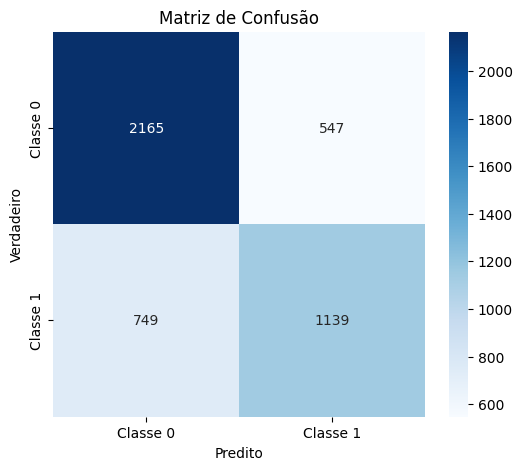

              precision    recall  f1-score   support

    Classe 0       0.74      0.80      0.77      2712
    Classe 1       0.68      0.60      0.64      1888

    accuracy                           0.72      4600
   macro avg       0.71      0.70      0.70      4600
weighted avg       0.72      0.72      0.72      4600



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


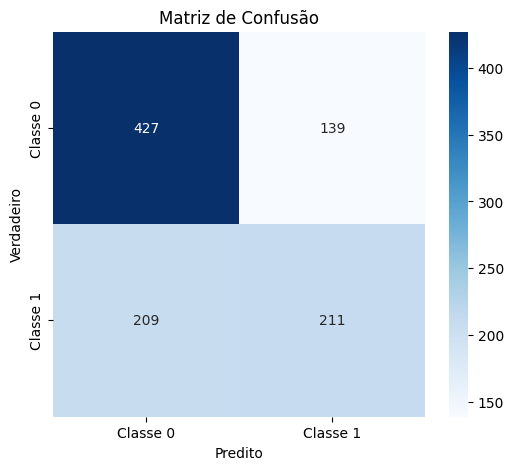

              precision    recall  f1-score   support

    Classe 0       0.67      0.75      0.71       566
    Classe 1       0.60      0.50      0.55       420

    accuracy                           0.65       986
   macro avg       0.64      0.63      0.63       986
weighted avg       0.64      0.65      0.64       986



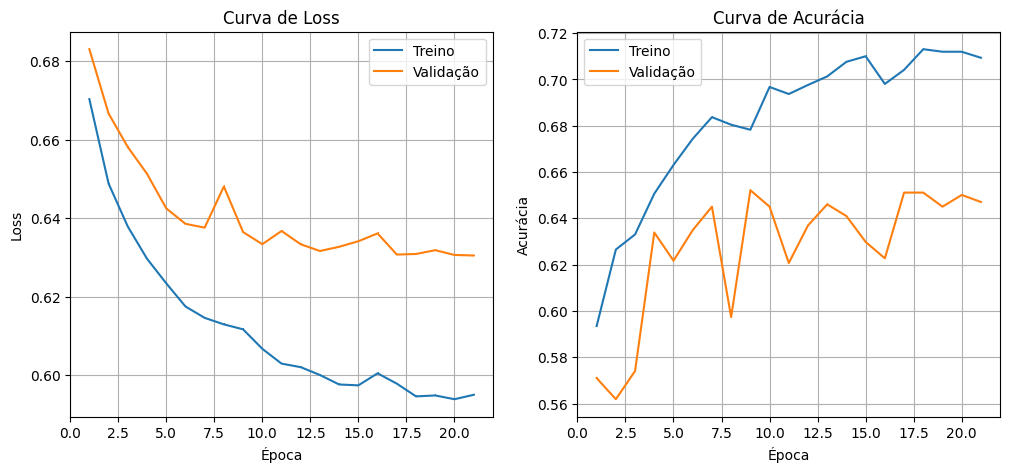

In [ ]:
""" model = CancerDetectionAlexNet(train_last_n=5)
history = model.train_model(train_loader, val_loader, num_epochs=15)"""
evaluate_model_sklearn(model, train_loader)
evaluate_model_sklearn(model, val_loader)

# Chamar a função com o histórico salvo
plot_training_history(history)

## VGG

In [ ]:
temp = CancerDetectionVGG11(train_last_n=7)
total_layers = sum(1 for p in temp.model.classifier.parameters())
for param in temp.model.classifier.parameters():
          print(param.requires_grad)
print('\n\npimbapimbapimban\n')
for param in temp.model.features.parameters():
          print(param.requires_grad)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


True
True
True
True
True
True


pimbapimbapimban

False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
False
True


In [ ]:
class CancerDetectionVGG11(nn.Module):
    def __init__(self, num_classes=2, freeze_features=True,train_last_n=1):
        super(CancerDetectionVGG11, self).__init__()

        # Carregar VGG11 pré-treinada
        self.model =  M.vgg11_bn(pretrained=True)
        total_layers = sum(1 for p in temp.parameters())
        i=0
        for param in self.model.parameters():
            if  total_layers - train_last_n > i:
               param.requires_grad = False
            i+=1

        # Substituir a última camada para saída binária
        #self.model.classifier[2]=nn.Dropout(p=0.7,inplace=False)
        #self.model.classifier[5]=nn.Dropout(p=0.7,inplace=False)
        self.model.classifier[0] = nn.Linear(in_features=25088, out_features=2048)
        self.model.classifier[3] = nn.Linear(in_features=2048, out_features=2048)
        self.model.classifier[6] = nn.Linear(in_features=2048, out_features=num_classes)
        self.out= torch.nn.Softmax()
    def forward(self, x):
        output = self.model(x)
        output = self.out(output)
        return output

    def train_model(self, train_loader, val_loader, num_epochs=10, lr=0.001,early_stop=15, min_delta=0.01,optim_alg='adam',wd=0):
        """
        Treina o modelo e retorna o histórico de loss e acurácia.
        """
        criterion = nn.CrossEntropyLoss()
        if optim_alg == 'adam':
            optimizer = optim.Adam(self.model.features.parameters(), lr=lr, weight_decay=wd)
        elif optim_alg == 'sgd':
            optimizer = optim.Adam(self.model.features.parameters(), lr=lr, weight_decay=wd)
        elif optim_alg == 'adagrad':
            optimizer = optim.Adam(self.model.features.parameters(), lr=lr, weight_decay=wd)
        elif optim_alg == 'rmsprop':
            optimizer = optim.Adam(self.model.features.parameters(), lr=lr, weight_decay=wd)


        self.to(device)
        history = {"train_loss": [], "val_loss": [], "train_acc": [], "val_acc": []}
        best_val_loss = float("inf")
        patience = 0
        best_val_acc = 0.0
        best_model_state = None
        for epoch in range(num_epochs):
            self.train()
            train_loss, correct, total = 0, 0, 0
            first = True
            for inputs, labels in train_loader:
                inputs, labels = inputs.to(device), labels.to(device)

                optimizer.zero_grad()
                outputs = self(inputs)
                """if first:
                    first=False
                    print(outputs[0:10],labels[0:10])"""
                loss = criterion(outputs, labels)
                loss.backward()
                optimizer.step()

                train_loss += loss.item()
                _, predicted = torch.max(outputs, 1)
                correct += (predicted == labels).sum().item()
                total += labels.size(0)

            train_loss /= len(train_loader)
            train_acc = correct / total

            # Validação
            self.eval()
            val_loss, correct, total = 0, 0, 0

            with torch.no_grad():
                for inputs, labels in val_loader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    outputs = self(inputs)

                    loss = criterion(outputs, labels)
                    val_loss += loss.item()
                    _, predicted = torch.max(outputs, 1)
                    correct += (predicted == labels).sum().item()
                    total += labels.size(0)

            val_loss /= len(val_loader)
            val_acc = correct / total

            # Salvar histórico
            history["train_loss"].append(train_loss)
            history["val_loss"].append(val_loss)
            history["train_acc"].append(train_acc)
            history["val_acc"].append(val_acc)

            print(f"Epoch [{epoch+1}/{num_epochs}] - "
                  f"Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} - "
                  f"Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
                    # Early stopping com min_delta
            if val_acc > best_val_acc:
                best_val_acc = val_acc
                best_model_state = self.state_dict()  # Armazena os melhores pesos
                print(f"✅ Novo melhor modelo salvo! Val Acc: {best_val_acc:.4f}")
            if val_loss < best_val_loss - min_delta:
                best_val_loss = val_loss
                patience = 0  # Reset patience
            else:
                patience += 1

            if patience >= early_stop:
                print(f"Early stopping triggered at epoch {epoch+1}.")
                break
            elif patience % 5 == 0 and patience > 0:
                 optimizer.param_groups[0]['lr'] /=2
                 print('reduziu')
        if best_model_state:
            self.load_state_dict(best_model_state)
            print("✅ Melhor modelo carregado como estado final!")
        return history

    def save_model(self, file_path="cancer_vgg11.pth"):
        torch.save(self.state_dict(), file_path)
        print(f"Modelo salvo em {file_path}")

    def load_model(self, file_path="cancer_vgg11.pth"):
        self.load_state_dict(torch.load(file_path, map_location=device))
        self.to(device)
        print(f"Modelo carregado de {file_path}")


In [ ]:
seed=42
torch.manual_seed(seed)
torch.cuda.manual_seed(seed)
torch.cuda.manual_seed_all(seed)

In [ ]:
def objective(trial):
  optim_alg = trial.suggest_categorical("optimizer", ["adam", "sgd","adagrad","rmsprop"])
  lr = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
  n_freezed = trial.suggest_int('n_freezed_layes',1,10)
  wd =  trial.suggest_float('weight_decay', 1e-4, 5*1e-2)
  model = CancerDetectionVGG11(train_last_n=n_frezeed)
  history = model.train_model(train_loader, val_loader, num_epochs=25, lr=lr,wd=wd,optim_alg=optim_alg)
  return max(history['val_acc'])

In [ ]:
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=20)
print("Best params: ", study.best_params)
print("Best value: ", study.best_value)
print("Best Trial: ", study.best_trial)
print("Trials: ", study.trials)

[I 2025-03-21 21:28:02,881] A new study created in memory with name: no-name-175c28ac-d7eb-4dd5-8347-f53979215515


Epoch [1/25] - Train Loss: 0.6550, Train Acc: 0.6066 - Val Loss: 0.6402, Val Acc: 0.6393
Epoch [2/25] - Train Loss: 0.5996, Train Acc: 0.6841 - Val Loss: 0.6465, Val Acc: 0.6242
Epoch [3/25] - Train Loss: 0.5557, Train Acc: 0.7428 - Val Loss: 0.6021, Val Acc: 0.6879
Epoch [4/25] - Train Loss: 0.5163, Train Acc: 0.7835 - Val Loss: 0.5947, Val Acc: 0.7131
Epoch [5/25] - Train Loss: 0.4700, Train Acc: 0.8386 - Val Loss: 0.6084, Val Acc: 0.6997
Epoch [6/25] - Train Loss: 0.4532, Train Acc: 0.8581 - Val Loss: 0.5996, Val Acc: 0.6997
Epoch [7/25] - Train Loss: 0.4124, Train Acc: 0.9063 - Val Loss: 0.6152, Val Acc: 0.6913
Epoch [8/25] - Train Loss: 0.3941, Train Acc: 0.9233 - Val Loss: 0.5843, Val Acc: 0.7164
Epoch [9/25] - Train Loss: 0.3814, Train Acc: 0.9323 - Val Loss: 0.6223, Val Acc: 0.6728
Epoch [10/25] - Train Loss: 0.3804, Train Acc: 0.9370 - Val Loss: 0.5891, Val Acc: 0.7164
Epoch [11/25] - Train Loss: 0.3775, Train Acc: 0.9416 - Val Loss: 0.6147, Val Acc: 0.7047
Epoch [12/25] - Tra

[I 2025-03-21 21:32:44,942] Trial 0 finished with value: 0.7399328859060402 and parameters: {'optimizer': 'adam', 'learning_rate': 0.005287432167571526, 'n_freezed_layes': 9, 'weight_decay': 0.00015245053479094812}. Best is trial 0 with value: 0.7399328859060402.


Epoch [25/25] - Train Loss: 0.3399, Train Acc: 0.9744 - Val Loss: 0.5942, Val Acc: 0.7097
Epoch [1/25] - Train Loss: 0.6641, Train Acc: 0.5749 - Val Loss: 0.6343, Val Acc: 0.6258
Epoch [2/25] - Train Loss: 0.6362, Train Acc: 0.6412 - Val Loss: 0.6284, Val Acc: 0.6544
Epoch [3/25] - Train Loss: 0.6316, Train Acc: 0.6481 - Val Loss: 0.6382, Val Acc: 0.6695
Epoch [4/25] - Train Loss: 0.6293, Train Acc: 0.6448 - Val Loss: 0.6245, Val Acc: 0.6544
Epoch [5/25] - Train Loss: 0.6302, Train Acc: 0.6506 - Val Loss: 0.6582, Val Acc: 0.6107
Epoch [6/25] - Train Loss: 0.6258, Train Acc: 0.6463 - Val Loss: 0.6300, Val Acc: 0.6309
Epoch [7/25] - Train Loss: 0.6228, Train Acc: 0.6545 - Val Loss: 0.6125, Val Acc: 0.6594
Epoch [8/25] - Train Loss: 0.6244, Train Acc: 0.6437 - Val Loss: 0.6363, Val Acc: 0.6309
Epoch [9/25] - Train Loss: 0.6186, Train Acc: 0.6578 - Val Loss: 0.6483, Val Acc: 0.6158
Epoch [10/25] - Train Loss: 0.6126, Train Acc: 0.6722 - Val Loss: 0.6594, Val Acc: 0.6057
Epoch [11/25] - Tra

[I 2025-03-21 21:36:46,700] Trial 1 finished with value: 0.6895973154362416 and parameters: {'optimizer': 'adam', 'learning_rate': 2.721590628806392e-05, 'n_freezed_layes': 6, 'weight_decay': 0.025491026248066734}. Best is trial 0 with value: 0.7399328859060402.


Epoch [22/25] - Train Loss: 0.6175, Train Acc: 0.6718 - Val Loss: 0.6420, Val Acc: 0.6628
Early stopping triggered at epoch 22.
Epoch [1/25] - Train Loss: 0.6986, Train Acc: 0.5090 - Val Loss: 0.6996, Val Acc: 0.4564
Epoch [2/25] - Train Loss: 0.6995, Train Acc: 0.4885 - Val Loss: 0.7008, Val Acc: 0.4480
Epoch [3/25] - Train Loss: 0.7028, Train Acc: 0.4755 - Val Loss: 0.7013, Val Acc: 0.4564
Epoch [4/25] - Train Loss: 0.7008, Train Acc: 0.4906 - Val Loss: 0.7016, Val Acc: 0.4463
Epoch [5/25] - Train Loss: 0.7001, Train Acc: 0.4777 - Val Loss: 0.7016, Val Acc: 0.4530
Epoch [6/25] - Train Loss: 0.6979, Train Acc: 0.4989 - Val Loss: 0.7018, Val Acc: 0.4413
Epoch [7/25] - Train Loss: 0.6998, Train Acc: 0.4860 - Val Loss: 0.7012, Val Acc: 0.4530
Epoch [8/25] - Train Loss: 0.7010, Train Acc: 0.4748 - Val Loss: 0.7016, Val Acc: 0.4446
Epoch [9/25] - Train Loss: 0.7012, Train Acc: 0.4885 - Val Loss: 0.7015, Val Acc: 0.4513
Epoch [10/25] - Train Loss: 0.7007, Train Acc: 0.4939 - Val Loss: 0.701

[I 2025-03-21 21:39:31,141] Trial 2 finished with value: 0.4563758389261745 and parameters: {'optimizer': 'sgd', 'learning_rate': 2.7792036265765992e-05, 'n_freezed_layes': 2, 'weight_decay': 0.00040221634328648946}. Best is trial 0 with value: 0.7399328859060402.


Epoch [16/25] - Train Loss: 0.7017, Train Acc: 0.4737 - Val Loss: 0.7020, Val Acc: 0.4413
Early stopping triggered at epoch 16.
Epoch [1/25] - Train Loss: 0.6987, Train Acc: 0.4863 - Val Loss: 0.6990, Val Acc: 0.4597
Epoch [2/25] - Train Loss: 0.7016, Train Acc: 0.4726 - Val Loss: 0.6989, Val Acc: 0.4396
Epoch [3/25] - Train Loss: 0.6988, Train Acc: 0.4845 - Val Loss: 0.6980, Val Acc: 0.4547
Epoch [4/25] - Train Loss: 0.7000, Train Acc: 0.4762 - Val Loss: 0.6976, Val Acc: 0.4597
Epoch [5/25] - Train Loss: 0.6990, Train Acc: 0.4816 - Val Loss: 0.6975, Val Acc: 0.4581
Epoch [6/25] - Train Loss: 0.6973, Train Acc: 0.4899 - Val Loss: 0.6977, Val Acc: 0.4564
Epoch [7/25] - Train Loss: 0.6987, Train Acc: 0.4820 - Val Loss: 0.6981, Val Acc: 0.4497
Epoch [8/25] - Train Loss: 0.6990, Train Acc: 0.4834 - Val Loss: 0.6979, Val Acc: 0.4530
Epoch [9/25] - Train Loss: 0.6992, Train Acc: 0.4885 - Val Loss: 0.6978, Val Acc: 0.4530
Epoch [10/25] - Train Loss: 0.7002, Train Acc: 0.4741 - Val Loss: 0.698

[I 2025-03-21 21:42:45,497] Trial 3 finished with value: 0.4597315436241611 and parameters: {'optimizer': 'rmsprop', 'learning_rate': 0.006411332008264957, 'n_freezed_layes': 1, 'weight_decay': 0.024291001065005802}. Best is trial 0 with value: 0.7399328859060402.


Epoch [19/25] - Train Loss: 0.6997, Train Acc: 0.4712 - Val Loss: 0.6979, Val Acc: 0.4530
Early stopping triggered at epoch 19.
Epoch [1/25] - Train Loss: 0.7053, Train Acc: 0.4636 - Val Loss: 0.7105, Val Acc: 0.3624
Epoch [2/25] - Train Loss: 0.7035, Train Acc: 0.4687 - Val Loss: 0.7114, Val Acc: 0.3591
Epoch [3/25] - Train Loss: 0.7041, Train Acc: 0.4618 - Val Loss: 0.7107, Val Acc: 0.3574
Epoch [4/25] - Train Loss: 0.7043, Train Acc: 0.4535 - Val Loss: 0.7104, Val Acc: 0.3607
Epoch [5/25] - Train Loss: 0.7064, Train Acc: 0.4543 - Val Loss: 0.7107, Val Acc: 0.3624
Epoch [6/25] - Train Loss: 0.7040, Train Acc: 0.4622 - Val Loss: 0.7105, Val Acc: 0.3607
Epoch [7/25] - Train Loss: 0.7098, Train Acc: 0.4467 - Val Loss: 0.7106, Val Acc: 0.3607
Epoch [8/25] - Train Loss: 0.7046, Train Acc: 0.4524 - Val Loss: 0.7106, Val Acc: 0.3574
Epoch [9/25] - Train Loss: 0.7069, Train Acc: 0.4557 - Val Loss: 0.7108, Val Acc: 0.3591
Epoch [10/25] - Train Loss: 0.7043, Train Acc: 0.4579 - Val Loss: 0.710

[I 2025-03-21 21:45:29,351] Trial 4 finished with value: 0.3624161073825503 and parameters: {'optimizer': 'sgd', 'learning_rate': 1.3541820864680466e-05, 'n_freezed_layes': 1, 'weight_decay': 0.002198779003378449}. Best is trial 0 with value: 0.7399328859060402.


Epoch [16/25] - Train Loss: 0.7039, Train Acc: 0.4586 - Val Loss: 0.7104, Val Acc: 0.3557
Early stopping triggered at epoch 16.
Epoch [1/25] - Train Loss: 0.6617, Train Acc: 0.5994 - Val Loss: 0.6572, Val Acc: 0.6342
Epoch [2/25] - Train Loss: 0.6370, Train Acc: 0.6419 - Val Loss: 0.6657, Val Acc: 0.6074
Epoch [3/25] - Train Loss: 0.6350, Train Acc: 0.6416 - Val Loss: 0.7147, Val Acc: 0.4849
Epoch [4/25] - Train Loss: 0.6418, Train Acc: 0.6308 - Val Loss: 0.6116, Val Acc: 0.6594
Epoch [5/25] - Train Loss: 0.6345, Train Acc: 0.6362 - Val Loss: 0.6435, Val Acc: 0.6460
Epoch [6/25] - Train Loss: 0.6345, Train Acc: 0.6326 - Val Loss: 0.6260, Val Acc: 0.6695
Epoch [7/25] - Train Loss: 0.6235, Train Acc: 0.6513 - Val Loss: 0.6371, Val Acc: 0.6242
Epoch [8/25] - Train Loss: 0.6191, Train Acc: 0.6567 - Val Loss: 0.6384, Val Acc: 0.6275
Epoch [9/25] - Train Loss: 0.6107, Train Acc: 0.6736 - Val Loss: 0.6410, Val Acc: 0.6460
Epoch [10/25] - Train Loss: 0.6004, Train Acc: 0.6801 - Val Loss: 0.609

[I 2025-03-21 21:50:11,507] Trial 5 finished with value: 0.738255033557047 and parameters: {'optimizer': 'adam', 'learning_rate': 0.0023470103029241537, 'n_freezed_layes': 8, 'weight_decay': 0.04281194313655531}. Best is trial 0 with value: 0.7399328859060402.


Epoch [25/25] - Train Loss: 0.4952, Train Acc: 0.8736 - Val Loss: 0.5948, Val Acc: 0.7114
Epoch [1/25] - Train Loss: 0.6553, Train Acc: 0.6102 - Val Loss: 0.6294, Val Acc: 0.6426
Epoch [2/25] - Train Loss: 0.6057, Train Acc: 0.6790 - Val Loss: 0.6402, Val Acc: 0.6359
Epoch [3/25] - Train Loss: 0.5694, Train Acc: 0.7262 - Val Loss: 0.6222, Val Acc: 0.6695
Epoch [4/25] - Train Loss: 0.5354, Train Acc: 0.7659 - Val Loss: 0.6353, Val Acc: 0.6493
Epoch [5/25] - Train Loss: 0.4936, Train Acc: 0.8163 - Val Loss: 0.6881, Val Acc: 0.6107
Epoch [6/25] - Train Loss: 0.4574, Train Acc: 0.8545 - Val Loss: 0.6069, Val Acc: 0.6812
Epoch [7/25] - Train Loss: 0.4279, Train Acc: 0.8901 - Val Loss: 0.5775, Val Acc: 0.7181
Epoch [8/25] - Train Loss: 0.4121, Train Acc: 0.9038 - Val Loss: 0.6223, Val Acc: 0.6745
Epoch [9/25] - Train Loss: 0.3918, Train Acc: 0.9269 - Val Loss: 0.6053, Val Acc: 0.7047
Epoch [10/25] - Train Loss: 0.3701, Train Acc: 0.9460 - Val Loss: 0.6098, Val Acc: 0.6879
Epoch [11/25] - Tra

[I 2025-03-21 21:54:30,420] Trial 6 finished with value: 0.7181208053691275 and parameters: {'optimizer': 'sgd', 'learning_rate': 0.007548021129390765, 'n_freezed_layes': 10, 'weight_decay': 0.00021102704092385596}. Best is trial 0 with value: 0.7399328859060402.


Epoch [22/25] - Train Loss: 0.3431, Train Acc: 0.9737 - Val Loss: 0.6401, Val Acc: 0.6560
Early stopping triggered at epoch 22.
Epoch [1/25] - Train Loss: 0.6497, Train Acc: 0.6073 - Val Loss: 0.6169, Val Acc: 0.6611
Epoch [2/25] - Train Loss: 0.6055, Train Acc: 0.6801 - Val Loss: 0.6011, Val Acc: 0.6695
Epoch [3/25] - Train Loss: 0.5706, Train Acc: 0.7295 - Val Loss: 0.6122, Val Acc: 0.6779
Epoch [4/25] - Train Loss: 0.5271, Train Acc: 0.7752 - Val Loss: 0.6335, Val Acc: 0.6628
Epoch [5/25] - Train Loss: 0.4936, Train Acc: 0.8188 - Val Loss: 0.6208, Val Acc: 0.6644
Epoch [6/25] - Train Loss: 0.4658, Train Acc: 0.8509 - Val Loss: 0.5749, Val Acc: 0.7248
Epoch [7/25] - Train Loss: 0.4315, Train Acc: 0.8847 - Val Loss: 0.6563, Val Acc: 0.6309
Epoch [8/25] - Train Loss: 0.4219, Train Acc: 0.8963 - Val Loss: 0.6408, Val Acc: 0.6628
Epoch [9/25] - Train Loss: 0.3962, Train Acc: 0.9240 - Val Loss: 0.6086, Val Acc: 0.6913
Epoch [10/25] - Train Loss: 0.3795, Train Acc: 0.9416 - Val Loss: 0.642

[I 2025-03-21 21:58:27,682] Trial 7 finished with value: 0.7265100671140939 and parameters: {'optimizer': 'adam', 'learning_rate': 0.00022238635005740874, 'n_freezed_layes': 7, 'weight_decay': 0.00025545555388343486}. Best is trial 0 with value: 0.7399328859060402.


Epoch [21/25] - Train Loss: 0.3422, Train Acc: 0.9759 - Val Loss: 0.6094, Val Acc: 0.6879
Early stopping triggered at epoch 21.
Epoch [1/25] - Train Loss: 0.6850, Train Acc: 0.5659 - Val Loss: 0.6769, Val Acc: 0.6376
Epoch [2/25] - Train Loss: 0.6845, Train Acc: 0.5684 - Val Loss: 0.6696, Val Acc: 0.6426
Epoch [3/25] - Train Loss: 0.6828, Train Acc: 0.5735 - Val Loss: 0.6656, Val Acc: 0.6443
Epoch [4/25] - Train Loss: 0.6809, Train Acc: 0.5782 - Val Loss: 0.6632, Val Acc: 0.6443
Epoch [5/25] - Train Loss: 0.6785, Train Acc: 0.5825 - Val Loss: 0.6616, Val Acc: 0.6443
Epoch [6/25] - Train Loss: 0.6802, Train Acc: 0.5818 - Val Loss: 0.6587, Val Acc: 0.6443
Epoch [7/25] - Train Loss: 0.6781, Train Acc: 0.5854 - Val Loss: 0.6582, Val Acc: 0.6443
Epoch [8/25] - Train Loss: 0.6773, Train Acc: 0.5857 - Val Loss: 0.6568, Val Acc: 0.6443
Epoch [9/25] - Train Loss: 0.6767, Train Acc: 0.5872 - Val Loss: 0.6563, Val Acc: 0.6443
Epoch [10/25] - Train Loss: 0.6749, Train Acc: 0.5825 - Val Loss: 0.655

[I 2025-03-21 22:02:48,779] Trial 8 finished with value: 0.6442953020134228 and parameters: {'optimizer': 'adam', 'learning_rate': 1.4190471154447627e-05, 'n_freezed_layes': 3, 'weight_decay': 0.00019183738002284047}. Best is trial 0 with value: 0.7399328859060402.


Epoch [25/25] - Train Loss: 0.6710, Train Acc: 0.5908 - Val Loss: 0.6498, Val Acc: 0.6443
Epoch [1/25] - Train Loss: 0.6555, Train Acc: 0.6016 - Val Loss: 0.6247, Val Acc: 0.6443
Epoch [2/25] - Train Loss: 0.6119, Train Acc: 0.6650 - Val Loss: 0.5983, Val Acc: 0.6879
Epoch [3/25] - Train Loss: 0.5696, Train Acc: 0.7233 - Val Loss: 0.6663, Val Acc: 0.5973
Epoch [4/25] - Train Loss: 0.5551, Train Acc: 0.7450 - Val Loss: 0.5890, Val Acc: 0.7047
Epoch [5/25] - Train Loss: 0.5250, Train Acc: 0.7824 - Val Loss: 0.6056, Val Acc: 0.6997
Epoch [6/25] - Train Loss: 0.4908, Train Acc: 0.8206 - Val Loss: 0.5841, Val Acc: 0.7081
Epoch [7/25] - Train Loss: 0.4789, Train Acc: 0.8289 - Val Loss: 0.7149, Val Acc: 0.5705
Epoch [8/25] - Train Loss: 0.4598, Train Acc: 0.8573 - Val Loss: 0.6068, Val Acc: 0.6862
Epoch [9/25] - Train Loss: 0.4404, Train Acc: 0.8764 - Val Loss: 0.6129, Val Acc: 0.6946
Epoch [10/25] - Train Loss: 0.4212, Train Acc: 0.8973 - Val Loss: 0.6055, Val Acc: 0.6913
Epoch [11/25] - Tra

[I 2025-03-21 22:07:42,666] Trial 9 finished with value: 0.7483221476510067 and parameters: {'optimizer': 'adam', 'learning_rate': 1.733460208094606e-05, 'n_freezed_layes': 10, 'weight_decay': 0.0008827399040400526}. Best is trial 9 with value: 0.7483221476510067.


Epoch [25/25] - Train Loss: 0.3478, Train Acc: 0.9712 - Val Loss: 0.6134, Val Acc: 0.6846
Epoch [1/25] - Train Loss: 0.6608, Train Acc: 0.5872 - Val Loss: 0.6333, Val Acc: 0.6493
Epoch [2/25] - Train Loss: 0.6208, Train Acc: 0.6614 - Val Loss: 0.5996, Val Acc: 0.6963
Epoch [3/25] - Train Loss: 0.6007, Train Acc: 0.6877 - Val Loss: 0.6015, Val Acc: 0.6913
Epoch [4/25] - Train Loss: 0.5839, Train Acc: 0.7111 - Val Loss: 0.6396, Val Acc: 0.6275
Epoch [5/25] - Train Loss: 0.5734, Train Acc: 0.7266 - Val Loss: 0.6134, Val Acc: 0.6628
Epoch [6/25] - Train Loss: 0.5566, Train Acc: 0.7547 - Val Loss: 0.5915, Val Acc: 0.7181
Epoch [7/25] - Train Loss: 0.5545, Train Acc: 0.7496 - Val Loss: 0.5991, Val Acc: 0.6779
Epoch [8/25] - Train Loss: 0.5459, Train Acc: 0.7637 - Val Loss: 0.5973, Val Acc: 0.6846
Epoch [9/25] - Train Loss: 0.5338, Train Acc: 0.7950 - Val Loss: 0.6201, Val Acc: 0.6527
Epoch [10/25] - Train Loss: 0.5305, Train Acc: 0.7875 - Val Loss: 0.6428, Val Acc: 0.6393
Epoch [11/25] - Tra

[I 2025-03-21 22:11:26,817] Trial 10 finished with value: 0.7181208053691275 and parameters: {'optimizer': 'adagrad', 'learning_rate': 0.00016764202973008942, 'n_freezed_layes': 4, 'weight_decay': 0.0014294262880283407}. Best is trial 9 with value: 0.7483221476510067.


Epoch [21/25] - Train Loss: 0.4700, Train Acc: 0.8700 - Val Loss: 0.5958, Val Acc: 0.6980
Early stopping triggered at epoch 21.
Epoch [1/25] - Train Loss: 0.6448, Train Acc: 0.6210 - Val Loss: 0.6150, Val Acc: 0.6510
Epoch [2/25] - Train Loss: 0.6012, Train Acc: 0.6812 - Val Loss: 0.6025, Val Acc: 0.6544
Epoch [3/25] - Train Loss: 0.5732, Train Acc: 0.7143 - Val Loss: 0.6044, Val Acc: 0.6829
Epoch [4/25] - Train Loss: 0.5529, Train Acc: 0.7471 - Val Loss: 0.5935, Val Acc: 0.6946
Epoch [5/25] - Train Loss: 0.5220, Train Acc: 0.7741 - Val Loss: 0.6408, Val Acc: 0.6275
Epoch [6/25] - Train Loss: 0.4938, Train Acc: 0.8181 - Val Loss: 0.5832, Val Acc: 0.7215
Epoch [7/25] - Train Loss: 0.4701, Train Acc: 0.8401 - Val Loss: 0.5744, Val Acc: 0.7131
Epoch [8/25] - Train Loss: 0.4554, Train Acc: 0.8545 - Val Loss: 0.5894, Val Acc: 0.7232
Epoch [9/25] - Train Loss: 0.4368, Train Acc: 0.8772 - Val Loss: 0.6144, Val Acc: 0.6795
Epoch [10/25] - Train Loss: 0.4296, Train Acc: 0.8826 - Val Loss: 0.686

[I 2025-03-21 22:15:45,417] Trial 11 finished with value: 0.7298657718120806 and parameters: {'optimizer': 'adam', 'learning_rate': 0.0010594570907779008, 'n_freezed_layes': 10, 'weight_decay': 0.0008036434038317146}. Best is trial 9 with value: 0.7483221476510067.


Epoch [22/25] - Train Loss: 0.3452, Train Acc: 0.9730 - Val Loss: 0.5946, Val Acc: 0.7114
Early stopping triggered at epoch 22.
Epoch [1/25] - Train Loss: 0.6540, Train Acc: 0.6174 - Val Loss: 0.6613, Val Acc: 0.5940
Epoch [2/25] - Train Loss: 0.6286, Train Acc: 0.6524 - Val Loss: 0.6159, Val Acc: 0.6779
Epoch [3/25] - Train Loss: 0.6161, Train Acc: 0.6574 - Val Loss: 0.6070, Val Acc: 0.6611
Epoch [4/25] - Train Loss: 0.6122, Train Acc: 0.6765 - Val Loss: 0.6063, Val Acc: 0.6779
Epoch [5/25] - Train Loss: 0.5993, Train Acc: 0.6934 - Val Loss: 0.6320, Val Acc: 0.6493
Epoch [6/25] - Train Loss: 0.5923, Train Acc: 0.6999 - Val Loss: 0.6068, Val Acc: 0.6980
Epoch [7/25] - Train Loss: 0.5780, Train Acc: 0.7241 - Val Loss: 0.5931, Val Acc: 0.7198
Epoch [8/25] - Train Loss: 0.5557, Train Acc: 0.7486 - Val Loss: 0.6044, Val Acc: 0.6711
Epoch [9/25] - Train Loss: 0.5487, Train Acc: 0.7615 - Val Loss: 0.8362, Val Acc: 0.4262
Epoch [10/25] - Train Loss: 0.5268, Train Acc: 0.7860 - Val Loss: 0.579

[I 2025-03-21 22:20:27,515] Trial 12 finished with value: 0.7483221476510067 and parameters: {'optimizer': 'adagrad', 'learning_rate': 9.995019959612624e-05, 'n_freezed_layes': 9, 'weight_decay': 0.008738733872415711}. Best is trial 9 with value: 0.7483221476510067.


Epoch [25/25] - Train Loss: 0.3971, Train Acc: 0.9521 - Val Loss: 0.5875, Val Acc: 0.7030
Epoch [1/25] - Train Loss: 0.6538, Train Acc: 0.6124 - Val Loss: 0.6476, Val Acc: 0.6225
Epoch [2/25] - Train Loss: 0.6140, Train Acc: 0.6682 - Val Loss: 0.6354, Val Acc: 0.6460
Epoch [3/25] - Train Loss: 0.6081, Train Acc: 0.6729 - Val Loss: 0.6132, Val Acc: 0.6862
Epoch [4/25] - Train Loss: 0.5980, Train Acc: 0.6877 - Val Loss: 0.6572, Val Acc: 0.6208
Epoch [5/25] - Train Loss: 0.5914, Train Acc: 0.6999 - Val Loss: 0.6119, Val Acc: 0.6913
Epoch [6/25] - Train Loss: 0.5784, Train Acc: 0.7129 - Val Loss: 0.5960, Val Acc: 0.6963
Epoch [7/25] - Train Loss: 0.5638, Train Acc: 0.7403 - Val Loss: 0.6000, Val Acc: 0.7047
Epoch [8/25] - Train Loss: 0.5364, Train Acc: 0.7705 - Val Loss: 0.6037, Val Acc: 0.6812
Epoch [9/25] - Train Loss: 0.5186, Train Acc: 0.7889 - Val Loss: 0.5969, Val Acc: 0.6946
Epoch [10/25] - Train Loss: 0.4920, Train Acc: 0.8249 - Val Loss: 0.6415, Val Acc: 0.6258
Epoch [11/25] - Tra

[I 2025-03-21 22:25:08,974] Trial 13 finished with value: 0.7281879194630873 and parameters: {'optimizer': 'adagrad', 'learning_rate': 8.35772257608e-05, 'n_freezed_layes': 8, 'weight_decay': 0.00709570280795423}. Best is trial 9 with value: 0.7483221476510067.


Epoch [25/25] - Train Loss: 0.3686, Train Acc: 0.9708 - Val Loss: 0.6085, Val Acc: 0.6745
Epoch [1/25] - Train Loss: 0.6596, Train Acc: 0.6030 - Val Loss: 0.6268, Val Acc: 0.6426
Epoch [2/25] - Train Loss: 0.6344, Train Acc: 0.6383 - Val Loss: 0.6208, Val Acc: 0.6661
Epoch [3/25] - Train Loss: 0.6159, Train Acc: 0.6693 - Val Loss: 0.6137, Val Acc: 0.6762
Epoch [4/25] - Train Loss: 0.6153, Train Acc: 0.6632 - Val Loss: 0.6244, Val Acc: 0.6560
Epoch [5/25] - Train Loss: 0.6134, Train Acc: 0.6801 - Val Loss: 0.6203, Val Acc: 0.6728
Epoch [6/25] - Train Loss: 0.6056, Train Acc: 0.6927 - Val Loss: 0.6124, Val Acc: 0.6862
Epoch [7/25] - Train Loss: 0.6073, Train Acc: 0.6837 - Val Loss: 0.6135, Val Acc: 0.6527
Epoch [8/25] - Train Loss: 0.6085, Train Acc: 0.6805 - Val Loss: 0.6027, Val Acc: 0.6795
Epoch [9/25] - Train Loss: 0.6014, Train Acc: 0.6945 - Val Loss: 0.6460, Val Acc: 0.6191
Epoch [10/25] - Train Loss: 0.6017, Train Acc: 0.7014 - Val Loss: 0.6087, Val Acc: 0.6913
Epoch [11/25] - Tra

[I 2025-03-21 22:29:13,338] Trial 14 finished with value: 0.7030201342281879 and parameters: {'optimizer': 'adagrad', 'learning_rate': 6.785780491476707e-05, 'n_freezed_layes': 5, 'weight_decay': 0.006575142355744047}. Best is trial 9 with value: 0.7483221476510067.


Epoch [23/25] - Train Loss: 0.5885, Train Acc: 0.7212 - Val Loss: 0.6080, Val Acc: 0.6930
Early stopping triggered at epoch 23.
Epoch [1/25] - Train Loss: 0.6623, Train Acc: 0.6041 - Val Loss: 0.6298, Val Acc: 0.6527
Epoch [2/25] - Train Loss: 0.6274, Train Acc: 0.6488 - Val Loss: 0.6304, Val Acc: 0.6292
Epoch [3/25] - Train Loss: 0.6150, Train Acc: 0.6653 - Val Loss: 0.6003, Val Acc: 0.6711
Epoch [4/25] - Train Loss: 0.6055, Train Acc: 0.6794 - Val Loss: 0.5879, Val Acc: 0.6997
Epoch [5/25] - Train Loss: 0.5920, Train Acc: 0.6924 - Val Loss: 0.6034, Val Acc: 0.6930
Epoch [6/25] - Train Loss: 0.5836, Train Acc: 0.7093 - Val Loss: 0.5975, Val Acc: 0.6997
Epoch [7/25] - Train Loss: 0.5671, Train Acc: 0.7226 - Val Loss: 0.7836, Val Acc: 0.4883
Epoch [8/25] - Train Loss: 0.5552, Train Acc: 0.7554 - Val Loss: 0.5862, Val Acc: 0.7081
Epoch [9/25] - Train Loss: 0.5384, Train Acc: 0.7777 - Val Loss: 0.6151, Val Acc: 0.6795
Epoch [10/25] - Train Loss: 0.5161, Train Acc: 0.7903 - Val Loss: 0.580

[I 2025-03-21 22:33:54,158] Trial 15 finished with value: 0.7399328859060402 and parameters: {'optimizer': 'rmsprop', 'learning_rate': 0.0005424939379956558, 'n_freezed_layes': 9, 'weight_decay': 0.00777072195875765}. Best is trial 9 with value: 0.7483221476510067.


Epoch [25/25] - Train Loss: 0.3808, Train Acc: 0.9604 - Val Loss: 0.6125, Val Acc: 0.6644
Epoch [1/25] - Train Loss: 0.6515, Train Acc: 0.6171 - Val Loss: 0.6322, Val Acc: 0.6174
Epoch [2/25] - Train Loss: 0.6212, Train Acc: 0.6567 - Val Loss: 0.6187, Val Acc: 0.6359
Epoch [3/25] - Train Loss: 0.6115, Train Acc: 0.6679 - Val Loss: 0.6195, Val Acc: 0.6779
Epoch [4/25] - Train Loss: 0.5985, Train Acc: 0.6834 - Val Loss: 0.6064, Val Acc: 0.6611
Epoch [5/25] - Train Loss: 0.5839, Train Acc: 0.7097 - Val Loss: 0.6483, Val Acc: 0.6242
Epoch [6/25] - Train Loss: 0.5714, Train Acc: 0.7273 - Val Loss: 0.6007, Val Acc: 0.6946
Epoch [7/25] - Train Loss: 0.5575, Train Acc: 0.7417 - Val Loss: 0.5964, Val Acc: 0.7030
Epoch [8/25] - Train Loss: 0.5307, Train Acc: 0.7716 - Val Loss: 0.5988, Val Acc: 0.6963
Epoch [9/25] - Train Loss: 0.5132, Train Acc: 0.8022 - Val Loss: 0.5950, Val Acc: 0.6862
Epoch [10/25] - Train Loss: 0.4856, Train Acc: 0.8271 - Val Loss: 0.7016, Val Acc: 0.5956
Epoch [11/25] - Tra

[I 2025-03-21 22:38:35,393] Trial 16 finished with value: 0.7248322147651006 and parameters: {'optimizer': 'adagrad', 'learning_rate': 4.7456478030915586e-05, 'n_freezed_layes': 7, 'weight_decay': 0.004084249899209519}. Best is trial 9 with value: 0.7483221476510067.


Epoch [25/25] - Train Loss: 0.3686, Train Acc: 0.9658 - Val Loss: 0.5972, Val Acc: 0.6930
Epoch [1/25] - Train Loss: 0.6448, Train Acc: 0.6261 - Val Loss: 0.6481, Val Acc: 0.6074
Epoch [2/25] - Train Loss: 0.6033, Train Acc: 0.6884 - Val Loss: 0.6063, Val Acc: 0.6762
Epoch [3/25] - Train Loss: 0.5633, Train Acc: 0.7305 - Val Loss: 0.5962, Val Acc: 0.7064
Epoch [4/25] - Train Loss: 0.5361, Train Acc: 0.7698 - Val Loss: 0.6227, Val Acc: 0.6477
Epoch [5/25] - Train Loss: 0.5200, Train Acc: 0.7821 - Val Loss: 0.5942, Val Acc: 0.6896
Epoch [6/25] - Train Loss: 0.4960, Train Acc: 0.8109 - Val Loss: 0.6091, Val Acc: 0.6896
Epoch [7/25] - Train Loss: 0.4695, Train Acc: 0.8451 - Val Loss: 0.6039, Val Acc: 0.6963
Epoch [8/25] - Train Loss: 0.4587, Train Acc: 0.8606 - Val Loss: 0.6226, Val Acc: 0.6762
Epoch [9/25] - Train Loss: 0.4394, Train Acc: 0.8782 - Val Loss: 0.7208, Val Acc: 0.5772
Epoch [10/25] - Train Loss: 0.4328, Train Acc: 0.8808 - Val Loss: 0.6208, Val Acc: 0.6779
Epoch [11/25] - Tra

[I 2025-03-21 22:42:29,578] Trial 17 finished with value: 0.7063758389261745 and parameters: {'optimizer': 'adagrad', 'learning_rate': 0.00014803935263105945, 'n_freezed_layes': 10, 'weight_decay': 0.0008478564279775222}. Best is trial 9 with value: 0.7483221476510067.


Epoch [20/25] - Train Loss: 0.3538, Train Acc: 0.9661 - Val Loss: 0.6034, Val Acc: 0.6846
Early stopping triggered at epoch 20.
Epoch [1/25] - Train Loss: 0.6559, Train Acc: 0.6041 - Val Loss: 0.6291, Val Acc: 0.6426
Epoch [2/25] - Train Loss: 0.6298, Train Acc: 0.6455 - Val Loss: 0.6190, Val Acc: 0.6594
Epoch [3/25] - Train Loss: 0.6199, Train Acc: 0.6628 - Val Loss: 0.6062, Val Acc: 0.6728
Epoch [4/25] - Train Loss: 0.6117, Train Acc: 0.6740 - Val Loss: 0.6027, Val Acc: 0.6711
Epoch [5/25] - Train Loss: 0.6073, Train Acc: 0.6794 - Val Loss: 0.6436, Val Acc: 0.6174
Epoch [6/25] - Train Loss: 0.5960, Train Acc: 0.6924 - Val Loss: 0.7279, Val Acc: 0.5201
Epoch [7/25] - Train Loss: 0.5869, Train Acc: 0.7043 - Val Loss: 0.6146, Val Acc: 0.6795
Epoch [8/25] - Train Loss: 0.5729, Train Acc: 0.7197 - Val Loss: 0.5966, Val Acc: 0.6913
Epoch [9/25] - Train Loss: 0.5619, Train Acc: 0.7457 - Val Loss: 0.5940, Val Acc: 0.7097
Epoch [10/25] - Train Loss: 0.5405, Train Acc: 0.7666 - Val Loss: 0.596

[I 2025-03-21 22:47:10,621] Trial 18 finished with value: 0.7332214765100671 and parameters: {'optimizer': 'rmsprop', 'learning_rate': 0.0006877232142569508, 'n_freezed_layes': 8, 'weight_decay': 0.014896517573891927}. Best is trial 9 with value: 0.7483221476510067.


Epoch [25/25] - Train Loss: 0.4057, Train Acc: 0.9510 - Val Loss: 0.5793, Val Acc: 0.7232
Epoch [1/25] - Train Loss: 0.6491, Train Acc: 0.6081 - Val Loss: 0.6100, Val Acc: 0.7030
Epoch [2/25] - Train Loss: 0.6173, Train Acc: 0.6589 - Val Loss: 0.6086, Val Acc: 0.6661
Epoch [3/25] - Train Loss: 0.5960, Train Acc: 0.6927 - Val Loss: 0.6149, Val Acc: 0.6711
Epoch [4/25] - Train Loss: 0.5840, Train Acc: 0.7035 - Val Loss: 0.5958, Val Acc: 0.7164
Epoch [5/25] - Train Loss: 0.5648, Train Acc: 0.7396 - Val Loss: 0.6077, Val Acc: 0.7030
Epoch [6/25] - Train Loss: 0.5651, Train Acc: 0.7352 - Val Loss: 0.6059, Val Acc: 0.6829
Epoch [7/25] - Train Loss: 0.5400, Train Acc: 0.7640 - Val Loss: 0.6022, Val Acc: 0.6980
Epoch [8/25] - Train Loss: 0.5358, Train Acc: 0.7684 - Val Loss: 0.5986, Val Acc: 0.6829
Epoch [9/25] - Train Loss: 0.5136, Train Acc: 0.7943 - Val Loss: 0.6054, Val Acc: 0.6879
Epoch [10/25] - Train Loss: 0.4912, Train Acc: 0.8199 - Val Loss: 0.6903, Val Acc: 0.5805
Epoch [11/25] - Tra

[I 2025-03-21 22:51:52,906] Trial 19 finished with value: 0.7164429530201343 and parameters: {'optimizer': 'adagrad', 'learning_rate': 3.260700957260211e-05, 'n_freezed_layes': 9, 'weight_decay': 0.003127128691696659}. Best is trial 9 with value: 0.7483221476510067.


Epoch [25/25] - Train Loss: 0.3594, Train Acc: 0.9705 - Val Loss: 0.5932, Val Acc: 0.7030
Best params:  {'optimizer': 'adam', 'learning_rate': 1.733460208094606e-05, 'n_freezed_layes': 10, 'weight_decay': 0.0008827399040400526}
Best value:  0.7483221476510067
Best Trial:  FrozenTrial(number=9, state=TrialState.COMPLETE, values=[0.7483221476510067], datetime_start=datetime.datetime(2025, 3, 21, 22, 2, 48, 780116), datetime_complete=datetime.datetime(2025, 3, 21, 22, 7, 42, 665875), params={'optimizer': 'adam', 'learning_rate': 1.733460208094606e-05, 'n_freezed_layes': 10, 'weight_decay': 0.0008827399040400526}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'optimizer': CategoricalDistribution(choices=('adam', 'sgd', 'adagrad', 'rmsprop')), 'learning_rate': FloatDistribution(high=0.01, log=True, low=1e-05, step=None), 'n_freezed_layes': IntDistribution(high=10, log=False, low=1, step=1), 'weight_decay': FloatDistribution(high=0.05, log=True, low=0.0001, step=None

In [ ]:
Sdevice = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Instanciar o modelo
model = CancerDetectionVGG11(train_last_n=10)
# Treinar o modelo3
history = model.train_model(train_loader, val_loader, num_epochs=50,wd=0.1)

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG11_BN_Weights.IMAGENET1K_V1`. You can also use `weights=VGG11_BN_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


Epoch [1/50] - Train Loss: 0.6942, Train Acc: 0.4680 - Val Loss: 0.6927, Val Acc: 0.5680
✅ Novo melhor modelo salvo! Val Acc: 0.5680
Epoch [2/50] - Train Loss: 0.6842, Train Acc: 0.5785 - Val Loss: 0.6874, Val Acc: 0.5771
✅ Novo melhor modelo salvo! Val Acc: 0.5771
Epoch [3/50] - Train Loss: 0.6711, Train Acc: 0.6028 - Val Loss: 0.6795, Val Acc: 0.5892
✅ Novo melhor modelo salvo! Val Acc: 0.5892
Epoch [4/50] - Train Loss: 0.6624, Train Acc: 0.6176 - Val Loss: 0.6704, Val Acc: 0.6075
✅ Novo melhor modelo salvo! Val Acc: 0.6075
Epoch [5/50] - Train Loss: 0.6620, Train Acc: 0.6096 - Val Loss: 0.6638, Val Acc: 0.5974
Epoch [6/50] - Train Loss: 0.6613, Train Acc: 0.6120 - Val Loss: 0.6657, Val Acc: 0.5913
Epoch [7/50] - Train Loss: 0.6614, Train Acc: 0.6117 - Val Loss: 0.6650, Val Acc: 0.5984
Epoch [8/50] - Train Loss: 0.6612, Train Acc: 0.6126 - Val Loss: 0.6679, Val Acc: 0.6034
Epoch [9/50] - Train Loss: 0.6635, Train Acc: 0.6074 - Val Loss: 0.6641, Val Acc: 0.5913
Epoch [10/50] - Train L

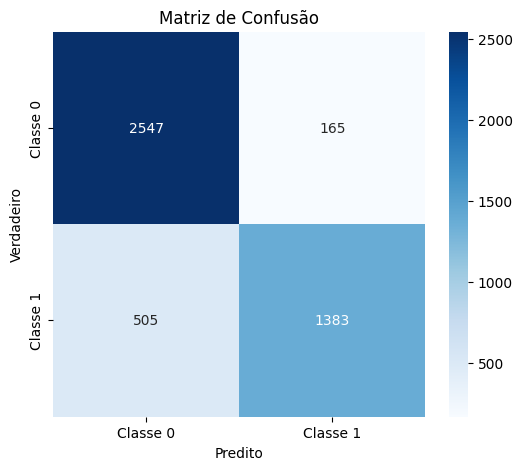

              precision    recall  f1-score   support

    Classe 0       0.83      0.94      0.88      2712
    Classe 1       0.89      0.73      0.81      1888

    accuracy                           0.85      4600
   macro avg       0.86      0.84      0.84      4600
weighted avg       0.86      0.85      0.85      4600



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


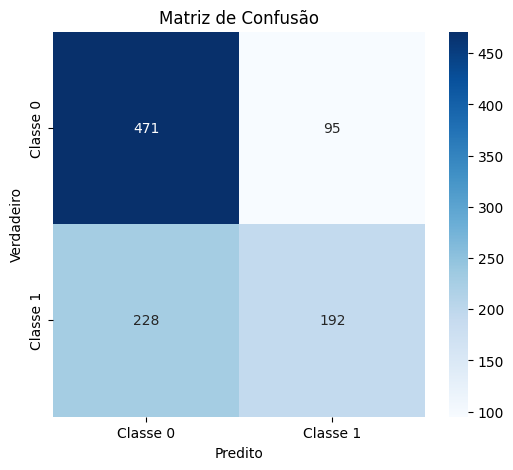

              precision    recall  f1-score   support

    Classe 0       0.67      0.83      0.74       566
    Classe 1       0.67      0.46      0.54       420

    accuracy                           0.67       986
   macro avg       0.67      0.64      0.64       986
weighted avg       0.67      0.67      0.66       986



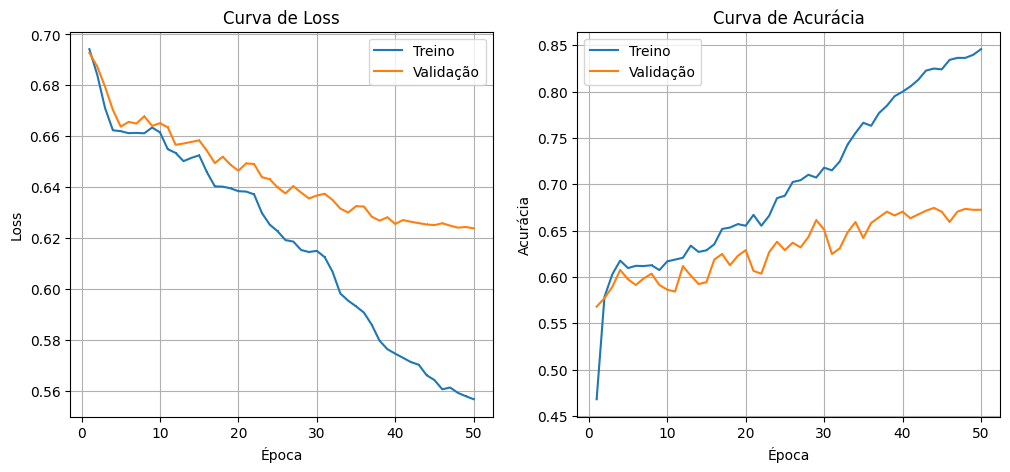

In [ ]:
#model = CancerDetectionVGG11(train_last_n=10)
#history = model.train_model(train_loader, val_loader, num_epochs=50,wd=0.1)
#  pesos do clasisificador -> 4096 -> 2048 ( desde o começo)
evaluate_model_sklearn(model, train_loader)
evaluate_model_sklearn(model, val_loader)
plot_training_history(history)

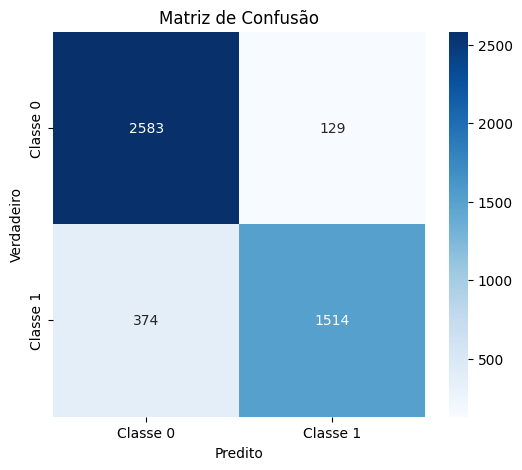

              precision    recall  f1-score   support

    Classe 0       0.87      0.95      0.91      2712
    Classe 1       0.92      0.80      0.86      1888

    accuracy                           0.89      4600
   macro avg       0.90      0.88      0.88      4600
weighted avg       0.89      0.89      0.89      4600



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


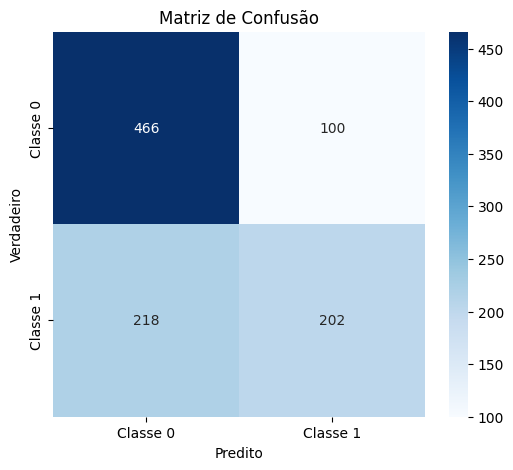

              precision    recall  f1-score   support

    Classe 0       0.68      0.82      0.75       566
    Classe 1       0.67      0.48      0.56       420

    accuracy                           0.68       986
   macro avg       0.68      0.65      0.65       986
weighted avg       0.68      0.68      0.67       986



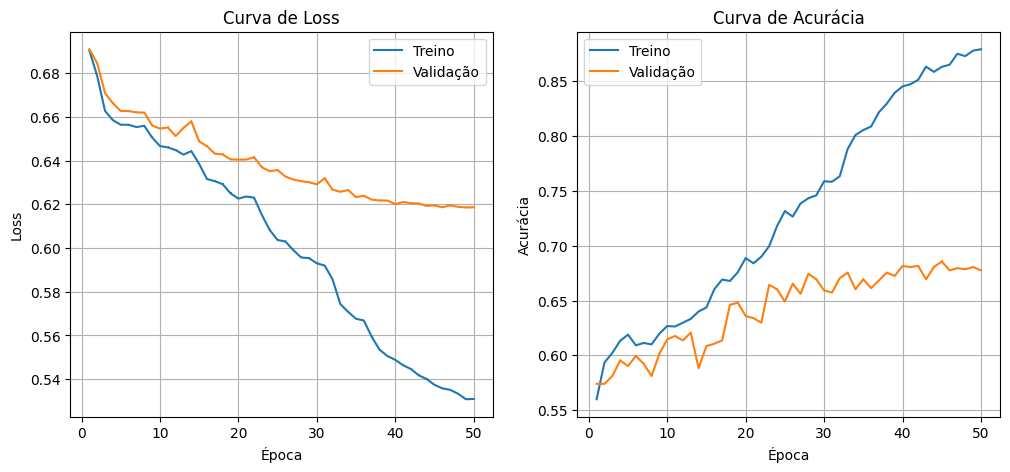

In [ ]:
#model = CancerDetectionVGG11(train_last_n=10)
#history = model.train_model(train_loader, val_loader, num_epochs=50,wd=0.05)
# 4096 -> 2048
evaluate_model_sklearn(model, train_loader)
evaluate_model_sklearn(model, val_loader)
plot_training_history(history)

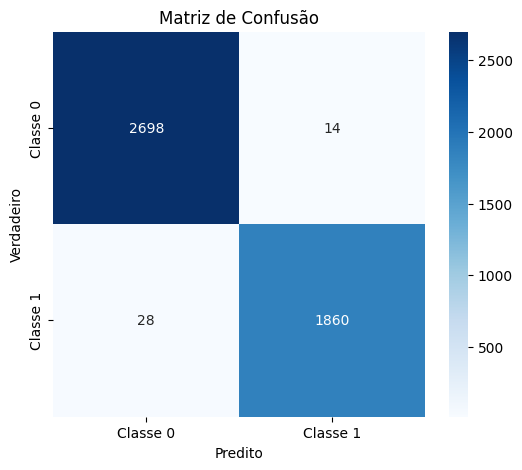

              precision    recall  f1-score   support

    Classe 0       0.99      0.99      0.99      2712
    Classe 1       0.99      0.99      0.99      1888

    accuracy                           0.99      4600
   macro avg       0.99      0.99      0.99      4600
weighted avg       0.99      0.99      0.99      4600



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


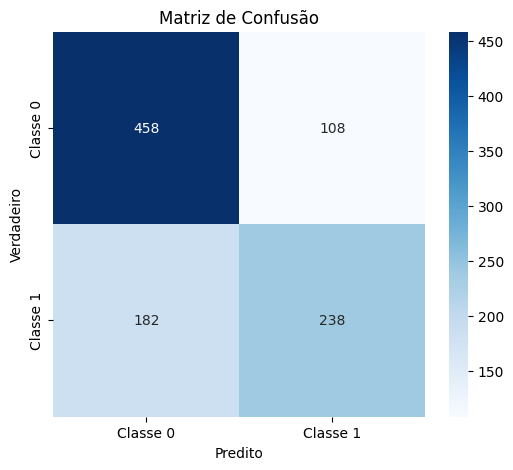

              precision    recall  f1-score   support

    Classe 0       0.72      0.81      0.76       566
    Classe 1       0.69      0.57      0.62       420

    accuracy                           0.71       986
   macro avg       0.70      0.69      0.69       986
weighted avg       0.70      0.71      0.70       986



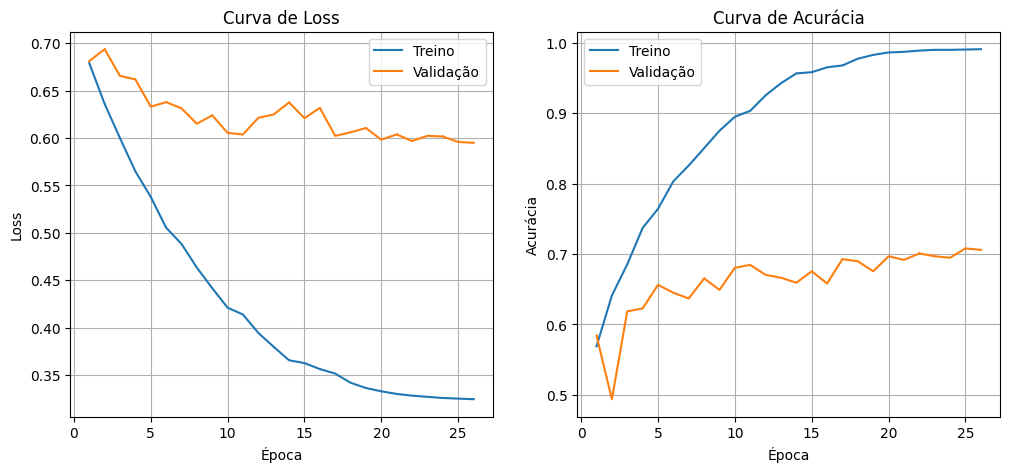

In [ ]:
"""model = CancerDetectionVGG11(train_last_n=10)
# Treinar o modelo3
history = model.train_model(train_loader, val_loader, num_epochs=30,wd=0.008)"""
# Chamar a função para avaliar no conjunto de validação
evaluate_model_sklearn(model, train_loader)
evaluate_model_sklearn(model, val_loader)

# Chamar a função com o histórico salvo
plot_training_history(history)

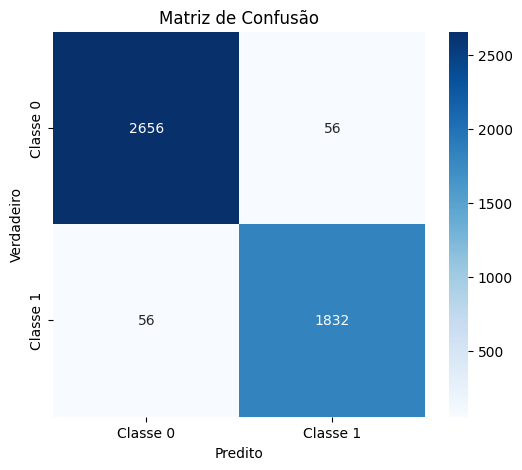

              precision    recall  f1-score   support

    Classe 0       0.98      0.98      0.98      2712
    Classe 1       0.97      0.97      0.97      1888

    accuracy                           0.98      4600
   macro avg       0.97      0.97      0.97      4600
weighted avg       0.98      0.98      0.98      4600



/usr/local/lib/python3.11/dist-packages/torch/nn/modules/module.py:1739: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
  return self._call_impl(*args, **kwargs)


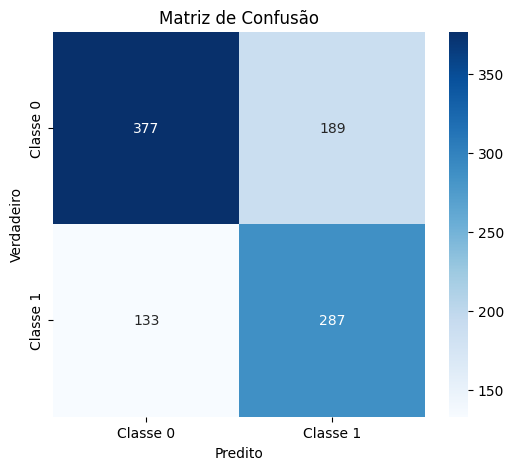

              precision    recall  f1-score   support

    Classe 0       0.74      0.67      0.70       566
    Classe 1       0.60      0.68      0.64       420

    accuracy                           0.67       986
   macro avg       0.67      0.67      0.67       986
weighted avg       0.68      0.67      0.68       986



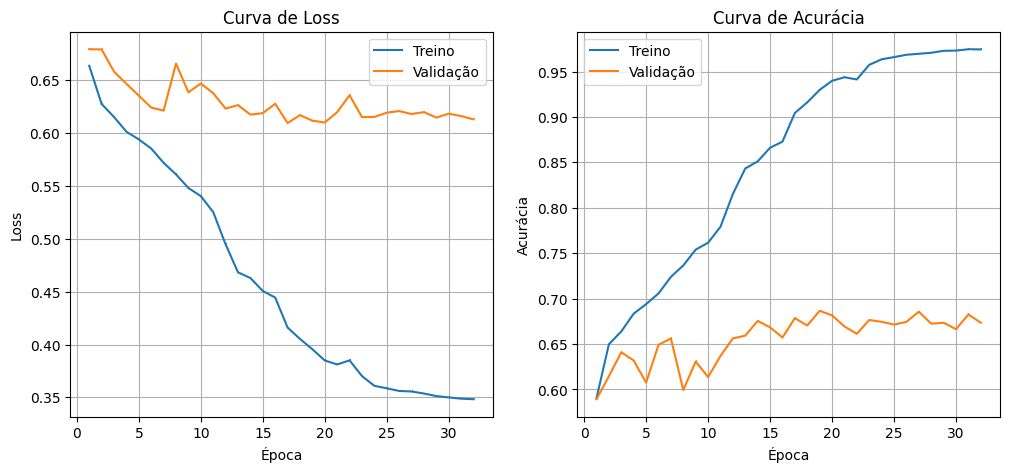

In [ ]:
"""model = CancerDetectionVGG11(train_last_n=10)
history = model.train_model(train_loader, val_loader, num_epochs=50,wd=0.05)"""
# Chamar a função para avaliar no conjunto de validação
evaluate_model_sklearn(model, train_loader)
evaluate_model_sklearn(model, val_loader)

# Chamar a função com o histórico salvo
plot_training_history(history)